In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import initializers

In [61]:
#Определим некоторые переменные
#Использование tensorflow в качестве бэкграунда
os.environ["KERAS_BACKEND"] = "tensorflow"
#Проверяем, что можем воспроизвести эксперимент и получить такие же результаты
np.random.seed(10)
#Задаем размер вектора шума
random_dim = 100


# Cобраем данные и делаем их предварительную обработк.
# Будем использовать датасет MNIST (набор изображений цифр от 0 до 9)
# Генерация символов с gan
# Пример символов из датасета MNIST

In [62]:
def load_minst_data():
    # Загружаем данные
    # Команда mnist.load_data() является частью Keras и позволяет импортировать датасет в рабочее пространство
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Нормализуем ввод в диапазоне [-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # преобразуем x_train с (60000, 28, 28) к (60000, 784)
    # имеем 784 столбца за строку
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [63]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [64]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [65]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [66]:
# Cоединяем генератор с дискриминатором

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # устанавливаем обучение в ложь, тк хотим только обучать
    # генератор или дискриминатор за раз
    discriminator.trainable = False
    # входной шум GAN
    gan_input = Input(shape=(random_dim,))
    # выход генератора (изображение)
    x = generator(gan_input)
    # ваход дискриминатора (вероятность)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [67]:
# Дополнительно создаем функцию, сохраняющую сгенерированные изображения через каждые 20 эпох
# Этот шаг не является основным в туториале, вам не обязательно полностью понимать выводящую изображение функцию.

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [68]:
def train(epochs=1, batch_size=128):
    # получаем данные тренировки и тестирования
    x_train, y_train, x_test, y_test = load_minst_data()
    # разделяем данные обучения на пакеты размером 128
    batch_count = x_train.shape[0] / batch_size

    # создаем сеть
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15, end=" ")
        for _ in tqdm(range(int(batch_count))):
            # получаем случайный набор помех на входе изображения
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # создаем поддельные изображения MNIST
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # метки для сгенерированных и реальных данных
            y_dis = np.zeros(2*batch_size)
            # одностороннее выравнивание метки
            y_dis[:batch_size] = 0.9

            # обучаем дискриминатор
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # обучаем генератор
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)
    # Сохранение генератора
    generator.save('generator_model.h5')

    # Сохранение дискриминатора
    discriminator.save('discriminator_model.h5')
    gan.save('gan_model.h5')

--------------- Epoch 1 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


  0%|          | 1/468 [00:01<11:28,  1.47s/it]

4/4 [==============================] - 0s 7ms/step


  0%|          | 2/468 [00:01<05:38,  1.38it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 3/468 [00:01<03:46,  2.05it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 4/468 [00:02<02:56,  2.63it/s]

4/4 [==============================] - 0s 7ms/step


  1%|          | 5/468 [00:02<02:26,  3.15it/s]

4/4 [==============================] - 0s 7ms/step


  1%|▏         | 6/468 [00:02<02:13,  3.45it/s]

4/4 [==============================] - 0s 6ms/step


  1%|▏         | 7/468 [00:02<01:59,  3.86it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 8/468 [00:02<01:50,  4.17it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 9/468 [00:03<01:44,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


  2%|▏         | 10/468 [00:03<01:45,  4.33it/s]

4/4 [==============================] - 0s 6ms/step


  2%|▏         | 11/468 [00:03<01:40,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 12/468 [00:03<01:42,  4.44it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 13/468 [00:04<01:43,  4.40it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 14/468 [00:04<01:42,  4.45it/s]

4/4 [==============================] - 0s 6ms/step


  3%|▎         | 15/468 [00:04<01:39,  4.54it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 16/468 [00:04<01:36,  4.68it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▎         | 17/468 [00:04<01:41,  4.45it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▍         | 18/468 [00:05<01:43,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 19/468 [00:05<01:47,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 20/468 [00:05<01:49,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 21/468 [00:05<01:45,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


  5%|▍         | 22/468 [00:06<01:40,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 23/468 [00:06<01:49,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 24/468 [00:06<01:59,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 25/468 [00:07<02:04,  3.57it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▌         | 26/468 [00:07<02:12,  3.34it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 27/468 [00:07<02:14,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 28/468 [00:07<02:15,  3.25it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 29/468 [00:08<02:14,  3.27it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▋         | 30/468 [00:08<02:18,  3.17it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 31/468 [00:08<02:19,  3.13it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 32/468 [00:09<02:17,  3.18it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 33/468 [00:09<02:15,  3.21it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 34/468 [00:09<02:18,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 35/468 [00:10<02:15,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 36/468 [00:10<02:15,  3.18it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 37/468 [00:10<02:06,  3.41it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 38/468 [00:10<01:53,  3.78it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 39/468 [00:11<01:49,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▊         | 40/468 [00:11<01:45,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 41/468 [00:11<01:42,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▉         | 42/468 [00:11<01:36,  4.39it/s]

4/4 [==============================] - 0s 6ms/step


  9%|▉         | 43/468 [00:12<01:42,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 44/468 [00:12<02:17,  3.08it/s]

4/4 [==============================] - 0s 7ms/step


 10%|▉         | 45/468 [00:12<02:05,  3.37it/s]

4/4 [==============================] - 0s 7ms/step


 10%|▉         | 46/468 [00:13<01:56,  3.62it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 47/468 [00:13<01:49,  3.83it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 48/468 [00:13<01:46,  3.95it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 49/468 [00:13<01:40,  4.18it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█         | 50/468 [00:13<01:39,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


 11%|█         | 51/468 [00:14<01:38,  4.22it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█         | 52/468 [00:14<01:38,  4.24it/s]

4/4 [==============================] - 0s 6ms/step


 11%|█▏        | 53/468 [00:14<01:35,  4.35it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 54/468 [00:14<01:32,  4.49it/s]

4/4 [==============================] - 0s 7ms/step


 12%|█▏        | 55/468 [00:15<01:35,  4.33it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 56/468 [00:15<01:37,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 57/468 [00:15<01:42,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 58/468 [00:15<01:42,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 59/468 [00:16<01:40,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 60/468 [00:16<01:41,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:16<01:44,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 62/468 [00:16<01:43,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 63/468 [00:17<01:44,  3.88it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▎        | 64/468 [00:17<01:36,  4.17it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 65/468 [00:17<01:32,  4.35it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▍        | 66/468 [00:17<01:32,  4.35it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:18<01:31,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 68/468 [00:18<01:34,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:18<01:36,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 70/468 [00:18<01:40,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 71/468 [00:19<01:39,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 72/468 [00:19<01:41,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 73/468 [00:19<01:42,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 74/468 [00:19<01:43,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 75/468 [00:20<01:42,  3.85it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 76/468 [00:20<01:40,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▋        | 77/468 [00:20<01:44,  3.74it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 78/468 [00:21<01:56,  3.33it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 79/468 [00:21<02:00,  3.22it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 80/468 [00:21<02:02,  3.17it/s]

4/4 [==============================] - 0s 14ms/step


 17%|█▋        | 81/468 [00:22<02:03,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 82/468 [00:22<02:05,  3.08it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 83/468 [00:22<02:03,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 84/468 [00:23<02:03,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 85/468 [00:23<02:02,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 86/468 [00:23<02:01,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▊        | 87/468 [00:23<02:01,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:24<02:02,  3.11it/s]

4/4 [==============================] - 0s 12ms/step


 19%|█▉        | 89/468 [00:24<02:06,  2.99it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 90/468 [00:25<02:10,  2.91it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 91/468 [00:25<01:58,  3.17it/s]

4/4 [==============================] - 0s 7ms/step


 20%|█▉        | 92/468 [00:25<01:46,  3.53it/s]

4/4 [==============================] - 0s 6ms/step


 20%|█▉        | 93/468 [00:25<01:37,  3.86it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 94/468 [00:25<01:33,  3.99it/s]

4/4 [==============================] - 0s 7ms/step


 20%|██        | 95/468 [00:26<01:28,  4.21it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 96/468 [00:26<01:24,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 97/468 [00:26<01:21,  4.57it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 98/468 [00:26<01:23,  4.46it/s]

4/4 [==============================] - 0s 6ms/step


 21%|██        | 99/468 [00:27<01:23,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██▏       | 100/468 [00:27<01:21,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 101/468 [00:27<01:23,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 102/468 [00:27<01:26,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:27<01:26,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 104/468 [00:28<01:29,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 105/468 [00:28<01:29,  4.06it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 106/468 [00:28<01:30,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 107/468 [00:28<01:29,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 108/468 [00:29<01:31,  3.94it/s]

4/4 [==============================] - 0s 7ms/step


 23%|██▎       | 109/468 [00:29<01:26,  4.13it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▎       | 110/468 [00:29<01:25,  4.17it/s]

4/4 [==============================] - 0s 6ms/step


 24%|██▎       | 111/468 [00:29<01:21,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▍       | 112/468 [00:30<01:23,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▍       | 113/468 [00:30<01:21,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 24%|██▍       | 114/468 [00:30<01:18,  4.51it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▍       | 115/468 [00:30<01:15,  4.65it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▍       | 116/468 [00:30<01:13,  4.76it/s]

4/4 [==============================] - 0s 7ms/step


 25%|██▌       | 117/468 [00:31<01:13,  4.78it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▌       | 118/468 [00:31<01:16,  4.60it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 119/468 [00:31<01:18,  4.47it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 120/468 [00:31<01:20,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 121/468 [00:32<01:27,  3.97it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▌       | 122/468 [00:32<01:27,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▋       | 123/468 [00:32<01:25,  4.03it/s]

4/4 [==============================] - 0s 7ms/step


 26%|██▋       | 124/468 [00:32<01:23,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 125/468 [00:33<01:18,  4.34it/s]

4/4 [==============================] - 0s 7ms/step


 27%|██▋       | 126/468 [00:33<01:18,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 127/468 [00:33<01:19,  4.27it/s]

4/4 [==============================] - 0s 11ms/step


 27%|██▋       | 128/468 [00:33<01:22,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:34<01:22,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 130/468 [00:34<01:24,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 131/468 [00:34<01:26,  3.88it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 132/468 [00:34<01:28,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 133/468 [00:35<01:33,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▊       | 134/468 [00:35<01:46,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 135/468 [00:35<01:46,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:36<01:44,  3.18it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:36<01:45,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:36<01:44,  3.17it/s]

4/4 [==============================] - 0s 10ms/step


 30%|██▉       | 139/468 [00:37<01:41,  3.25it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 140/468 [00:37<01:42,  3.21it/s]

4/4 [==============================] - 0s 9ms/step


 30%|███       | 141/468 [00:37<01:43,  3.16it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 142/468 [00:38<01:42,  3.17it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 143/468 [00:38<01:39,  3.27it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 144/468 [00:38<01:40,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 145/468 [00:39<01:38,  3.27it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 146/468 [00:39<01:39,  3.25it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███▏      | 147/468 [00:39<01:35,  3.37it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 148/468 [00:39<01:26,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 149/468 [00:40<01:19,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 150/468 [00:40<01:18,  4.05it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 151/468 [00:40<01:13,  4.29it/s]

4/4 [==============================] - 0s 7ms/step


 32%|███▏      | 152/468 [00:40<01:15,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 153/468 [00:40<01:15,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 154/468 [00:41<01:15,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 155/468 [00:41<01:13,  4.24it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 156/468 [00:41<01:14,  4.18it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 157/468 [00:41<01:10,  4.39it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 158/468 [00:42<01:11,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▍      | 159/468 [00:42<01:10,  4.37it/s]

4/4 [==============================] - 0s 6ms/step


 34%|███▍      | 160/468 [00:42<01:12,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 161/468 [00:42<01:14,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▍      | 162/468 [00:43<01:14,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 163/468 [00:43<01:16,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 164/468 [00:43<01:18,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 165/468 [00:43<01:17,  3.91it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 166/468 [00:44<01:17,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 167/468 [00:44<01:17,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 168/468 [00:44<01:19,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 169/468 [00:44<01:19,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▋      | 170/468 [00:45<01:20,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 171/468 [00:45<01:24,  3.51it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 172/468 [00:46<01:49,  2.71it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 173/468 [00:46<01:40,  2.95it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 174/468 [00:46<01:34,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 175/468 [00:46<01:26,  3.40it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 176/468 [00:47<01:17,  3.76it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 177/468 [00:47<01:13,  3.93it/s]

4/4 [==============================] - 0s 7ms/step


 38%|███▊      | 178/468 [00:47<01:09,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 179/468 [00:47<01:10,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:48<01:11,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▊      | 181/468 [00:48<01:13,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 182/468 [00:48<01:14,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 183/468 [00:48<01:14,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 184/468 [00:49<01:14,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 185/468 [00:49<01:12,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 186/468 [00:49<01:13,  3.85it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 187/468 [00:49<01:21,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 40%|████      | 188/468 [00:50<01:25,  3.27it/s]

4/4 [==============================] - 0s 10ms/step


 40%|████      | 189/468 [00:50<01:30,  3.08it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 190/468 [00:51<01:34,  2.93it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████      | 191/468 [00:51<01:35,  2.89it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 192/468 [00:51<01:37,  2.83it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 193/468 [00:52<01:35,  2.87it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████▏     | 194/468 [00:52<01:32,  2.96it/s]

4/4 [==============================] - 0s 13ms/step


 42%|████▏     | 195/468 [00:52<01:29,  3.04it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 196/468 [00:53<01:27,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 197/468 [00:53<01:27,  3.10it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 198/468 [00:53<01:27,  3.10it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 199/468 [00:54<01:23,  3.20it/s]

4/4 [==============================] - 0s 6ms/step


 43%|████▎     | 200/468 [00:54<01:18,  3.40it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 201/468 [00:54<01:13,  3.63it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 202/468 [00:54<01:08,  3.90it/s]

4/4 [==============================] - 0s 7ms/step


 43%|████▎     | 203/468 [00:54<01:06,  3.97it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▎     | 204/468 [00:55<01:03,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 205/468 [00:55<01:01,  4.25it/s]

4/4 [==============================] - 0s 7ms/step


 44%|████▍     | 206/468 [00:55<00:59,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 207/468 [00:55<00:57,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 208/468 [00:56<00:58,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 209/468 [00:56<00:57,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▍     | 210/468 [00:56<00:57,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▌     | 211/468 [00:56<00:58,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 45%|████▌     | 212/468 [00:56<00:56,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 213/468 [00:57<00:59,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [00:57<00:59,  4.24it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▌     | 215/468 [00:57<01:00,  4.19it/s]

4/4 [==============================] - 0s 11ms/step


 46%|████▌     | 216/468 [00:57<01:01,  4.09it/s]

4/4 [==============================] - 0s 7ms/step


 46%|████▋     | 217/468 [00:58<00:59,  4.23it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 218/468 [00:58<01:00,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 219/468 [00:58<00:59,  4.18it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 220/468 [00:58<00:59,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 47%|████▋     | 221/468 [00:59<00:59,  4.12it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 222/468 [00:59<01:01,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 223/468 [00:59<01:03,  3.88it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 224/468 [00:59<01:03,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 225/468 [01:00<01:03,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 226/468 [01:00<01:04,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 227/468 [01:00<01:03,  3.77it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▊     | 228/468 [01:00<01:03,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▉     | 229/468 [01:01<01:01,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [01:01<01:02,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:01<01:02,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 232/468 [01:02<01:01,  3.83it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 233/468 [01:02<01:01,  3.84it/s]

4/4 [==============================] - 0s 8ms/step


 50%|█████     | 234/468 [01:02<00:59,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 235/468 [01:02<00:57,  4.03it/s]

4/4 [==============================] - 0s 7ms/step


 50%|█████     | 236/468 [01:02<00:54,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 237/468 [01:03<00:55,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 238/468 [01:03<00:56,  4.07it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 239/468 [01:03<00:58,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [01:04<00:57,  3.97it/s]

4/4 [==============================] - 0s 16ms/step


 51%|█████▏    | 241/468 [01:04<01:02,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 242/468 [01:04<01:14,  3.05it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 243/468 [01:05<01:17,  2.92it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 244/468 [01:05<01:18,  2.87it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 245/468 [01:05<01:18,  2.83it/s]

4/4 [==============================] - 0s 14ms/step


 53%|█████▎    | 246/468 [01:06<01:18,  2.82it/s]

4/4 [==============================] - 0s 12ms/step


 53%|█████▎    | 247/468 [01:06<01:17,  2.87it/s]

4/4 [==============================] - 0s 14ms/step


 53%|█████▎    | 248/468 [01:06<01:16,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 249/468 [01:07<01:13,  2.99it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 250/468 [01:07<01:10,  3.09it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▎    | 251/468 [01:07<01:10,  3.09it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 252/468 [01:08<01:08,  3.17it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 253/468 [01:08<01:07,  3.20it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 254/468 [01:08<01:03,  3.35it/s]

4/4 [==============================] - 0s 8ms/step


 54%|█████▍    | 255/468 [01:08<00:58,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 256/468 [01:09<00:54,  3.86it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▍    | 257/468 [01:09<00:54,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▌    | 258/468 [01:09<00:55,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▌    | 259/468 [01:09<00:55,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▌    | 260/468 [01:10<00:54,  3.78it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▌    | 261/468 [01:10<00:51,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▌    | 262/468 [01:10<00:48,  4.23it/s]

4/4 [==============================] - 0s 7ms/step


 56%|█████▌    | 263/468 [01:10<00:48,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▋    | 264/468 [01:11<00:47,  4.26it/s]

4/4 [==============================] - 0s 7ms/step


 57%|█████▋    | 265/468 [01:11<00:48,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 266/468 [01:11<00:50,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 267/468 [01:11<00:51,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:12<00:51,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:12<00:49,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 270/468 [01:12<00:48,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 271/468 [01:12<00:50,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 272/468 [01:13<00:49,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:13<00:48,  4.06it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▊    | 274/468 [01:13<00:46,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 275/468 [01:13<00:45,  4.23it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 276/468 [01:14<00:45,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 277/468 [01:14<00:45,  4.22it/s]

4/4 [==============================] - 0s 7ms/step


 59%|█████▉    | 278/468 [01:14<00:43,  4.36it/s]

4/4 [==============================] - 0s 7ms/step


 60%|█████▉    | 279/468 [01:14<00:42,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 60%|█████▉    | 280/468 [01:14<00:42,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 60%|██████    | 281/468 [01:15<00:42,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 60%|██████    | 282/468 [01:15<00:42,  4.37it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 283/468 [01:15<00:43,  4.25it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 284/468 [01:15<00:45,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 285/468 [01:16<00:45,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 286/468 [01:16<00:45,  3.96it/s]

4/4 [==============================] - 0s 7ms/step


 61%|██████▏   | 287/468 [01:16<00:44,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 288/468 [01:16<00:43,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 289/468 [01:17<00:42,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 290/468 [01:17<00:40,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 291/468 [01:17<00:39,  4.53it/s]

4/4 [==============================] - 0s 7ms/step


 62%|██████▏   | 292/468 [01:17<00:39,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 293/468 [01:18<00:38,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 294/468 [01:18<00:37,  4.61it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 295/468 [01:18<00:38,  4.51it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 296/468 [01:18<00:41,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 297/468 [01:19<00:44,  3.83it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▎   | 298/468 [01:19<00:47,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 299/468 [01:19<00:48,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▍   | 300/468 [01:20<00:50,  3.30it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▍   | 301/468 [01:20<00:50,  3.30it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▍   | 302/468 [01:20<00:56,  2.96it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 303/468 [01:21<01:00,  2.72it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 304/468 [01:21<01:00,  2.69it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▌   | 305/468 [01:21<01:01,  2.66it/s]

4/4 [==============================] - 0s 11ms/step


 65%|██████▌   | 306/468 [01:22<01:03,  2.54it/s]

4/4 [==============================] - 0s 11ms/step


 66%|██████▌   | 307/468 [01:22<01:06,  2.42it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 308/468 [01:23<01:00,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:23<00:53,  2.95it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 310/468 [01:23<00:49,  3.18it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▋   | 311/468 [01:23<00:45,  3.44it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 312/468 [01:24<00:41,  3.80it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 313/468 [01:24<00:38,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 67%|██████▋   | 314/468 [01:24<00:37,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 315/468 [01:24<00:36,  4.14it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 316/468 [01:24<00:35,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 317/468 [01:25<00:35,  4.28it/s]

4/4 [==============================] - 0s 7ms/step


 68%|██████▊   | 318/468 [01:25<00:34,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 319/468 [01:25<00:33,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 320/468 [01:25<00:34,  4.24it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▊   | 321/468 [01:26<00:35,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 322/468 [01:26<00:36,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 323/468 [01:26<00:36,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 324/468 [01:26<00:36,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 325/468 [01:27<00:37,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 70%|██████▉   | 326/468 [01:27<00:37,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 70%|██████▉   | 327/468 [01:27<00:36,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 70%|███████   | 328/468 [01:28<00:36,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 70%|███████   | 329/468 [01:28<00:35,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:28<00:34,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 331/468 [01:28<00:34,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 332/468 [01:28<00:34,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████   | 333/468 [01:29<00:34,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████▏  | 334/468 [01:29<00:34,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:29<00:34,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 336/468 [01:30<00:32,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 337/468 [01:30<00:31,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 338/468 [01:30<00:30,  4.27it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 339/468 [01:30<00:29,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 340/468 [01:30<00:29,  4.38it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 341/468 [01:31<00:30,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 342/468 [01:31<00:31,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 343/468 [01:31<00:31,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▎  | 344/468 [01:31<00:31,  3.92it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 345/468 [01:32<00:31,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▍  | 346/468 [01:32<00:32,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 347/468 [01:32<00:31,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 348/468 [01:33<00:32,  3.66it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▍  | 349/468 [01:33<00:36,  3.30it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▍  | 350/468 [01:33<00:37,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 75%|███████▌  | 351/468 [01:34<00:39,  2.93it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 352/468 [01:34<00:43,  2.67it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▌  | 353/468 [01:34<00:41,  2.78it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▌  | 354/468 [01:35<00:39,  2.86it/s]

4/4 [==============================] - 0s 12ms/step


 76%|███████▌  | 355/468 [01:35<00:39,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 356/468 [01:35<00:37,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:36<00:36,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 358/468 [01:36<00:35,  3.09it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 359/468 [01:36<00:37,  2.91it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 360/468 [01:37<00:36,  3.00it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 361/468 [01:37<00:33,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [01:37<00:30,  3.44it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 363/468 [01:37<00:27,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 78%|███████▊  | 364/468 [01:38<00:25,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 365/468 [01:38<00:24,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 366/468 [01:38<00:23,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 367/468 [01:38<00:23,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▊  | 368/468 [01:39<00:22,  4.50it/s]

4/4 [==============================] - 0s 7ms/step


 79%|███████▉  | 369/468 [01:39<00:22,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 370/468 [01:39<00:22,  4.40it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 371/468 [01:39<00:22,  4.31it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 372/468 [01:40<00:25,  3.83it/s]

4/4 [==============================] - 0s 14ms/step


 80%|███████▉  | 373/468 [01:40<00:29,  3.20it/s]

4/4 [==============================] - 0s 15ms/step


 80%|███████▉  | 374/468 [01:40<00:32,  2.90it/s]

4/4 [==============================] - 0s 11ms/step


 80%|████████  | 375/468 [01:41<00:32,  2.90it/s]

4/4 [==============================] - 0s 11ms/step


 80%|████████  | 376/468 [01:41<00:30,  2.99it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 377/468 [01:41<00:29,  3.05it/s]

4/4 [==============================] - 0s 12ms/step


 81%|████████  | 378/468 [01:42<00:29,  3.04it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 379/468 [01:42<00:28,  3.15it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████  | 380/468 [01:42<00:28,  3.09it/s]

4/4 [==============================] - 0s 12ms/step


 81%|████████▏ | 381/468 [01:43<00:28,  3.08it/s]

4/4 [==============================] - 0s 12ms/step


 82%|████████▏ | 382/468 [01:43<00:28,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:43<00:27,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 384/468 [01:44<00:27,  3.04it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 385/468 [01:44<00:26,  3.09it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:44<00:26,  3.15it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 387/468 [01:45<00:28,  2.88it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 388/468 [01:45<00:27,  2.88it/s]

4/4 [==============================] - 0s 14ms/step


 83%|████████▎ | 389/468 [01:45<00:26,  2.96it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 390/468 [01:46<00:24,  3.12it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▎ | 391/468 [01:46<00:23,  3.34it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 392/468 [01:46<00:21,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 393/468 [01:46<00:21,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 394/468 [01:47<00:20,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 395/468 [01:47<00:19,  3.68it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▍ | 396/468 [01:47<00:21,  3.35it/s]

4/4 [==============================] - 0s 15ms/step


 85%|████████▍ | 397/468 [01:48<00:23,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 398/468 [01:48<00:23,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 399/468 [01:48<00:22,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 400/468 [01:49<00:23,  2.87it/s]

4/4 [==============================] - 0s 12ms/step


 86%|████████▌ | 401/468 [01:49<00:22,  2.99it/s]

4/4 [==============================] - 0s 12ms/step


 86%|████████▌ | 402/468 [01:49<00:23,  2.78it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 403/468 [01:50<00:23,  2.79it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▋ | 404/468 [01:50<00:22,  2.81it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 405/468 [01:51<00:22,  2.84it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 406/468 [01:51<00:23,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 407/468 [01:51<00:21,  2.79it/s]

4/4 [==============================] - 0s 7ms/step


 87%|████████▋ | 408/468 [01:52<00:19,  3.09it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 409/468 [01:52<00:17,  3.43it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 410/468 [01:52<00:15,  3.77it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 411/468 [01:52<00:14,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 412/468 [01:52<00:13,  4.08it/s]

4/4 [==============================] - 0s 7ms/step


 88%|████████▊ | 413/468 [01:53<00:13,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 414/468 [01:53<00:13,  4.09it/s]

4/4 [==============================] - 0s 12ms/step


 89%|████████▊ | 415/468 [01:53<00:13,  3.94it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▉ | 416/468 [01:53<00:13,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 417/468 [01:54<00:12,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▉ | 418/468 [01:54<00:12,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 419/468 [01:54<00:12,  3.94it/s]

4/4 [==============================] - 0s 11ms/step


 90%|████████▉ | 420/468 [01:54<00:12,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 421/468 [01:55<00:11,  3.93it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 422/468 [01:55<00:11,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 423/468 [01:55<00:10,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 424/468 [01:55<00:10,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 425/468 [01:56<00:09,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 426/468 [01:56<00:09,  4.40it/s]

4/4 [==============================] - 0s 7ms/step


 91%|█████████ | 427/468 [01:56<00:09,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 428/468 [01:56<00:09,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 429/468 [01:56<00:08,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 430/468 [01:57<00:08,  4.67it/s]

4/4 [==============================] - 0s 7ms/step


 92%|█████████▏| 431/468 [01:57<00:08,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 432/468 [01:57<00:07,  4.56it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 433/468 [01:57<00:07,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 434/468 [01:58<00:07,  4.52it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 435/468 [01:58<00:07,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 436/468 [01:58<00:06,  4.63it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 437/468 [01:58<00:06,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [01:58<00:06,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 439/468 [01:59<00:06,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 440/468 [01:59<00:06,  4.59it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 441/468 [01:59<00:06,  4.46it/s]

4/4 [==============================] - 0s 7ms/step


 94%|█████████▍| 442/468 [01:59<00:05,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▍| 443/468 [02:00<00:05,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▍| 444/468 [02:00<00:05,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 95%|█████████▌| 445/468 [02:00<00:05,  4.18it/s]

4/4 [==============================] - 0s 12ms/step


 95%|█████████▌| 446/468 [02:00<00:05,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 447/468 [02:01<00:05,  4.07it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 448/468 [02:01<00:05,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 449/468 [02:01<00:04,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 450/468 [02:01<00:04,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▋| 451/468 [02:02<00:04,  3.91it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 452/468 [02:02<00:04,  3.51it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 453/468 [02:02<00:05,  2.99it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 454/468 [02:03<00:05,  2.72it/s]

4/4 [==============================] - 0s 17ms/step


 97%|█████████▋| 455/468 [02:03<00:05,  2.55it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 456/468 [02:04<00:04,  2.60it/s]

4/4 [==============================] - 0s 14ms/step


 98%|█████████▊| 457/468 [02:04<00:04,  2.64it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 458/468 [02:04<00:03,  2.77it/s]

4/4 [==============================] - 0s 14ms/step


 98%|█████████▊| 459/468 [02:05<00:03,  2.87it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 460/468 [02:05<00:02,  2.96it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:05<00:02,  3.04it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▊| 462/468 [02:06<00:01,  3.03it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 463/468 [02:06<00:01,  3.19it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 464/468 [02:06<00:01,  3.45it/s]

4/4 [==============================] - 0s 7ms/step


 99%|█████████▉| 465/468 [02:06<00:00,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


100%|█████████▉| 466/468 [02:07<00:00,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 467/468 [02:07<00:00,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


100%|██████████| 468/468 [02:07<00:00,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


--------------- Epoch 2 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 1/468 [00:00<02:14,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


  0%|          | 2/468 [00:00<02:10,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 3/468 [00:00<02:13,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 4/468 [00:01<02:08,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 5/468 [00:01<02:09,  3.59it/s]

4/4 [==============================] - 0s 11ms/step


  1%|▏         | 6/468 [00:01<02:10,  3.53it/s]

4/4 [==============================] - 0s 12ms/step


  1%|▏         | 7/468 [00:01<02:09,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


  2%|▏         | 8/468 [00:02<02:11,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 9/468 [00:02<02:10,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 10/468 [00:02<02:09,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:03<02:11,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:03<02:10,  3.50it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 13/468 [00:03<02:04,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


  3%|▎         | 14/468 [00:03<01:56,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:04<01:54,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 16/468 [00:04<01:55,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▎         | 17/468 [00:04<01:56,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 18/468 [00:04<02:09,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


  4%|▍         | 19/468 [00:05<02:29,  3.01it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 20/468 [00:05<02:38,  2.82it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 21/468 [00:06<02:47,  2.67it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▍         | 22/468 [00:06<02:50,  2.62it/s]

4/4 [==============================] - 0s 10ms/step


  5%|▍         | 23/468 [00:07<02:54,  2.55it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▌         | 24/468 [00:07<03:02,  2.43it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▌         | 25/468 [00:07<02:53,  2.55it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▌         | 26/468 [00:08<02:43,  2.71it/s]

4/4 [==============================] - 0s 14ms/step


  6%|▌         | 27/468 [00:08<02:42,  2.72it/s]

4/4 [==============================] - 0s 12ms/step


  6%|▌         | 28/468 [00:08<02:46,  2.65it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 29/468 [00:09<02:40,  2.73it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▋         | 30/468 [00:09<02:22,  3.08it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 31/468 [00:09<02:12,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 32/468 [00:10<02:03,  3.52it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 33/468 [00:10<01:58,  3.66it/s]

4/4 [==============================] - 0s 7ms/step


  7%|▋         | 34/468 [00:10<01:54,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 35/468 [00:10<01:51,  3.87it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 36/468 [00:11<01:50,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


  8%|▊         | 37/468 [00:11<01:45,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 38/468 [00:11<01:43,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


  8%|▊         | 39/468 [00:11<01:44,  4.10it/s]

4/4 [==============================] - 0s 7ms/step


  9%|▊         | 40/468 [00:11<01:47,  3.99it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 41/468 [00:12<01:46,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 42/468 [00:12<01:44,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 43/468 [00:12<01:48,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 44/468 [00:13<01:50,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 45/468 [00:13<01:52,  3.76it/s]

4/4 [==============================] - 0s 11ms/step


 10%|▉         | 46/468 [00:13<01:52,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 47/468 [00:13<01:55,  3.64it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 48/468 [00:14<01:58,  3.53it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 49/468 [00:14<02:03,  3.40it/s]

4/4 [==============================] - 0s 11ms/step


 11%|█         | 50/468 [00:14<02:02,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 51/468 [00:15<02:01,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 52/468 [00:15<02:00,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 11%|█▏        | 53/468 [00:15<01:58,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 54/468 [00:15<01:59,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 55/468 [00:16<01:56,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 56/468 [00:16<01:56,  3.54it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 57/468 [00:16<01:53,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 58/468 [00:16<01:53,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 59/468 [00:17<01:54,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 60/468 [00:17<01:53,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:17<01:50,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 62/468 [00:18<01:51,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 63/468 [00:18<01:50,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▎        | 64/468 [00:18<01:48,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▍        | 65/468 [00:18<01:42,  3.94it/s]

4/4 [==============================] - 0s 7ms/step


 14%|█▍        | 66/468 [00:19<01:38,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▍        | 67/468 [00:19<01:37,  4.12it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▍        | 68/468 [00:19<01:47,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:19<01:59,  3.35it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▍        | 70/468 [00:20<02:02,  3.24it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▌        | 71/468 [00:20<02:04,  3.18it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▌        | 72/468 [00:21<02:08,  3.08it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 73/468 [00:21<02:09,  3.05it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 74/468 [00:21<02:08,  3.06it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 75/468 [00:22<02:16,  2.87it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 76/468 [00:22<02:15,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▋        | 77/468 [00:22<02:11,  2.97it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 78/468 [00:23<02:07,  3.07it/s]

4/4 [==============================] - 0s 12ms/step


 17%|█▋        | 79/468 [00:23<02:08,  3.03it/s]

4/4 [==============================] - 0s 12ms/step


 17%|█▋        | 80/468 [00:23<02:09,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 81/468 [00:23<02:01,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 82/468 [00:24<01:50,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:24<01:45,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 84/468 [00:24<01:38,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


 18%|█▊        | 85/468 [00:24<01:40,  3.80it/s]

4/4 [==============================] - 0s 11ms/step


 18%|█▊        | 86/468 [00:25<01:42,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 19%|█▊        | 87/468 [00:25<01:42,  3.72it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 88/468 [00:25<01:42,  3.70it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 89/468 [00:25<01:39,  3.82it/s]

4/4 [==============================] - 0s 7ms/step


 19%|█▉        | 90/468 [00:26<01:37,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 91/468 [00:26<01:31,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 20%|█▉        | 92/468 [00:26<01:30,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 20%|█▉        | 93/468 [00:26<01:32,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 20%|██        | 94/468 [00:27<01:34,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 20%|██        | 95/468 [00:27<01:34,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 96/468 [00:27<01:34,  3.92it/s]

4/4 [==============================] - 0s 7ms/step


 21%|██        | 97/468 [00:27<01:32,  3.99it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 98/468 [00:28<01:30,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:28<01:28,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██▏       | 100/468 [00:28<01:25,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 101/468 [00:28<01:26,  4.23it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 102/468 [00:29<01:30,  4.06it/s]

4/4 [==============================] - 0s 14ms/step


 22%|██▏       | 103/468 [00:29<01:40,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:29<01:39,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:30<01:35,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 106/468 [00:30<01:29,  4.06it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 107/468 [00:30<01:26,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 108/468 [00:30<01:23,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 109/468 [00:30<01:25,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▎       | 110/468 [00:31<01:28,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▎       | 111/468 [00:31<01:30,  3.93it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 112/468 [00:31<01:31,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 113/468 [00:31<01:30,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▍       | 114/468 [00:32<01:25,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▍       | 115/468 [00:32<01:22,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▍       | 116/468 [00:32<01:19,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▌       | 117/468 [00:32<01:19,  4.43it/s]

4/4 [==============================] - 0s 12ms/step


 25%|██▌       | 118/468 [00:33<01:21,  4.32it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 119/468 [00:33<01:24,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 120/468 [00:33<01:27,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 121/468 [00:33<01:27,  3.95it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 122/468 [00:34<01:41,  3.41it/s]

4/4 [==============================] - 0s 25ms/step


 26%|██▋       | 123/468 [00:34<01:54,  3.03it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▋       | 124/468 [00:35<01:57,  2.92it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 125/468 [00:35<02:02,  2.80it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 126/468 [00:35<01:59,  2.85it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 127/468 [00:36<01:58,  2.87it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 128/468 [00:36<01:56,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:36<01:53,  2.98it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 130/468 [00:37<01:53,  2.98it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 131/468 [00:37<02:03,  2.73it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 132/468 [00:37<02:04,  2.69it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 133/468 [00:38<02:07,  2.63it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▊       | 134/468 [00:38<01:56,  2.87it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 135/468 [00:38<01:47,  3.10it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:39<01:41,  3.26it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:39<01:38,  3.37it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:39<01:33,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 30%|██▉       | 139/468 [00:39<01:32,  3.55it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 140/468 [00:40<01:29,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 141/468 [00:40<01:25,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


 30%|███       | 142/468 [00:40<01:21,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 143/468 [00:40<01:19,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 144/468 [00:41<01:15,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 145/468 [00:41<01:14,  4.31it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 146/468 [00:41<01:14,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███▏      | 147/468 [00:41<01:16,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 148/468 [00:42<01:14,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 149/468 [00:42<01:12,  4.40it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 150/468 [00:42<01:12,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 151/468 [00:42<01:13,  4.33it/s]

4/4 [==============================] - 0s 14ms/step


 32%|███▏      | 152/468 [00:42<01:12,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 33%|███▎      | 153/468 [00:43<01:12,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 154/468 [00:43<01:12,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


 33%|███▎      | 155/468 [00:43<01:10,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 156/468 [00:43<01:10,  4.45it/s]

4/4 [==============================] - 0s 7ms/step


 34%|███▎      | 157/468 [00:44<01:09,  4.46it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 158/468 [00:44<01:10,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 159/468 [00:44<01:10,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 160/468 [00:44<01:10,  4.34it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 161/468 [00:44<01:10,  4.37it/s]

4/4 [==============================] - 0s 7ms/step


 35%|███▍      | 162/468 [00:45<01:10,  4.35it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▍      | 163/468 [00:45<01:09,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 164/468 [00:45<01:07,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 165/468 [00:45<01:09,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 166/468 [00:46<01:10,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 167/468 [00:46<01:08,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 168/468 [00:46<01:09,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 169/468 [00:46<01:09,  4.32it/s]

4/4 [==============================] - 0s 11ms/step


 36%|███▋      | 170/468 [00:47<01:10,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 171/468 [00:47<01:07,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 172/468 [00:47<01:06,  4.42it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 173/468 [00:47<01:05,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 174/468 [00:47<01:04,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 175/468 [00:48<01:06,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 176/468 [00:48<01:04,  4.50it/s]

4/4 [==============================] - 0s 12ms/step


 38%|███▊      | 177/468 [00:48<01:13,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 178/468 [00:49<01:19,  3.65it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 179/468 [00:49<01:26,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:49<01:27,  3.30it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▊      | 181/468 [00:50<01:28,  3.25it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███▉      | 182/468 [00:50<01:27,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:50<01:27,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 184/468 [00:50<01:29,  3.18it/s]

4/4 [==============================] - 0s 14ms/step


 40%|███▉      | 185/468 [00:51<01:39,  2.83it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 186/468 [00:51<01:36,  2.91it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 187/468 [00:52<01:34,  2.99it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 188/468 [00:52<01:34,  2.96it/s]

4/4 [==============================] - 0s 14ms/step


 40%|████      | 189/468 [00:52<01:32,  3.01it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 190/468 [00:53<01:31,  3.04it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 191/468 [00:53<01:23,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 192/468 [00:53<01:18,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 193/468 [00:53<01:12,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████▏     | 194/468 [00:53<01:08,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 195/468 [00:54<01:08,  3.96it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 196/468 [00:54<01:05,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 197/468 [00:54<01:05,  4.15it/s]

4/4 [==============================] - 0s 7ms/step


 42%|████▏     | 198/468 [00:54<01:04,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 199/468 [00:55<01:04,  4.19it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 200/468 [00:55<01:04,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 201/468 [00:55<01:04,  4.12it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 202/468 [00:55<01:03,  4.22it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 203/468 [00:56<01:02,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▎     | 204/468 [00:56<01:02,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 205/468 [00:56<01:02,  4.24it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 206/468 [00:56<01:02,  4.22it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 207/468 [00:57<01:02,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 208/468 [00:57<01:02,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:57<01:02,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 210/468 [00:57<01:00,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 211/468 [00:57<01:00,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 212/468 [00:58<00:58,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 213/468 [00:58<00:58,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [00:58<00:59,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 215/468 [00:58<00:58,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 216/468 [00:59<00:56,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▋     | 217/468 [00:59<00:58,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 218/468 [00:59<00:58,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 219/468 [00:59<00:56,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 220/468 [00:59<00:54,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 221/468 [01:00<00:55,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 222/468 [01:00<00:55,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 223/468 [01:00<00:54,  4.50it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 224/468 [01:00<00:54,  4.51it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 225/468 [01:01<00:53,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 226/468 [01:01<00:53,  4.56it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▊     | 227/468 [01:01<00:53,  4.51it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▊     | 228/468 [01:01<00:54,  4.42it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▉     | 229/468 [01:02<00:53,  4.45it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [01:02<00:52,  4.50it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:02<00:52,  4.48it/s]

4/4 [==============================] - 0s 7ms/step


 50%|████▉     | 232/468 [01:02<00:51,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 233/468 [01:02<00:52,  4.46it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:03<00:56,  4.12it/s]

4/4 [==============================] - 0s 13ms/step


 50%|█████     | 235/468 [01:03<01:07,  3.43it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 236/468 [01:03<01:09,  3.32it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 237/468 [01:04<01:15,  3.05it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 238/468 [01:04<01:15,  3.04it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 239/468 [01:04<01:13,  3.11it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████▏    | 240/468 [01:05<01:11,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████▏    | 241/468 [01:05<01:11,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 242/468 [01:05<01:12,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 243/468 [01:06<01:12,  3.10it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 244/468 [01:06<01:11,  3.13it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 245/468 [01:06<01:11,  3.12it/s]

4/4 [==============================] - 0s 14ms/step


 53%|█████▎    | 246/468 [01:07<01:11,  3.10it/s]

4/4 [==============================] - 0s 12ms/step


 53%|█████▎    | 247/468 [01:07<01:10,  3.14it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 248/468 [01:07<01:11,  3.08it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 249/468 [01:08<01:04,  3.38it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 250/468 [01:08<00:59,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▎    | 251/468 [01:08<00:55,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 252/468 [01:08<00:52,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 54%|█████▍    | 253/468 [01:08<00:50,  4.23it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 254/468 [01:09<00:50,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 255/468 [01:09<00:50,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▍    | 256/468 [01:09<00:48,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▍    | 257/468 [01:09<00:49,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 258/468 [01:10<00:49,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▌    | 259/468 [01:10<00:49,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:10<00:48,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 261/468 [01:10<00:48,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 262/468 [01:11<00:47,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:11<00:46,  4.40it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▋    | 264/468 [01:11<00:47,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 265/468 [01:11<00:46,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 266/468 [01:11<00:47,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 267/468 [01:12<00:46,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:12<00:45,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:12<00:45,  4.37it/s]

4/4 [==============================] - 0s 10ms/step


 58%|█████▊    | 270/468 [01:12<00:45,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 271/468 [01:13<00:44,  4.45it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 272/468 [01:13<00:45,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 273/468 [01:13<00:44,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▊    | 274/468 [01:13<00:44,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 275/468 [01:14<00:44,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 276/468 [01:14<00:43,  4.39it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 277/468 [01:14<00:42,  4.46it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 278/468 [01:14<00:42,  4.45it/s]

4/4 [==============================] - 0s 10ms/step


 60%|█████▉    | 279/468 [01:14<00:42,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 60%|█████▉    | 280/468 [01:15<00:41,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 281/468 [01:15<00:41,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:15<00:42,  4.38it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 283/468 [01:15<00:42,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████    | 284/468 [01:16<00:43,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████    | 285/468 [01:16<00:42,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 286/468 [01:16<00:43,  4.22it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████▏   | 287/468 [01:16<00:42,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:16<00:42,  4.22it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 289/468 [01:17<00:41,  4.32it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 290/468 [01:17<00:41,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 291/468 [01:17<00:41,  4.31it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 292/468 [01:18<00:45,  3.83it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 293/468 [01:18<00:49,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 294/468 [01:18<00:54,  3.20it/s]

4/4 [==============================] - 0s 16ms/step


 63%|██████▎   | 295/468 [01:19<00:56,  3.06it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 296/468 [01:19<00:56,  3.05it/s]

4/4 [==============================] - 0s 14ms/step


 63%|██████▎   | 297/468 [01:19<00:56,  3.04it/s]

4/4 [==============================] - 0s 10ms/step


 64%|██████▎   | 298/468 [01:20<00:58,  2.92it/s]

4/4 [==============================] - 0s 10ms/step


 64%|██████▍   | 299/468 [01:20<00:57,  2.96it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 300/468 [01:20<00:56,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▍   | 301/468 [01:21<00:56,  2.97it/s]

4/4 [==============================] - 0s 12ms/step


 65%|██████▍   | 302/468 [01:21<00:55,  3.01it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 303/468 [01:21<00:54,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:22<00:54,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 305/468 [01:22<00:52,  3.08it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▌   | 306/468 [01:22<00:47,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 307/468 [01:22<00:44,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 308/468 [01:23<00:42,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:23<00:40,  3.90it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▌   | 310/468 [01:23<00:39,  4.01it/s]

4/4 [==============================] - 0s 7ms/step


 66%|██████▋   | 311/468 [01:23<00:38,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 312/468 [01:24<00:38,  4.07it/s]

4/4 [==============================] - 0s 11ms/step


 67%|██████▋   | 313/468 [01:24<00:37,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 314/468 [01:24<00:37,  4.11it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 315/468 [01:24<00:36,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 316/468 [01:24<00:35,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 317/468 [01:25<00:35,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 318/468 [01:25<00:34,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 319/468 [01:25<00:33,  4.43it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 320/468 [01:25<00:32,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▊   | 321/468 [01:26<00:33,  4.40it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 322/468 [01:26<00:33,  4.40it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 323/468 [01:26<00:32,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 324/468 [01:26<00:32,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 325/468 [01:27<00:32,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:27<00:33,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 327/468 [01:27<00:32,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:27<00:32,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 329/468 [01:27<00:32,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:28<00:31,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 331/468 [01:28<00:31,  4.33it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████   | 332/468 [01:28<00:31,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:28<00:31,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████▏  | 334/468 [01:29<00:30,  4.45it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:29<00:30,  4.33it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 336/468 [01:29<00:30,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 337/468 [01:29<00:29,  4.42it/s]

4/4 [==============================] - 0s 7ms/step


 72%|███████▏  | 338/468 [01:29<00:28,  4.53it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 339/468 [01:30<00:29,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 340/468 [01:30<00:28,  4.48it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:30<00:28,  4.48it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 342/468 [01:30<00:28,  4.39it/s]

4/4 [==============================] - 0s 7ms/step


 73%|███████▎  | 343/468 [01:31<00:28,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▎  | 344/468 [01:31<00:28,  4.36it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▎  | 345/468 [01:31<00:28,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:31<00:28,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▍  | 347/468 [01:32<00:27,  4.37it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 348/468 [01:32<00:27,  4.41it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▍  | 349/468 [01:32<00:29,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 350/468 [01:32<00:33,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 351/468 [01:33<00:34,  3.38it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▌  | 352/468 [01:33<00:36,  3.18it/s]

4/4 [==============================] - 0s 16ms/step


 75%|███████▌  | 353/468 [01:33<00:37,  3.07it/s]

4/4 [==============================] - 0s 16ms/step


 76%|███████▌  | 354/468 [01:34<00:37,  3.05it/s]

4/4 [==============================] - 0s 15ms/step


 76%|███████▌  | 355/468 [01:34<00:37,  3.01it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▌  | 356/468 [01:34<00:37,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 357/468 [01:35<00:36,  3.01it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 358/468 [01:35<00:38,  2.87it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 359/468 [01:36<00:37,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 360/468 [01:36<00:36,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 361/468 [01:36<00:35,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 362/468 [01:36<00:34,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 363/468 [01:37<00:31,  3.33it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [01:37<00:29,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 365/468 [01:37<00:27,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 366/468 [01:37<00:25,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


 78%|███████▊  | 367/468 [01:38<00:24,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▊  | 368/468 [01:38<00:23,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 369/468 [01:38<00:23,  4.30it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 370/468 [01:38<00:23,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 371/468 [01:39<00:22,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 372/468 [01:39<00:22,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 373/468 [01:39<00:22,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 80%|███████▉  | 374/468 [01:39<00:21,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 375/468 [01:39<00:21,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 376/468 [01:40<00:21,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 377/468 [01:40<00:21,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:40<00:21,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 379/468 [01:40<00:20,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 380/468 [01:41<00:20,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████▏ | 381/468 [01:41<00:19,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 382/468 [01:41<00:19,  4.43it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 383/468 [01:41<00:19,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 384/468 [01:42<00:19,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 385/468 [01:42<00:19,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:42<00:18,  4.32it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 387/468 [01:42<00:19,  4.24it/s]

4/4 [==============================] - 0s 8ms/step


 83%|████████▎ | 388/468 [01:42<00:18,  4.37it/s]

4/4 [==============================] - 0s 8ms/step


 83%|████████▎ | 389/468 [01:43<00:17,  4.41it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 390/468 [01:43<00:17,  4.45it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▎ | 391/468 [01:43<00:17,  4.49it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 392/468 [01:43<00:17,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [01:44<00:17,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 394/468 [01:44<00:16,  4.44it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 395/468 [01:44<00:16,  4.47it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▍ | 396/468 [01:44<00:16,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▍ | 397/468 [01:44<00:15,  4.45it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 398/468 [01:45<00:15,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 399/468 [01:45<00:16,  4.30it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 400/468 [01:45<00:15,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 401/468 [01:45<00:15,  4.29it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 402/468 [01:46<00:15,  4.35it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 403/468 [01:46<00:15,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▋ | 404/468 [01:46<00:14,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 405/468 [01:46<00:14,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 406/468 [01:47<00:15,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 407/468 [01:47<00:16,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 408/468 [01:47<00:16,  3.54it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 409/468 [01:48<00:18,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 410/468 [01:48<00:19,  3.01it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 411/468 [01:48<00:20,  2.83it/s]

4/4 [==============================] - 0s 8ms/step


 88%|████████▊ | 412/468 [01:49<00:19,  2.93it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 413/468 [01:49<00:18,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 414/468 [01:49<00:17,  3.05it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▊ | 415/468 [01:50<00:17,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 416/468 [01:50<00:16,  3.08it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 417/468 [01:50<00:16,  3.12it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 418/468 [01:51<00:16,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 419/468 [01:51<00:15,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 420/468 [01:51<00:15,  3.12it/s]

4/4 [==============================] - 0s 8ms/step


 90%|████████▉ | 421/468 [01:52<00:13,  3.45it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 422/468 [01:52<00:12,  3.59it/s]

4/4 [==============================] - 0s 8ms/step


 90%|█████████ | 423/468 [01:52<00:11,  3.76it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 424/468 [01:52<00:11,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 425/468 [01:52<00:10,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [01:53<00:10,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████ | 427/468 [01:53<00:09,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████▏| 428/468 [01:53<00:09,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 429/468 [01:53<00:09,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 92%|█████████▏| 430/468 [01:54<00:09,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 431/468 [01:54<00:08,  4.20it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 432/468 [01:54<00:08,  4.25it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 433/468 [01:54<00:08,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 434/468 [01:55<00:08,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 435/468 [01:55<00:07,  4.24it/s]

4/4 [==============================] - 0s 11ms/step


 93%|█████████▎| 436/468 [01:55<00:07,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 437/468 [01:55<00:07,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▎| 438/468 [01:56<00:07,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 439/468 [01:56<00:07,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 440/468 [01:56<00:06,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 441/468 [01:56<00:06,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 442/468 [01:57<00:06,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▍| 443/468 [01:57<00:06,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▍| 444/468 [01:57<00:05,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 445/468 [01:57<00:05,  4.21it/s]

4/4 [==============================] - 0s 8ms/step


 95%|█████████▌| 446/468 [01:58<00:05,  4.20it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 447/468 [01:58<00:04,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 448/468 [01:58<00:04,  4.20it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 449/468 [01:58<00:04,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 450/468 [01:58<00:04,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▋| 451/468 [01:59<00:04,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 452/468 [01:59<00:03,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 453/468 [01:59<00:03,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 454/468 [01:59<00:03,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 455/468 [02:00<00:02,  4.33it/s]

4/4 [==============================] - 0s 7ms/step


 97%|█████████▋| 456/468 [02:00<00:02,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 457/468 [02:00<00:02,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 458/468 [02:00<00:02,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 459/468 [02:01<00:02,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 460/468 [02:01<00:01,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:01<00:01,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:01<00:01,  4.11it/s]

4/4 [==============================] - 0s 16ms/step


 99%|█████████▉| 463/468 [02:02<00:01,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 464/468 [02:02<00:01,  3.41it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 465/468 [02:02<00:00,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 466/468 [02:03<00:00,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 467/468 [02:03<00:00,  3.05it/s]

4/4 [==============================] - 0s 12ms/step


100%|██████████| 468/468 [02:03<00:00,  3.78it/s]


--------------- Epoch 3 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 11ms/step


  0%|          | 1/468 [00:00<02:45,  2.82it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 2/468 [00:00<02:38,  2.95it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 3/468 [00:01<02:35,  2.99it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 4/468 [00:01<02:38,  2.94it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 5/468 [00:01<02:46,  2.79it/s]

4/4 [==============================] - 0s 14ms/step


  1%|▏         | 6/468 [00:02<02:40,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 7/468 [00:02<02:35,  2.96it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 8/468 [00:02<02:34,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 9/468 [00:02<02:24,  3.18it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 10/468 [00:03<02:10,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:03<02:03,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


  3%|▎         | 12/468 [00:03<01:56,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 13/468 [00:03<01:54,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 14/468 [00:04<01:49,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:04<01:46,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 16/468 [00:04<01:45,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▎         | 17/468 [00:04<01:44,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 18/468 [00:05<01:44,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 19/468 [00:05<01:44,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 20/468 [00:05<01:42,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 21/468 [00:05<01:41,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▍         | 22/468 [00:05<01:40,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 23/468 [00:06<01:42,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 24/468 [00:06<01:40,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 25/468 [00:06<01:40,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▌         | 26/468 [00:06<01:42,  4.30it/s]

4/4 [==============================] - 0s 7ms/step


  6%|▌         | 27/468 [00:07<01:42,  4.29it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 28/468 [00:07<01:42,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▌         | 29/468 [00:07<01:44,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▋         | 30/468 [00:07<01:45,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 31/468 [00:08<01:45,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 32/468 [00:08<01:44,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 33/468 [00:08<01:41,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 34/468 [00:08<01:40,  4.30it/s]

4/4 [==============================] - 0s 12ms/step


  7%|▋         | 35/468 [00:09<01:41,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 36/468 [00:09<01:41,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 37/468 [00:09<01:41,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 38/468 [00:09<01:39,  4.30it/s]

4/4 [==============================] - 0s 11ms/step


  8%|▊         | 39/468 [00:09<01:40,  4.25it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▊         | 40/468 [00:10<01:39,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 41/468 [00:10<01:39,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 42/468 [00:10<01:40,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 43/468 [00:10<01:38,  4.31it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 44/468 [00:11<01:39,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 45/468 [00:11<01:36,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 46/468 [00:11<01:36,  4.37it/s]

4/4 [==============================] - 0s 11ms/step


 10%|█         | 47/468 [00:11<01:37,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


 10%|█         | 48/468 [00:12<01:37,  4.31it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 49/468 [00:12<01:36,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 50/468 [00:12<01:35,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 51/468 [00:12<01:36,  4.33it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 52/468 [00:13<01:45,  3.94it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█▏        | 53/468 [00:13<01:59,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 54/468 [00:13<02:02,  3.37it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 55/468 [00:14<02:08,  3.23it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▏        | 56/468 [00:14<02:12,  3.10it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 57/468 [00:14<02:11,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 58/468 [00:15<02:11,  3.11it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 59/468 [00:15<02:13,  3.06it/s]

4/4 [==============================] - 0s 14ms/step


 13%|█▎        | 60/468 [00:15<02:15,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 61/468 [00:16<02:12,  3.07it/s]

4/4 [==============================] - 0s 13ms/step


 13%|█▎        | 62/468 [00:16<02:12,  3.06it/s]

4/4 [==============================] - 0s 14ms/step


 13%|█▎        | 63/468 [00:16<02:11,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▎        | 64/468 [00:17<02:12,  3.04it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 65/468 [00:17<02:12,  3.04it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 66/468 [00:17<02:13,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:17<02:02,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 68/468 [00:18<01:53,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:18<01:49,  3.63it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 70/468 [00:18<01:42,  3.88it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▌        | 71/468 [00:18<01:37,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 72/468 [00:19<01:35,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 73/468 [00:19<01:34,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 74/468 [00:19<01:32,  4.25it/s]

4/4 [==============================] - 0s 11ms/step


 16%|█▌        | 75/468 [00:19<01:32,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 76/468 [00:19<01:30,  4.35it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▋        | 77/468 [00:20<01:32,  4.23it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 78/468 [00:20<01:34,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 79/468 [00:20<01:33,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 80/468 [00:20<01:31,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 81/468 [00:21<01:31,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 82/468 [00:21<01:31,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:21<01:29,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 84/468 [00:21<01:27,  4.41it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 85/468 [00:22<01:27,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 86/468 [00:22<01:28,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▊        | 87/468 [00:22<01:28,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:22<01:26,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 89/468 [00:23<01:25,  4.44it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 90/468 [00:23<01:25,  4.43it/s]

4/4 [==============================] - 0s 11ms/step


 19%|█▉        | 91/468 [00:23<01:26,  4.37it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:23<01:26,  4.34it/s]

4/4 [==============================] - 0s 8ms/step


 20%|█▉        | 93/468 [00:23<01:27,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


 20%|██        | 94/468 [00:24<01:27,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 95/468 [00:24<01:26,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 96/468 [00:24<01:27,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 97/468 [00:24<01:28,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 98/468 [00:25<01:28,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:25<01:28,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██▏       | 100/468 [00:25<01:29,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 101/468 [00:25<01:28,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 102/468 [00:26<01:27,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:26<01:25,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 104/468 [00:26<01:25,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 105/468 [00:26<01:24,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 106/468 [00:27<01:22,  4.39it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 107/468 [00:27<01:23,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 108/468 [00:27<01:25,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 109/468 [00:27<01:25,  4.20it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▎       | 110/468 [00:28<01:36,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▎       | 111/468 [00:28<01:43,  3.47it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 112/468 [00:28<01:49,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 113/468 [00:29<01:52,  3.16it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 114/468 [00:29<01:52,  3.15it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▍       | 115/468 [00:29<02:02,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▍       | 116/468 [00:30<02:00,  2.93it/s]

4/4 [==============================] - 0s 13ms/step


 25%|██▌       | 117/468 [00:30<02:10,  2.69it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 118/468 [00:30<02:06,  2.77it/s]

4/4 [==============================] - 0s 12ms/step


 25%|██▌       | 119/468 [00:31<02:02,  2.84it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 120/468 [00:31<02:01,  2.86it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▌       | 121/468 [00:31<02:00,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 122/468 [00:32<01:56,  2.96it/s]

4/4 [==============================] - 0s 10ms/step


 26%|██▋       | 123/468 [00:32<01:49,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▋       | 124/468 [00:32<01:41,  3.40it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 125/468 [00:33<01:35,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 126/468 [00:33<01:30,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 127/468 [00:33<01:25,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 128/468 [00:33<01:24,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:33<01:21,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 130/468 [00:34<01:20,  4.20it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 131/468 [00:34<01:17,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 132/468 [00:34<01:16,  4.38it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 133/468 [00:34<01:17,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▊       | 134/468 [00:35<01:16,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▉       | 135/468 [00:35<01:15,  4.41it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:35<01:17,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 137/468 [00:35<01:17,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:36<01:17,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


 30%|██▉       | 139/468 [00:36<01:15,  4.33it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 140/468 [00:36<01:15,  4.35it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 141/468 [00:36<01:14,  4.39it/s]

4/4 [==============================] - 0s 14ms/step


 30%|███       | 142/468 [00:36<01:15,  4.29it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 143/468 [00:37<01:14,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 144/468 [00:37<01:13,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 145/468 [00:37<01:13,  4.37it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 146/468 [00:37<01:15,  4.24it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███▏      | 147/468 [00:38<01:16,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 148/468 [00:38<01:14,  4.31it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 149/468 [00:38<01:14,  4.30it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 150/468 [00:38<01:14,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 151/468 [00:39<01:14,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 152/468 [00:39<01:13,  4.32it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 153/468 [00:39<01:12,  4.33it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 154/468 [00:39<01:12,  4.36it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 155/468 [00:39<01:11,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 156/468 [00:40<01:10,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▎      | 157/468 [00:40<01:11,  4.36it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 158/468 [00:40<01:11,  4.33it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 159/468 [00:40<01:12,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


 34%|███▍      | 160/468 [00:41<01:11,  4.33it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 161/468 [00:41<01:11,  4.32it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▍      | 162/468 [00:41<01:10,  4.36it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▍      | 163/468 [00:41<01:09,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 164/468 [00:42<01:09,  4.35it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▌      | 165/468 [00:42<01:11,  4.24it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▌      | 166/468 [00:42<01:15,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 36%|███▌      | 167/468 [00:42<01:29,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 168/468 [00:43<01:31,  3.29it/s]

4/4 [==============================] - 0s 15ms/step


 36%|███▌      | 169/468 [00:43<01:33,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▋      | 170/468 [00:43<01:33,  3.17it/s]

4/4 [==============================] - 0s 12ms/step


 37%|███▋      | 171/468 [00:44<01:35,  3.11it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 172/468 [00:44<01:36,  3.06it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 173/468 [00:44<01:38,  3.01it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 174/468 [00:45<01:40,  2.93it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 175/468 [00:45<01:38,  2.98it/s]

4/4 [==============================] - 0s 12ms/step


 38%|███▊      | 176/468 [00:45<01:36,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:46<01:36,  3.01it/s]

4/4 [==============================] - 0s 14ms/step


 38%|███▊      | 178/468 [00:46<01:36,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 179/468 [00:46<01:34,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:47<01:33,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▊      | 181/468 [00:47<01:26,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 182/468 [00:47<01:20,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:47<01:17,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███▉      | 184/468 [00:48<01:14,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 185/468 [00:48<01:13,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 186/468 [00:49<01:54,  2.46it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 187/468 [00:49<01:40,  2.81it/s]

4/4 [==============================] - 0s 8ms/step


 40%|████      | 188/468 [00:49<01:30,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 40%|████      | 189/468 [00:49<01:23,  3.35it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 190/468 [00:50<01:17,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 191/468 [00:50<01:15,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 192/468 [00:50<01:13,  3.74it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 193/468 [00:50<01:10,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████▏     | 194/468 [00:51<01:09,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 195/468 [00:51<01:10,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 196/468 [00:51<01:09,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 197/468 [00:51<01:08,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 198/468 [00:52<01:07,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 43%|████▎     | 199/468 [00:52<01:06,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 200/468 [00:52<01:06,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 201/468 [00:52<01:06,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 202/468 [00:53<01:04,  4.12it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 203/468 [00:53<01:05,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▎     | 204/468 [00:53<01:05,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 205/468 [00:53<01:03,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 206/468 [00:54<01:02,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 207/468 [00:54<01:04,  4.06it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▍     | 208/468 [00:54<01:04,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:54<01:04,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 210/468 [00:55<01:04,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 211/468 [00:55<01:03,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 212/468 [00:55<01:03,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 213/468 [00:55<01:04,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [00:56<01:04,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 215/468 [00:56<01:04,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 216/468 [00:56<01:03,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▋     | 217/468 [00:56<01:02,  4.02it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 218/468 [00:57<01:00,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 219/468 [00:57<01:03,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 220/468 [00:57<01:09,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 221/468 [00:58<01:12,  3.41it/s]

4/4 [==============================] - 0s 14ms/step


 47%|████▋     | 222/468 [00:58<01:17,  3.18it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 223/468 [00:58<01:26,  2.82it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 224/468 [00:59<01:25,  2.85it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 225/468 [00:59<01:28,  2.76it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 226/468 [00:59<01:26,  2.79it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▊     | 227/468 [01:00<01:26,  2.80it/s]

4/4 [==============================] - 0s 13ms/step


 49%|████▊     | 228/468 [01:00<01:25,  2.81it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 229/468 [01:01<01:23,  2.86it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 230/468 [01:01<01:20,  2.97it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 231/468 [01:01<01:25,  2.77it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 232/468 [01:02<01:23,  2.81it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 233/468 [01:02<01:14,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:02<01:09,  3.37it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 235/468 [01:02<01:05,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 236/468 [01:03<01:01,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 237/468 [01:03<00:59,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 238/468 [01:03<00:57,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 239/468 [01:03<00:56,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [01:03<00:55,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████▏    | 241/468 [01:04<00:56,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 242/468 [01:04<00:54,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 243/468 [01:04<00:53,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 244/468 [01:04<00:52,  4.26it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 245/468 [01:05<00:52,  4.24it/s]

4/4 [==============================] - 0s 13ms/step


 53%|█████▎    | 246/468 [01:05<00:52,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 247/468 [01:05<00:51,  4.26it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 248/468 [01:05<00:51,  4.26it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 249/468 [01:06<00:50,  4.36it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 250/468 [01:06<00:50,  4.35it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▎    | 251/468 [01:06<00:51,  4.24it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 252/468 [01:06<00:51,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 253/468 [01:07<00:51,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 254/468 [01:07<00:50,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 255/468 [01:07<00:50,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▍    | 256/468 [01:07<00:49,  4.30it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 257/468 [01:07<00:49,  4.29it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▌    | 258/468 [01:08<00:47,  4.38it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 259/468 [01:08<00:47,  4.39it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:08<00:47,  4.34it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 261/468 [01:08<00:49,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 262/468 [01:09<00:49,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:09<00:48,  4.24it/s]

4/4 [==============================] - 0s 8ms/step


 56%|█████▋    | 264/468 [01:09<00:48,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 265/468 [01:09<00:48,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 266/468 [01:10<00:47,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 267/468 [01:10<00:46,  4.31it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 268/468 [01:10<00:46,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:10<00:46,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 270/468 [01:11<00:47,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 271/468 [01:11<00:48,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 272/468 [01:11<00:47,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:11<00:46,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▊    | 274/468 [01:11<00:46,  4.18it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▉    | 275/468 [01:12<00:51,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 276/468 [01:12<00:55,  3.45it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 277/468 [01:13<00:57,  3.30it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 278/468 [01:13<01:00,  3.15it/s]

4/4 [==============================] - 0s 11ms/step


 60%|█████▉    | 279/468 [01:13<01:00,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 60%|█████▉    | 280/468 [01:14<01:06,  2.82it/s]

4/4 [==============================] - 0s 12ms/step


 60%|██████    | 281/468 [01:14<01:03,  2.95it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:14<01:02,  2.97it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 283/468 [01:15<01:02,  2.97it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 284/468 [01:15<01:01,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 285/468 [01:15<01:00,  3.02it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████    | 286/468 [01:16<01:01,  2.97it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████▏   | 287/468 [01:16<01:00,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 62%|██████▏   | 288/468 [01:16<00:59,  3.01it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 289/468 [01:17<00:58,  3.05it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 290/468 [01:17<00:53,  3.32it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 291/468 [01:17<00:49,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 292/468 [01:17<00:47,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 293/468 [01:18<00:44,  3.90it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 294/468 [01:18<00:44,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 295/468 [01:18<00:42,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 296/468 [01:18<00:41,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 297/468 [01:18<00:41,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▎   | 298/468 [01:19<00:41,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 299/468 [01:19<00:41,  4.10it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████▍   | 300/468 [01:19<00:40,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 301/468 [01:19<00:39,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 302/468 [01:20<00:39,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 303/468 [01:20<00:39,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:20<00:39,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 305/468 [01:20<00:38,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 306/468 [01:21<00:38,  4.25it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 307/468 [01:21<00:38,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 308/468 [01:21<00:38,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:21<00:38,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 310/468 [01:22<00:37,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 66%|██████▋   | 311/468 [01:22<00:38,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 312/468 [01:22<00:37,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 313/468 [01:22<00:37,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 314/468 [01:23<00:36,  4.26it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 315/468 [01:23<00:35,  4.35it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 316/468 [01:23<00:35,  4.31it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 317/468 [01:23<00:35,  4.28it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 318/468 [01:23<00:34,  4.32it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 319/468 [01:24<00:34,  4.33it/s]

4/4 [==============================] - 0s 11ms/step


 68%|██████▊   | 320/468 [01:24<00:34,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▊   | 321/468 [01:24<00:34,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 322/468 [01:24<00:34,  4.20it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 323/468 [01:25<00:34,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 324/468 [01:25<00:34,  4.22it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 325/468 [01:25<00:33,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:25<00:33,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 327/468 [01:26<00:33,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:26<00:32,  4.32it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 329/468 [01:26<00:32,  4.32it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 330/468 [01:26<00:32,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 331/468 [01:26<00:31,  4.30it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 332/468 [01:27<00:34,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:27<00:37,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████▏  | 334/468 [01:28<00:42,  3.14it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 335/468 [01:28<00:43,  3.08it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 336/468 [01:28<00:43,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 337/468 [01:29<00:46,  2.83it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 338/468 [01:29<00:45,  2.88it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 339/468 [01:29<00:46,  2.77it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 340/468 [01:30<00:45,  2.80it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 341/468 [01:30<00:45,  2.79it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 342/468 [01:30<00:44,  2.84it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 343/468 [01:31<00:45,  2.76it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 344/468 [01:31<00:43,  2.82it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 345/468 [01:31<00:42,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:32<00:37,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 347/468 [01:32<00:34,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 348/468 [01:32<00:32,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 349/468 [01:32<00:31,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 350/468 [01:33<00:30,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▌  | 351/468 [01:33<00:29,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▌  | 352/468 [01:33<00:28,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 353/468 [01:33<00:28,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▌  | 354/468 [01:34<00:27,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▌  | 355/468 [01:34<00:29,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▌  | 356/468 [01:34<00:28,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 357/468 [01:34<00:27,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 358/468 [01:35<00:27,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 359/468 [01:35<00:26,  4.07it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 360/468 [01:35<00:25,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 361/468 [01:35<00:25,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [01:36<00:25,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 363/468 [01:36<00:24,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [01:36<00:24,  4.26it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 365/468 [01:36<00:23,  4.30it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 366/468 [01:36<00:23,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 367/468 [01:37<00:24,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▊  | 368/468 [01:37<00:24,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 369/468 [01:37<00:23,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:37<00:23,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 371/468 [01:38<00:23,  4.19it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 372/468 [01:38<00:22,  4.24it/s]

4/4 [==============================] - 0s 11ms/step


 80%|███████▉  | 373/468 [01:38<00:22,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 374/468 [01:38<00:21,  4.28it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 375/468 [01:39<00:21,  4.28it/s]

4/4 [==============================] - 0s 9ms/step


 80%|████████  | 376/468 [01:39<00:21,  4.28it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 377/468 [01:39<00:21,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:39<00:21,  4.24it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████  | 379/468 [01:40<00:21,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 380/468 [01:40<00:21,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████▏ | 381/468 [01:40<00:20,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 382/468 [01:40<00:20,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:41<00:20,  4.20it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 384/468 [01:41<00:19,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 385/468 [01:41<00:19,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:41<00:19,  4.29it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 387/468 [01:42<00:20,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:42<00:21,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 389/468 [01:42<00:23,  3.40it/s]

4/4 [==============================] - 0s 14ms/step


 83%|████████▎ | 390/468 [01:43<00:24,  3.21it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▎ | 391/468 [01:43<00:24,  3.18it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▍ | 392/468 [01:43<00:24,  3.11it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▍ | 393/468 [01:44<00:24,  3.04it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 394/468 [01:44<00:24,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 395/468 [01:44<00:23,  3.08it/s]

4/4 [==============================] - 0s 15ms/step


 85%|████████▍ | 396/468 [01:45<00:24,  2.96it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▍ | 397/468 [01:45<00:22,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 398/468 [01:45<00:20,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 399/468 [01:45<00:18,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 400/468 [01:45<00:17,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 401/468 [01:46<00:17,  3.92it/s]

4/4 [==============================] - 0s 11ms/step


 86%|████████▌ | 402/468 [01:46<00:16,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 403/468 [01:46<00:16,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


 86%|████████▋ | 404/468 [01:46<00:15,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 405/468 [01:47<00:15,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 406/468 [01:47<00:15,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 407/468 [01:47<00:15,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 408/468 [01:47<00:14,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 409/468 [01:48<00:14,  4.08it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 410/468 [01:48<00:14,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 411/468 [01:48<00:13,  4.14it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 412/468 [01:48<00:13,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 413/468 [01:49<00:13,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


 88%|████████▊ | 414/468 [01:49<00:13,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▊ | 415/468 [01:49<00:12,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▉ | 416/468 [01:49<00:12,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▉ | 417/468 [01:50<00:12,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▉ | 418/468 [01:50<00:12,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 419/468 [01:50<00:12,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 90%|████████▉ | 420/468 [01:50<00:11,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 421/468 [01:51<00:11,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 422/468 [01:51<00:11,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 423/468 [01:51<00:10,  4.12it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 424/468 [01:51<00:10,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████ | 425/468 [01:52<00:10,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [01:52<00:10,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 427/468 [01:52<00:09,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 428/468 [01:52<00:09,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 429/468 [01:53<00:09,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 430/468 [01:53<00:09,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 431/468 [01:53<00:09,  4.10it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 432/468 [01:53<00:08,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 433/468 [01:54<00:08,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 434/468 [01:54<00:08,  4.12it/s]

4/4 [==============================] - 0s 13ms/step


 93%|█████████▎| 435/468 [01:54<00:08,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 436/468 [01:54<00:07,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 437/468 [01:55<00:07,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [01:55<00:07,  3.94it/s]

4/4 [==============================] - 0s 17ms/step


 94%|█████████▍| 439/468 [01:55<00:08,  3.36it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 440/468 [01:56<00:08,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 441/468 [01:56<00:08,  3.01it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 442/468 [01:56<00:09,  2.79it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 443/468 [01:57<00:09,  2.73it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 444/468 [01:57<00:08,  2.82it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 445/468 [01:57<00:08,  2.82it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▌| 446/468 [01:58<00:07,  2.88it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 447/468 [01:58<00:06,  3.15it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 448/468 [01:58<00:05,  3.37it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 449/468 [01:58<00:05,  3.62it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 450/468 [01:59<00:04,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▋| 451/468 [01:59<00:04,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 452/468 [01:59<00:04,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 453/468 [01:59<00:03,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 454/468 [02:00<00:03,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 455/468 [02:00<00:03,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 456/468 [02:00<00:02,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 457/468 [02:00<00:02,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 458/468 [02:01<00:02,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 459/468 [02:01<00:02,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 460/468 [02:01<00:01,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:01<00:01,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:02<00:01,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 463/468 [02:02<00:01,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 464/468 [02:02<00:00,  4.16it/s]

4/4 [==============================] - 0s 14ms/step


 99%|█████████▉| 465/468 [02:02<00:00,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 466/468 [02:03<00:00,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 467/468 [02:03<00:00,  4.20it/s]

4/4 [==============================] - 0s 11ms/step


100%|██████████| 468/468 [02:03<00:00,  3.79it/s]


--------------- Epoch 4 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 1/468 [00:00<02:07,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


  0%|          | 2/468 [00:00<01:53,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


  1%|          | 3/468 [00:00<01:54,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 4/468 [00:00<01:52,  4.13it/s]

4/4 [==============================] - 0s 11ms/step


  1%|          | 5/468 [00:01<01:52,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 6/468 [00:01<01:50,  4.18it/s]

4/4 [==============================] - 0s 11ms/step


  1%|▏         | 7/468 [00:01<01:49,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 8/468 [00:01<01:50,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 9/468 [00:02<01:50,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 10/468 [00:02<01:51,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 11/468 [00:02<01:48,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:02<01:48,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 13/468 [00:03<01:48,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 14/468 [00:03<01:48,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 15/468 [00:03<01:48,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 16/468 [00:03<01:49,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▎         | 17/468 [00:04<01:47,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▍         | 18/468 [00:04<01:47,  4.19it/s]

4/4 [==============================] - 0s 12ms/step


  4%|▍         | 19/468 [00:04<01:47,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 20/468 [00:04<01:55,  3.88it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 21/468 [00:05<02:04,  3.58it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▍         | 22/468 [00:05<02:14,  3.33it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▍         | 23/468 [00:05<02:23,  3.09it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▌         | 24/468 [00:06<02:23,  3.10it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▌         | 25/468 [00:06<02:33,  2.89it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 26/468 [00:06<02:30,  2.93it/s]

4/4 [==============================] - 0s 12ms/step


  6%|▌         | 27/468 [00:07<02:31,  2.91it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 28/468 [00:07<02:31,  2.90it/s]

4/4 [==============================] - 0s 16ms/step


  6%|▌         | 29/468 [00:08<02:31,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▋         | 30/468 [00:08<02:15,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 31/468 [00:08<02:04,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 32/468 [00:08<01:57,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 33/468 [00:08<01:52,  3.85it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 34/468 [00:09<01:50,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


  7%|▋         | 35/468 [00:09<01:49,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 36/468 [00:09<01:49,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 37/468 [00:09<01:48,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 38/468 [00:10<01:45,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 39/468 [00:10<01:42,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▊         | 40/468 [00:10<01:42,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 41/468 [00:10<01:41,  4.21it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 42/468 [00:11<01:41,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 43/468 [00:11<01:40,  4.25it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 44/468 [00:11<01:40,  4.21it/s]

4/4 [==============================] - 0s 14ms/step


 10%|▉         | 45/468 [00:11<01:42,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 46/468 [00:12<01:40,  4.18it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 47/468 [00:12<01:42,  4.12it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 48/468 [00:12<01:41,  4.13it/s]

4/4 [==============================] - 0s 11ms/step


 10%|█         | 49/468 [00:12<01:42,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:13<01:47,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 51/468 [00:13<01:44,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 52/468 [00:13<01:42,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█▏        | 53/468 [00:13<01:44,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 54/468 [00:14<01:42,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 55/468 [00:14<01:43,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 56/468 [00:14<01:41,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 57/468 [00:14<01:41,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 58/468 [00:15<01:40,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 59/468 [00:15<01:39,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 60/468 [00:15<01:39,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:15<01:37,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 62/468 [00:16<01:37,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 63/468 [00:16<01:37,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▎        | 64/468 [00:16<01:36,  4.17it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 65/468 [00:16<01:38,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 66/468 [00:16<01:36,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:17<01:35,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 68/468 [00:17<01:34,  4.25it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:17<01:34,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 70/468 [00:17<01:35,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 71/468 [00:18<01:46,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 72/468 [00:18<01:51,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 73/468 [00:18<01:58,  3.33it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 74/468 [00:19<02:05,  3.15it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 75/468 [00:19<02:04,  3.15it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 76/468 [00:19<02:10,  3.00it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 77/468 [00:20<02:11,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 78/468 [00:20<02:08,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 79/468 [00:20<02:10,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 80/468 [00:21<02:06,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 81/468 [00:21<01:54,  3.38it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 82/468 [00:21<01:48,  3.55it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 83/468 [00:21<01:44,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 84/468 [00:22<01:41,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 85/468 [00:22<01:38,  3.88it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 86/468 [00:22<01:35,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▊        | 87/468 [00:22<01:33,  4.08it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 88/468 [00:23<01:32,  4.10it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 89/468 [00:23<01:30,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 90/468 [00:23<01:30,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 91/468 [00:23<01:30,  4.16it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 92/468 [00:24<01:30,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 93/468 [00:24<01:30,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:24<01:31,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 20%|██        | 95/468 [00:24<01:31,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 96/468 [00:25<01:31,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 97/468 [00:25<01:32,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 98/468 [00:25<01:31,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 99/468 [00:25<01:31,  4.02it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██▏       | 100/468 [00:26<01:31,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 101/468 [00:26<01:29,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 102/468 [00:26<01:29,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:26<01:27,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 104/468 [00:27<01:30,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:27<01:28,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 106/468 [00:27<01:27,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 107/468 [00:27<01:25,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 108/468 [00:28<01:24,  4.27it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 109/468 [00:28<01:24,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▎       | 110/468 [00:28<01:24,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▎       | 111/468 [00:28<01:24,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 112/468 [00:28<01:24,  4.21it/s]

4/4 [==============================] - 0s 14ms/step


 24%|██▍       | 113/468 [00:29<01:24,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 114/468 [00:29<01:25,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▍       | 115/468 [00:29<01:25,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▍       | 116/468 [00:29<01:24,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 117/468 [00:30<01:25,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:30<01:24,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 119/468 [00:30<01:23,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▌       | 120/468 [00:30<01:22,  4.21it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 121/468 [00:31<01:22,  4.19it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 122/468 [00:31<01:28,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▋       | 123/468 [00:31<01:36,  3.57it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▋       | 124/468 [00:32<01:46,  3.22it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 125/468 [00:32<01:52,  3.06it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 126/468 [00:32<01:53,  3.02it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 127/468 [00:33<01:57,  2.91it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 128/468 [00:33<02:13,  2.55it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 129/468 [00:34<02:08,  2.64it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 130/468 [00:34<01:59,  2.84it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 131/468 [00:34<01:47,  3.14it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 132/468 [00:34<01:39,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 133/468 [00:35<01:34,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▊       | 134/468 [00:35<01:29,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 135/468 [00:35<01:26,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 136/468 [00:35<01:23,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 137/468 [00:36<01:21,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 138/468 [00:36<01:19,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 30%|██▉       | 139/468 [00:36<01:19,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 140/468 [00:36<01:18,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 30%|███       | 141/468 [00:37<01:18,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 30%|███       | 142/468 [00:37<01:17,  4.20it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 143/468 [00:37<01:19,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


 31%|███       | 144/468 [00:37<01:19,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 145/468 [00:37<01:17,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 146/468 [00:38<01:16,  4.19it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███▏      | 147/468 [00:38<01:17,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 32%|███▏      | 148/468 [00:38<01:17,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 149/468 [00:38<01:16,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


 32%|███▏      | 150/468 [00:39<01:16,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 151/468 [00:39<01:17,  4.07it/s]

4/4 [==============================] - 0s 11ms/step


 32%|███▏      | 152/468 [00:39<01:16,  4.10it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 153/468 [00:39<01:18,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 154/468 [00:40<01:17,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 155/468 [00:40<01:17,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


 33%|███▎      | 156/468 [00:40<01:17,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▎      | 157/468 [00:40<01:16,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▍      | 158/468 [00:41<01:13,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:41<01:13,  4.22it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▍      | 160/468 [00:41<01:13,  4.20it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▍      | 161/468 [00:41<01:13,  4.20it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▍      | 162/468 [00:42<01:13,  4.19it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▍      | 163/468 [00:42<01:12,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 164/468 [00:42<01:12,  4.19it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 165/468 [00:42<01:12,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 166/468 [00:43<01:11,  4.22it/s]

4/4 [==============================] - 0s 11ms/step


 36%|███▌      | 167/468 [00:43<01:11,  4.24it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 168/468 [00:43<01:11,  4.21it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 169/468 [00:43<01:12,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▋      | 170/468 [00:43<01:11,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 171/468 [00:44<01:11,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 172/468 [00:44<01:20,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 173/468 [00:44<01:29,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 37%|███▋      | 174/468 [00:45<01:37,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 175/468 [00:45<01:45,  2.79it/s]

4/4 [==============================] - 0s 14ms/step


 38%|███▊      | 176/468 [00:46<01:46,  2.74it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:46<01:41,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 178/468 [00:46<01:41,  2.86it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 179/468 [00:47<01:41,  2.84it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 180/468 [00:47<01:36,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▊      | 181/468 [00:47<01:28,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 182/468 [00:47<01:22,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 183/468 [00:48<01:18,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 184/468 [00:48<01:14,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███▉      | 185/468 [00:48<01:12,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 186/468 [00:48<01:10,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 187/468 [00:49<01:09,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 40%|████      | 188/468 [00:49<01:08,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 189/468 [00:49<01:07,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 190/468 [00:49<01:07,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 191/468 [00:50<01:07,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 192/468 [00:50<01:08,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 193/468 [00:50<01:07,  4.10it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████▏     | 194/468 [00:50<01:07,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 195/468 [00:51<01:07,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 196/468 [00:51<01:06,  4.08it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 197/468 [00:51<01:05,  4.16it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 198/468 [00:51<01:05,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 199/468 [00:52<01:05,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 200/468 [00:52<01:04,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 201/468 [00:52<01:03,  4.21it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 202/468 [00:52<01:03,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 43%|████▎     | 203/468 [00:53<01:04,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▎     | 204/468 [00:53<01:04,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 205/468 [00:53<01:03,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 206/468 [00:53<01:02,  4.19it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 207/468 [00:54<01:03,  4.11it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 208/468 [00:54<01:03,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:54<01:03,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 210/468 [00:54<01:02,  4.13it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 211/468 [00:54<01:04,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 212/468 [00:55<01:04,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 46%|████▌     | 213/468 [00:55<01:03,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [00:55<01:03,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 215/468 [00:55<01:03,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 216/468 [00:56<01:02,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 46%|████▋     | 217/468 [00:56<01:01,  4.05it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 218/468 [00:56<01:02,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 219/468 [00:56<01:02,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 220/468 [00:57<01:01,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 221/468 [00:57<01:01,  3.99it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 222/468 [00:57<01:13,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 223/468 [00:58<01:17,  3.18it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 224/468 [00:58<01:17,  3.13it/s]

4/4 [==============================] - 0s 16ms/step


 48%|████▊     | 225/468 [00:58<01:18,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 226/468 [00:59<01:20,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 227/468 [00:59<01:19,  3.02it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▊     | 228/468 [00:59<01:19,  3.03it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▉     | 229/468 [01:00<01:20,  2.97it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▉     | 230/468 [01:00<01:19,  3.00it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 231/468 [01:00<01:15,  3.13it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 232/468 [01:01<01:11,  3.31it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 233/468 [01:01<01:06,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:01<01:05,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 235/468 [01:01<01:03,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 236/468 [01:02<01:00,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 237/468 [01:02<00:59,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 238/468 [01:02<00:56,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 239/468 [01:02<00:55,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [01:03<00:54,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████▏    | 241/468 [01:03<00:55,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 242/468 [01:03<00:54,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 243/468 [01:03<00:54,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 244/468 [01:04<00:54,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 245/468 [01:04<00:53,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 246/468 [01:04<00:53,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 247/468 [01:04<00:53,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 248/468 [01:05<00:52,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 249/468 [01:05<00:51,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 250/468 [01:05<00:52,  4.17it/s]

4/4 [==============================] - 0s 8ms/step


 54%|█████▎    | 251/468 [01:05<00:51,  4.23it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 252/468 [01:05<00:51,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 253/468 [01:06<00:51,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 254/468 [01:06<00:51,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 255/468 [01:06<00:51,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▍    | 256/468 [01:06<00:50,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▍    | 257/468 [01:07<00:50,  4.20it/s]

4/4 [==============================] - 0s 7ms/step


 55%|█████▌    | 258/468 [01:07<00:50,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▌    | 259/468 [01:07<00:50,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:07<00:49,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 261/468 [01:08<00:49,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 262/468 [01:08<00:49,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:08<00:50,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▋    | 264/468 [01:08<00:49,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


 57%|█████▋    | 265/468 [01:09<00:48,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 266/468 [01:09<00:48,  4.20it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 267/468 [01:09<00:48,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 57%|█████▋    | 268/468 [01:09<00:48,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:10<00:47,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 58%|█████▊    | 270/468 [01:10<00:47,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 271/468 [01:10<00:47,  4.11it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 272/468 [01:10<00:47,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:11<00:52,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▊    | 274/468 [01:11<00:54,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 275/468 [01:11<00:59,  3.26it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 276/468 [01:12<01:01,  3.13it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 277/468 [01:12<01:02,  3.07it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 278/468 [01:12<01:04,  2.94it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 279/468 [01:13<01:06,  2.85it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 280/468 [01:13<01:03,  2.94it/s]

4/4 [==============================] - 0s 11ms/step


 60%|██████    | 281/468 [01:13<01:04,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:14<01:04,  2.89it/s]

4/4 [==============================] - 0s 15ms/step


 60%|██████    | 283/468 [01:14<00:58,  3.14it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 284/468 [01:14<00:55,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 285/468 [01:15<00:52,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 286/468 [01:15<00:49,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████▏   | 287/468 [01:15<00:47,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:15<00:46,  3.83it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 289/468 [01:15<00:44,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 290/468 [01:16<00:44,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 291/468 [01:16<00:44,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 292/468 [01:16<00:44,  3.96it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 293/468 [01:16<00:43,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 294/468 [01:17<00:42,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 295/468 [01:17<00:41,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 296/468 [01:17<00:41,  4.13it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 297/468 [01:17<00:41,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▎   | 298/468 [01:18<00:41,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▍   | 299/468 [01:18<00:41,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 300/468 [01:18<00:41,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 64%|██████▍   | 301/468 [01:18<00:41,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


 65%|██████▍   | 302/468 [01:19<00:41,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 65%|██████▍   | 303/468 [01:19<00:40,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 304/468 [01:19<00:40,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 305/468 [01:19<00:39,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 306/468 [01:20<00:38,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 307/468 [01:20<00:38,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 308/468 [01:20<00:38,  4.20it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 309/468 [01:20<00:37,  4.19it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 310/468 [01:21<00:38,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▋   | 311/468 [01:21<00:38,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 312/468 [01:21<00:38,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 313/468 [01:21<00:37,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 314/468 [01:22<00:37,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 315/468 [01:22<00:37,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 316/468 [01:22<00:36,  4.12it/s]

4/4 [==============================] - 0s 13ms/step


 68%|██████▊   | 317/468 [01:22<00:36,  4.08it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 318/468 [01:23<00:36,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 319/468 [01:23<00:35,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 320/468 [01:23<00:35,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▊   | 321/468 [01:23<00:35,  4.18it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████▉   | 322/468 [01:24<00:35,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:24<00:35,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▉   | 324/468 [01:24<00:39,  3.68it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 325/468 [01:24<00:41,  3.42it/s]

4/4 [==============================] - 0s 14ms/step


 70%|██████▉   | 326/468 [01:25<00:44,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 70%|██████▉   | 327/468 [01:25<00:49,  2.83it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:26<00:49,  2.86it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 329/468 [01:26<00:48,  2.84it/s]

4/4 [==============================] - 0s 18ms/step


 71%|███████   | 330/468 [01:26<00:50,  2.74it/s]

4/4 [==============================] - 0s 12ms/step


 71%|███████   | 331/468 [01:27<00:49,  2.77it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 332/468 [01:27<00:49,  2.77it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 333/468 [01:27<00:44,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████▏  | 334/468 [01:28<00:41,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:28<00:38,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 336/468 [01:28<00:36,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 337/468 [01:28<00:34,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 338/468 [01:29<00:33,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 339/468 [01:29<00:32,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 340/468 [01:29<00:32,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:29<00:32,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 73%|███████▎  | 342/468 [01:30<00:31,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 343/468 [01:30<00:30,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▎  | 344/468 [01:30<00:30,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▎  | 345/468 [01:30<00:29,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 346/468 [01:31<00:29,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 347/468 [01:31<00:29,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 348/468 [01:31<00:29,  4.14it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▍  | 349/468 [01:31<00:28,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▍  | 350/468 [01:31<00:28,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 351/468 [01:32<00:28,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 352/468 [01:32<00:27,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 353/468 [01:32<00:27,  4.14it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 354/468 [01:32<00:27,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▌  | 355/468 [01:33<00:27,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▌  | 356/468 [01:33<00:27,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:33<00:26,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▋  | 358/468 [01:33<00:26,  4.19it/s]

4/4 [==============================] - 0s 11ms/step


 77%|███████▋  | 359/468 [01:34<00:25,  4.22it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 360/468 [01:34<00:26,  4.11it/s]

4/4 [==============================] - 0s 8ms/step


 77%|███████▋  | 361/468 [01:34<00:25,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [01:34<00:25,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 363/468 [01:35<00:25,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [01:35<00:25,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 365/468 [01:35<00:25,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 366/468 [01:35<00:24,  4.13it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 367/468 [01:36<00:24,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▊  | 368/468 [01:36<00:23,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 369/468 [01:36<00:23,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:36<00:23,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▉  | 371/468 [01:37<00:23,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 372/468 [01:37<00:23,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 80%|███████▉  | 373/468 [01:37<00:23,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 374/468 [01:37<00:23,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 375/468 [01:38<00:25,  3.60it/s]

4/4 [==============================] - 0s 13ms/step


 80%|████████  | 376/468 [01:38<00:29,  3.13it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████  | 377/468 [01:38<00:29,  3.04it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 378/468 [01:39<00:30,  2.97it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 379/468 [01:39<00:32,  2.73it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████  | 380/468 [01:40<00:32,  2.73it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████▏ | 381/468 [01:40<00:30,  2.81it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 382/468 [01:40<00:30,  2.86it/s]

4/4 [==============================] - 0s 14ms/step


 82%|████████▏ | 383/468 [01:41<00:27,  3.04it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 384/468 [01:41<00:25,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 385/468 [01:41<00:23,  3.51it/s]

4/4 [==============================] - 0s 12ms/step


 82%|████████▏ | 386/468 [01:41<00:22,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 387/468 [01:41<00:21,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:42<00:20,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 389/468 [01:42<00:20,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 390/468 [01:42<00:19,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▎ | 391/468 [01:42<00:18,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 392/468 [01:43<00:18,  4.10it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 393/468 [01:43<00:18,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 394/468 [01:43<00:17,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 395/468 [01:43<00:17,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:44<00:17,  4.19it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▍ | 397/468 [01:44<00:16,  4.20it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 398/468 [01:44<00:16,  4.22it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 399/468 [01:44<00:16,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 400/468 [01:45<00:16,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 401/468 [01:45<00:16,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 402/468 [01:45<00:15,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 403/468 [01:45<00:15,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▋ | 404/468 [01:46<00:15,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 405/468 [01:46<00:15,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 406/468 [01:46<00:14,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 407/468 [01:46<00:14,  4.12it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 408/468 [01:47<00:14,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 409/468 [01:47<00:14,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 410/468 [01:47<00:14,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 411/468 [01:47<00:13,  4.12it/s]

4/4 [==============================] - 0s 11ms/step


 88%|████████▊ | 412/468 [01:48<00:13,  4.10it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 413/468 [01:48<00:13,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 414/468 [01:48<00:12,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▊ | 415/468 [01:48<00:12,  4.17it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 416/468 [01:48<00:12,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 417/468 [01:49<00:12,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 418/468 [01:49<00:12,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 419/468 [01:49<00:12,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 420/468 [01:49<00:12,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 421/468 [01:50<00:11,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 422/468 [01:50<00:11,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


 90%|█████████ | 423/468 [01:50<00:11,  4.05it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████ | 424/468 [01:51<00:11,  3.84it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████ | 425/468 [01:51<00:12,  3.31it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 426/468 [01:51<00:13,  3.00it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 427/468 [01:52<00:14,  2.88it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 428/468 [01:52<00:13,  2.89it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 429/468 [01:52<00:13,  2.89it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 430/468 [01:53<00:14,  2.70it/s]

4/4 [==============================] - 0s 14ms/step


 92%|█████████▏| 431/468 [01:53<00:13,  2.75it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 432/468 [01:53<00:12,  2.84it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 433/468 [01:54<00:11,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 434/468 [01:54<00:10,  3.37it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 435/468 [01:54<00:09,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 93%|█████████▎| 436/468 [01:54<00:08,  3.68it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 437/468 [01:55<00:08,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [01:55<00:07,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 439/468 [01:55<00:07,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 94%|█████████▍| 440/468 [01:55<00:07,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 441/468 [01:56<00:06,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 442/468 [01:56<00:06,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 95%|█████████▍| 443/468 [01:56<00:06,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▍| 444/468 [01:56<00:05,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 445/468 [01:57<00:05,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


 95%|█████████▌| 446/468 [01:57<00:05,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 447/468 [01:57<00:05,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 448/468 [01:57<00:04,  4.08it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 449/468 [01:58<00:04,  4.04it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 450/468 [01:58<00:04,  4.08it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▋| 451/468 [01:58<00:04,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 452/468 [01:58<00:03,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 453/468 [01:59<00:03,  4.15it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 454/468 [01:59<00:03,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 455/468 [01:59<00:03,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 456/468 [01:59<00:02,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


 98%|█████████▊| 457/468 [02:00<00:02,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 458/468 [02:00<00:02,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 459/468 [02:00<00:02,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 460/468 [02:00<00:01,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:01<00:01,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:01<00:01,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 463/468 [02:01<00:01,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 464/468 [02:01<00:00,  4.18it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 465/468 [02:02<00:00,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 466/468 [02:02<00:00,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 467/468 [02:02<00:00,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


100%|██████████| 468/468 [02:02<00:00,  3.81it/s]


--------------- Epoch 5 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


  0%|          | 1/468 [00:00<02:16,  3.42it/s]

4/4 [==============================] - 0s 8ms/step


  0%|          | 2/468 [00:00<02:01,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 3/468 [00:00<01:57,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 4/468 [00:01<01:53,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


  1%|          | 5/468 [00:01<01:51,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


  1%|▏         | 6/468 [00:01<02:11,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


  1%|▏         | 7/468 [00:01<02:20,  3.28it/s]

4/4 [==============================] - 0s 11ms/step


  2%|▏         | 8/468 [00:02<02:24,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 9/468 [00:02<02:28,  3.10it/s]

4/4 [==============================] - 0s 15ms/step


  2%|▏         | 10/468 [00:02<02:33,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:03<02:30,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 12/468 [00:03<02:33,  2.98it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 13/468 [00:04<02:38,  2.88it/s]

4/4 [==============================] - 0s 12ms/step


  3%|▎         | 14/468 [00:04<02:38,  2.87it/s]

4/4 [==============================] - 0s 15ms/step


  3%|▎         | 15/468 [00:04<02:35,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 16/468 [00:04<02:20,  3.23it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▎         | 17/468 [00:05<02:10,  3.46it/s]

4/4 [==============================] - 0s 14ms/step


  4%|▍         | 18/468 [00:05<02:03,  3.65it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 19/468 [00:05<01:59,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 20/468 [00:05<01:59,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 21/468 [00:06<01:54,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▍         | 22/468 [00:06<01:52,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 23/468 [00:06<01:51,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


  5%|▌         | 24/468 [00:06<01:50,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 25/468 [00:07<01:49,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 26/468 [00:07<01:49,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 27/468 [00:07<01:47,  4.11it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▌         | 28/468 [00:07<01:47,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 29/468 [00:08<01:47,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▋         | 30/468 [00:08<01:46,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 31/468 [00:08<01:45,  4.13it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 32/468 [00:08<01:47,  4.07it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 33/468 [00:09<01:44,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 34/468 [00:09<01:44,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 35/468 [00:09<01:43,  4.16it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 36/468 [00:09<01:44,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 37/468 [00:10<01:44,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 38/468 [00:10<01:43,  4.16it/s]

4/4 [==============================] - 0s 12ms/step


  8%|▊         | 39/468 [00:10<01:45,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▊         | 40/468 [00:10<01:45,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 41/468 [00:11<01:46,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 42/468 [00:11<01:44,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 43/468 [00:11<01:44,  4.05it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 44/468 [00:11<01:45,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 45/468 [00:12<01:44,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 10%|▉         | 46/468 [00:12<01:42,  4.13it/s]

4/4 [==============================] - 0s 11ms/step


 10%|█         | 47/468 [00:12<01:43,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 48/468 [00:12<01:41,  4.12it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 49/468 [00:13<01:43,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 50/468 [00:13<01:43,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 51/468 [00:13<01:43,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 52/468 [00:13<01:42,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█▏        | 53/468 [00:14<01:44,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▏        | 54/468 [00:14<01:43,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▏        | 55/468 [00:14<01:43,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 56/468 [00:14<01:49,  3.75it/s]

4/4 [==============================] - 0s 20ms/step


 12%|█▏        | 57/468 [00:15<02:05,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 58/468 [00:15<02:09,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 59/468 [00:15<02:13,  3.06it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 60/468 [00:16<02:15,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:16<02:15,  3.00it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 62/468 [00:16<02:13,  3.05it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 63/468 [00:17<02:18,  2.93it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▎        | 64/468 [00:17<02:18,  2.92it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 65/468 [00:18<02:21,  2.85it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 66/468 [00:18<02:16,  2.95it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 67/468 [00:18<02:06,  3.18it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 68/468 [00:18<01:56,  3.42it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▍        | 69/468 [00:19<01:52,  3.55it/s]

4/4 [==============================] - 0s 14ms/step


 15%|█▍        | 70/468 [00:19<01:49,  3.64it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▌        | 71/468 [00:19<01:45,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 72/468 [00:19<01:41,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 73/468 [00:20<01:40,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 74/468 [00:20<01:40,  3.93it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 75/468 [00:20<01:39,  3.96it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 76/468 [00:20<01:37,  4.02it/s]

4/4 [==============================] - 0s 11ms/step


 16%|█▋        | 77/468 [00:21<01:36,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 78/468 [00:21<01:38,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 79/468 [00:21<01:37,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 80/468 [00:21<01:36,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 81/468 [00:22<01:35,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 82/468 [00:22<01:36,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:22<01:34,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 84/468 [00:22<01:34,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 85/468 [00:23<01:34,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 86/468 [00:23<01:33,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▊        | 87/468 [00:23<01:34,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:23<01:34,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 89/468 [00:24<01:33,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 90/468 [00:24<01:32,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 91/468 [00:24<01:34,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:24<01:33,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 93/468 [00:25<01:31,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 20%|██        | 94/468 [00:25<01:30,  4.12it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 95/468 [00:25<01:31,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 21%|██        | 96/468 [00:25<01:31,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 97/468 [00:25<01:30,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 98/468 [00:26<01:32,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:26<01:32,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██▏       | 100/468 [00:26<01:32,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 101/468 [00:26<01:31,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 102/468 [00:27<01:30,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 103/468 [00:27<01:31,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 104/468 [00:27<01:30,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:27<01:28,  4.08it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 106/468 [00:28<01:28,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 107/468 [00:28<01:37,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 108/468 [00:28<01:44,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 109/468 [00:29<01:49,  3.26it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▎       | 110/468 [00:29<01:56,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▎       | 111/468 [00:29<01:59,  2.98it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 112/468 [00:30<02:09,  2.74it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 113/468 [00:30<02:16,  2.59it/s]

4/4 [==============================] - 0s 20ms/step


 24%|██▍       | 114/468 [00:31<02:16,  2.60it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▍       | 115/468 [00:31<02:11,  2.69it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▍       | 116/468 [00:31<01:57,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 117/468 [00:32<01:48,  3.23it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▌       | 118/468 [00:32<01:41,  3.45it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 119/468 [00:32<01:35,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 120/468 [00:32<01:32,  3.77it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 121/468 [00:33<01:29,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 122/468 [00:33<01:27,  3.95it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▋       | 123/468 [00:33<01:24,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▋       | 124/468 [00:33<01:24,  4.05it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 125/468 [00:33<01:23,  4.09it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 126/468 [00:34<01:22,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 127/468 [00:34<01:22,  4.11it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 128/468 [00:34<01:23,  4.09it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 129/468 [00:34<01:22,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 130/468 [00:35<01:22,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 131/468 [00:35<01:21,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 132/468 [00:35<01:21,  4.13it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 133/468 [00:35<01:21,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▊       | 134/468 [00:36<01:21,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 135/468 [00:36<01:21,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:36<01:20,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:36<01:21,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 138/468 [00:37<01:21,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 139/468 [00:37<01:21,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 30%|██▉       | 140/468 [00:37<01:20,  4.10it/s]

4/4 [==============================] - 0s 9ms/step


 30%|███       | 141/468 [00:37<01:21,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 142/468 [00:38<01:19,  4.09it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 143/468 [00:38<01:19,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███       | 144/468 [00:38<01:18,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


 31%|███       | 145/468 [00:38<01:19,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 146/468 [00:39<01:19,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███▏      | 147/468 [00:39<01:18,  4.08it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 148/468 [00:39<01:17,  4.11it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 149/468 [00:39<01:18,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 150/468 [00:40<01:17,  4.12it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 151/468 [00:40<01:16,  4.13it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 152/468 [00:40<01:16,  4.15it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 153/468 [00:40<01:16,  4.14it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 154/468 [00:41<01:17,  4.07it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 155/468 [00:41<01:17,  4.06it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 156/468 [00:41<01:25,  3.65it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▎      | 157/468 [00:41<01:31,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 158/468 [00:42<01:36,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:42<01:39,  3.11it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▍      | 160/468 [00:43<01:42,  3.01it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 161/468 [00:43<01:42,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 162/468 [00:43<01:45,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 163/468 [00:44<01:44,  2.91it/s]

4/4 [==============================] - 0s 20ms/step


 35%|███▌      | 164/468 [00:44<01:49,  2.77it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 165/468 [00:44<01:47,  2.83it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▌      | 166/468 [00:45<01:44,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 167/468 [00:45<01:34,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 168/468 [00:45<01:28,  3.39it/s]

4/4 [==============================] - 0s 15ms/step


 36%|███▌      | 169/468 [00:45<01:24,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


 36%|███▋      | 170/468 [00:46<01:21,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 171/468 [00:46<01:18,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 172/468 [00:46<01:16,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 37%|███▋      | 173/468 [00:46<01:14,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 174/468 [00:47<01:14,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 175/468 [00:47<01:13,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 176/468 [00:47<01:13,  3.99it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 177/468 [00:47<01:12,  4.02it/s]

4/4 [==============================] - 0s 14ms/step


 38%|███▊      | 178/468 [00:48<01:13,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 179/468 [00:48<01:12,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 180/468 [00:48<01:12,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▊      | 181/468 [00:48<01:12,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▉      | 182/468 [00:49<01:12,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:49<01:11,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 184/468 [00:49<01:10,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 185/468 [00:49<01:09,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


 40%|███▉      | 186/468 [00:50<01:09,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 40%|███▉      | 187/468 [00:50<01:10,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 188/468 [00:50<01:10,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 40%|████      | 189/468 [00:50<01:09,  4.04it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 190/468 [00:51<01:08,  4.05it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 191/468 [00:51<01:11,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 192/468 [00:51<01:10,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 193/468 [00:51<01:10,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████▏     | 194/468 [00:52<01:08,  3.99it/s]

4/4 [==============================] - 0s 16ms/step


 42%|████▏     | 195/468 [00:52<01:10,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 196/468 [00:52<01:08,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 197/468 [00:52<01:08,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 198/468 [00:53<01:07,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 199/468 [00:53<01:07,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 200/468 [00:53<01:07,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 201/468 [00:53<01:06,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 202/468 [00:54<01:05,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 203/468 [00:54<01:06,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▎     | 204/468 [00:54<01:05,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 205/468 [00:54<01:05,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 206/468 [00:55<01:08,  3.81it/s]

4/4 [==============================] - 0s 20ms/step


 44%|████▍     | 207/468 [00:55<01:20,  3.24it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 208/468 [00:56<01:29,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:56<01:27,  2.95it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 210/468 [00:56<01:27,  2.95it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 211/468 [00:57<01:31,  2.82it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 212/468 [00:57<01:31,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 213/468 [00:57<01:33,  2.73it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▌     | 214/468 [00:58<01:32,  2.74it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 215/468 [00:58<01:28,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 216/468 [00:58<01:19,  3.17it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▋     | 217/468 [00:59<01:14,  3.39it/s]

4/4 [==============================] - 0s 14ms/step


 47%|████▋     | 218/468 [00:59<01:11,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 219/468 [00:59<01:08,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 220/468 [00:59<01:05,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 221/468 [01:00<01:03,  3.90it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 222/468 [01:00<01:02,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 223/468 [01:00<01:01,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 224/468 [01:00<01:01,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 225/468 [01:01<01:01,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 226/468 [01:01<01:00,  4.02it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▊     | 227/468 [01:01<00:59,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▊     | 228/468 [01:01<01:00,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 229/468 [01:01<00:59,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 49%|████▉     | 230/468 [01:02<00:59,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:02<00:58,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 232/468 [01:02<00:59,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 233/468 [01:02<00:58,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:03<00:58,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 235/468 [01:03<00:58,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 236/468 [01:03<00:57,  4.02it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 237/468 [01:03<00:57,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████     | 238/468 [01:04<00:56,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████     | 239/468 [01:04<00:56,  4.04it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [01:04<00:56,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 241/468 [01:04<00:56,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 242/468 [01:05<00:55,  4.07it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 243/468 [01:05<00:55,  4.06it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 244/468 [01:05<00:55,  4.06it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 245/468 [01:05<00:55,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 246/468 [01:06<00:55,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 247/468 [01:06<00:55,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 248/468 [01:06<00:54,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 249/468 [01:06<00:55,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 53%|█████▎    | 250/468 [01:07<00:55,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▎    | 251/468 [01:07<00:54,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 252/468 [01:07<00:53,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 253/468 [01:07<00:53,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 254/468 [01:08<00:53,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 255/468 [01:08<00:55,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 256/468 [01:08<01:00,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▍    | 257/468 [01:09<01:07,  3.12it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▌    | 258/468 [01:09<01:12,  2.91it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▌    | 259/468 [01:10<01:14,  2.79it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:10<01:14,  2.77it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 261/468 [01:10<01:11,  2.89it/s]

4/4 [==============================] - 0s 16ms/step


 56%|█████▌    | 262/468 [01:11<01:12,  2.82it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▌    | 263/468 [01:11<01:13,  2.77it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▋    | 264/468 [01:11<01:11,  2.84it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 265/468 [01:12<01:07,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 266/468 [01:12<01:01,  3.28it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 267/468 [01:12<00:57,  3.51it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 268/468 [01:12<00:54,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:13<00:53,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 270/468 [01:13<00:51,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 271/468 [01:13<00:50,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 272/468 [01:13<00:49,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:14<00:50,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 274/468 [01:14<00:50,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 275/468 [01:14<00:49,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 276/468 [01:14<00:48,  3.92it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 277/468 [01:15<00:48,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 278/468 [01:15<00:48,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 60%|█████▉    | 279/468 [01:15<00:47,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 60%|█████▉    | 280/468 [01:15<00:46,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 60%|██████    | 281/468 [01:16<00:46,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:16<00:48,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 283/468 [01:16<00:49,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 284/468 [01:16<00:49,  3.73it/s]

4/4 [==============================] - 0s 12ms/step


 61%|██████    | 285/468 [01:17<00:48,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 286/468 [01:17<00:47,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████▏   | 287/468 [01:17<00:46,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:17<00:45,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 289/468 [01:18<00:45,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 290/468 [01:18<00:45,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 291/468 [01:18<00:44,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 292/468 [01:18<00:43,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 293/468 [01:19<00:44,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 294/468 [01:19<00:44,  3.91it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 295/468 [01:19<00:43,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 296/468 [01:19<00:42,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 297/468 [01:20<00:42,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████▎   | 298/468 [01:20<00:42,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 299/468 [01:20<00:41,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 300/468 [01:20<00:41,  4.06it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▍   | 301/468 [01:21<00:41,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 302/468 [01:21<00:42,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 65%|██████▍   | 303/468 [01:21<00:41,  3.96it/s]

4/4 [==============================] - 0s 15ms/step


 65%|██████▍   | 304/468 [01:22<00:48,  3.38it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 305/468 [01:22<00:51,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 306/468 [01:22<00:53,  3.05it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 307/468 [01:23<00:53,  3.02it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 308/468 [01:23<00:54,  2.94it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 309/468 [01:23<00:54,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 310/468 [01:24<00:54,  2.91it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 311/468 [01:24<00:56,  2.79it/s]

4/4 [==============================] - 0s 21ms/step


 67%|██████▋   | 312/468 [01:24<00:57,  2.71it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 313/468 [01:25<00:53,  2.88it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 314/468 [01:25<00:49,  3.11it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 315/468 [01:25<00:45,  3.36it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 316/468 [01:26<00:42,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 317/468 [01:26<00:40,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 318/468 [01:26<00:39,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 319/468 [01:26<00:38,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 320/468 [01:27<00:37,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▊   | 321/468 [01:27<00:36,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▉   | 322/468 [01:27<00:37,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:27<00:37,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 69%|██████▉   | 324/468 [01:28<00:36,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▉   | 325/468 [01:28<00:36,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:28<00:35,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 70%|██████▉   | 327/468 [01:28<00:35,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 70%|███████   | 328/468 [01:29<00:35,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 329/468 [01:29<00:34,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 330/468 [01:29<00:34,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 331/468 [01:29<00:34,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 332/468 [01:30<00:34,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████   | 333/468 [01:30<00:33,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████▏  | 334/468 [01:30<00:32,  4.07it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:30<00:32,  4.03it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 336/468 [01:31<00:33,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 337/468 [01:31<00:32,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 338/468 [01:31<00:32,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 339/468 [01:31<00:32,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 340/468 [01:32<00:31,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:32<00:32,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 342/468 [01:32<00:31,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 343/468 [01:32<00:31,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 344/468 [01:33<00:31,  4.00it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▎  | 345/468 [01:33<00:30,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▍  | 346/468 [01:33<00:30,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 347/468 [01:33<00:30,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 348/468 [01:34<00:29,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 349/468 [01:34<00:29,  4.01it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▍  | 350/468 [01:34<00:29,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 351/468 [01:34<00:29,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 352/468 [01:35<00:29,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 353/468 [01:35<00:29,  3.94it/s]

4/4 [==============================] - 0s 20ms/step


 76%|███████▌  | 354/468 [01:35<00:33,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 355/468 [01:36<00:34,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 76%|███████▌  | 356/468 [01:36<00:39,  2.83it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:36<00:41,  2.70it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 358/468 [01:37<00:40,  2.73it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 359/468 [01:37<00:39,  2.75it/s]

4/4 [==============================] - 0s 11ms/step


 77%|███████▋  | 360/468 [01:37<00:39,  2.74it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 361/468 [01:38<00:39,  2.69it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [01:38<00:37,  2.85it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 363/468 [01:38<00:33,  3.12it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 364/468 [01:39<00:31,  3.35it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 365/468 [01:39<00:29,  3.53it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 366/468 [01:39<00:27,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 367/468 [01:39<00:26,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▊  | 368/468 [01:40<00:26,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 369/468 [01:40<00:25,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:40<00:25,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 371/468 [01:40<00:24,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 79%|███████▉  | 372/468 [01:41<00:24,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 373/468 [01:41<00:23,  3.99it/s]

4/4 [==============================] - 0s 13ms/step


 80%|███████▉  | 374/468 [01:41<00:23,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 375/468 [01:41<00:22,  4.05it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 376/468 [01:42<00:23,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 377/468 [01:42<00:23,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:42<00:22,  3.97it/s]

4/4 [==============================] - 0s 8ms/step


 81%|████████  | 379/468 [01:42<00:22,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 380/468 [01:43<00:22,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████▏ | 381/468 [01:43<00:21,  4.01it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 382/468 [01:43<00:21,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:43<00:20,  4.08it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 384/468 [01:44<00:20,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 385/468 [01:44<00:20,  3.99it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 386/468 [01:44<00:20,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 387/468 [01:44<00:19,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:45<00:19,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 389/468 [01:45<00:19,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 390/468 [01:45<00:19,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▎ | 391/468 [01:45<00:19,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 392/468 [01:46<00:19,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 393/468 [01:46<00:19,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 394/468 [01:46<00:18,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 395/468 [01:46<00:18,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:47<00:17,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▍ | 397/468 [01:47<00:17,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 398/468 [01:47<00:17,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▌ | 399/468 [01:47<00:17,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 400/468 [01:48<00:17,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


 86%|████████▌ | 401/468 [01:48<00:17,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 402/468 [01:48<00:17,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 403/468 [01:49<00:18,  3.44it/s]

4/4 [==============================] - 0s 19ms/step


 86%|████████▋ | 404/468 [01:49<00:20,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 405/468 [01:49<00:21,  2.99it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 406/468 [01:50<00:21,  2.89it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 407/468 [01:50<00:21,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 408/468 [01:50<00:21,  2.76it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 409/468 [01:51<00:21,  2.70it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 410/468 [01:51<00:21,  2.72it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 411/468 [01:52<00:20,  2.76it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 412/468 [01:52<00:18,  3.04it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 413/468 [01:52<00:16,  3.26it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 414/468 [01:52<00:15,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▊ | 415/468 [01:53<00:14,  3.60it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 416/468 [01:53<00:14,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 417/468 [01:53<00:13,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▉ | 418/468 [01:53<00:13,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 419/468 [01:54<00:12,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 420/468 [01:54<00:12,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 421/468 [01:54<00:11,  3.93it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 422/468 [01:54<00:11,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 423/468 [01:55<00:11,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 424/468 [01:55<00:11,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████ | 425/468 [01:55<00:10,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [01:55<00:10,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 427/468 [01:56<00:10,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 428/468 [01:56<00:10,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 429/468 [01:56<00:09,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 430/468 [01:56<00:09,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 431/468 [01:57<00:09,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 432/468 [01:57<00:09,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 433/468 [01:57<00:08,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 93%|█████████▎| 434/468 [01:57<00:08,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 435/468 [01:58<00:08,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 436/468 [01:58<00:08,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 437/468 [01:58<00:07,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▎| 438/468 [01:58<00:07,  4.01it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 439/468 [01:59<00:07,  3.99it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 440/468 [01:59<00:06,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 441/468 [01:59<00:06,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 94%|█████████▍| 442/468 [01:59<00:06,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 443/468 [02:00<00:06,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▍| 444/468 [02:00<00:06,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▌| 445/468 [02:00<00:05,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▌| 446/468 [02:00<00:05,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 447/468 [02:01<00:05,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 448/468 [02:01<00:04,  4.02it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 449/468 [02:01<00:04,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 450/468 [02:01<00:04,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▋| 451/468 [02:02<00:04,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 452/468 [02:02<00:04,  3.27it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 453/468 [02:02<00:04,  3.05it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 454/468 [02:03<00:04,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 455/468 [02:03<00:04,  2.93it/s]

4/4 [==============================] - 0s 14ms/step


 97%|█████████▋| 456/468 [02:04<00:04,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 457/468 [02:04<00:03,  2.76it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 458/468 [02:04<00:03,  2.74it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 459/468 [02:05<00:03,  2.58it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 460/468 [02:05<00:02,  2.88it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▊| 461/468 [02:05<00:02,  3.20it/s]

4/4 [==============================] - 0s 12ms/step


 99%|█████████▊| 462/468 [02:05<00:01,  3.36it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 463/468 [02:06<00:01,  3.53it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 464/468 [02:06<00:01,  3.66it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 465/468 [02:06<00:00,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 466/468 [02:06<00:00,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 467/468 [02:07<00:00,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


100%|██████████| 468/468 [02:07<00:00,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


--------------- Epoch 6 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


  0%|          | 1/468 [00:00<02:08,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


  0%|          | 2/468 [00:00<02:03,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


  1%|          | 3/468 [00:00<02:03,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


  1%|          | 4/468 [00:01<02:03,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 5/468 [00:01<02:07,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 6/468 [00:01<02:03,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 7/468 [00:01<02:01,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 8/468 [00:02<02:00,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 9/468 [00:02<02:04,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 10/468 [00:02<02:04,  3.68it/s]

4/4 [==============================] - 0s 11ms/step


  2%|▏         | 11/468 [00:02<02:05,  3.64it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 12/468 [00:03<02:05,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 13/468 [00:03<02:04,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 14/468 [00:03<02:02,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:04<01:59,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


  3%|▎         | 16/468 [00:04<01:59,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▎         | 17/468 [00:04<02:09,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▍         | 18/468 [00:04<02:17,  3.27it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 19/468 [00:05<02:25,  3.08it/s]

4/4 [==============================] - 0s 12ms/step


  4%|▍         | 20/468 [00:05<02:37,  2.85it/s]

4/4 [==============================] - 0s 21ms/step


  4%|▍         | 21/468 [00:06<02:45,  2.70it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▍         | 22/468 [00:06<03:00,  2.48it/s]

4/4 [==============================] - 0s 10ms/step


  5%|▍         | 23/468 [00:07<02:51,  2.60it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 24/468 [00:07<02:48,  2.64it/s]

4/4 [==============================] - 0s 11ms/step


  5%|▌         | 25/468 [00:07<02:46,  2.66it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 26/468 [00:07<02:30,  2.94it/s]

4/4 [==============================] - 0s 12ms/step


  6%|▌         | 27/468 [00:08<02:20,  3.14it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 28/468 [00:08<02:13,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 29/468 [00:08<02:09,  3.39it/s]

4/4 [==============================] - 0s 8ms/step


  6%|▋         | 30/468 [00:09<02:05,  3.50it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 31/468 [00:09<02:01,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 32/468 [00:09<02:01,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 33/468 [00:09<01:58,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 34/468 [00:10<01:56,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 35/468 [00:10<01:57,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 36/468 [00:10<01:56,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 37/468 [00:10<01:53,  3.80it/s]

4/4 [==============================] - 0s 11ms/step


  8%|▊         | 38/468 [00:11<01:54,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 39/468 [00:11<01:53,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▊         | 40/468 [00:11<01:55,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 41/468 [00:11<01:52,  3.79it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 42/468 [00:12<01:51,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 43/468 [00:12<01:49,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 44/468 [00:12<01:50,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 45/468 [00:13<01:49,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 46/468 [00:13<01:49,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 10%|█         | 47/468 [00:13<01:51,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 10%|█         | 48/468 [00:13<01:52,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 10%|█         | 49/468 [00:14<01:50,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:14<01:47,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 51/468 [00:14<01:47,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 52/468 [00:14<01:48,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█▏        | 53/468 [00:15<01:46,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 54/468 [00:15<01:45,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 55/468 [00:15<01:46,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 56/468 [00:15<01:49,  3.76it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 57/468 [00:16<01:48,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█▏        | 58/468 [00:16<01:47,  3.81it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 59/468 [00:16<01:46,  3.84it/s]

4/4 [==============================] - 0s 17ms/step


 13%|█▎        | 60/468 [00:16<01:54,  3.58it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 61/468 [00:17<01:49,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 62/468 [00:17<01:47,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 63/468 [00:17<01:49,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▎        | 64/468 [00:18<01:58,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 65/468 [00:18<02:05,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 66/468 [00:18<02:23,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:19<02:20,  2.85it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 68/468 [00:19<02:19,  2.87it/s]

4/4 [==============================] - 0s 8ms/step


 15%|█▍        | 69/468 [00:19<02:20,  2.83it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▍        | 70/468 [00:20<02:22,  2.79it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▌        | 71/468 [00:20<02:27,  2.69it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 72/468 [00:21<02:23,  2.76it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 73/468 [00:21<02:12,  2.98it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 74/468 [00:21<02:02,  3.21it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 75/468 [00:21<01:55,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 76/468 [00:22<01:53,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▋        | 77/468 [00:22<01:48,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 78/468 [00:22<01:45,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 79/468 [00:22<01:42,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 17%|█▋        | 80/468 [00:23<01:40,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 81/468 [00:23<01:39,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 82/468 [00:23<01:37,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:23<01:36,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 84/468 [00:24<01:37,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 85/468 [00:24<01:38,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 86/468 [00:24<01:36,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 19%|█▊        | 87/468 [00:24<01:36,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 88/468 [00:25<01:36,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 89/468 [00:25<01:35,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 90/468 [00:25<01:36,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 91/468 [00:25<01:35,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:26<01:35,  3.93it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 93/468 [00:26<01:35,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 20%|██        | 94/468 [00:26<01:34,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 20%|██        | 95/468 [00:26<01:35,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 21%|██        | 96/468 [00:27<01:36,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 97/468 [00:27<01:34,  3.91it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 98/468 [00:27<01:33,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 99/468 [00:27<01:31,  4.03it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██▏       | 100/468 [00:28<01:32,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 101/468 [00:28<01:32,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 102/468 [00:28<01:31,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:28<01:30,  4.02it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:29<01:31,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:29<01:32,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 106/468 [00:29<01:30,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 107/468 [00:29<01:31,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 108/468 [00:30<01:29,  4.01it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 109/468 [00:30<01:30,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▎       | 110/468 [00:30<01:30,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▎       | 111/468 [00:30<01:28,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 112/468 [00:31<01:33,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 24%|██▍       | 113/468 [00:31<01:44,  3.40it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 114/468 [00:32<01:52,  3.15it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▍       | 115/468 [00:32<01:58,  2.98it/s]

4/4 [==============================] - 0s 16ms/step


 25%|██▍       | 116/468 [00:32<02:03,  2.86it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 117/468 [00:33<02:02,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 118/468 [00:33<02:05,  2.78it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 119/468 [00:33<02:02,  2.84it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 120/468 [00:34<02:04,  2.80it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 121/468 [00:34<02:04,  2.78it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▌       | 122/468 [00:34<01:54,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 26%|██▋       | 123/468 [00:35<01:44,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▋       | 124/468 [00:35<01:40,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 125/468 [00:35<01:37,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 126/468 [00:35<01:34,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 127/468 [00:36<01:30,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 128/468 [00:36<01:29,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:36<01:29,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 130/468 [00:36<01:27,  3.84it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 131/468 [00:37<01:27,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 132/468 [00:37<01:25,  3.92it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 133/468 [00:37<01:27,  3.84it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▊       | 134/468 [00:37<01:26,  3.84it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▉       | 135/468 [00:38<01:24,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:38<01:23,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:38<01:24,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:38<01:23,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


 30%|██▉       | 139/468 [00:39<01:22,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 140/468 [00:39<01:21,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


 30%|███       | 141/468 [00:39<01:21,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 30%|███       | 142/468 [00:39<01:20,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 31%|███       | 143/468 [00:40<01:22,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 144/468 [00:40<01:22,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 31%|███       | 145/468 [00:40<01:22,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 146/468 [00:40<01:21,  3.97it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███▏      | 147/468 [00:41<01:20,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 32%|███▏      | 148/468 [00:41<01:21,  3.95it/s]

4/4 [==============================] - 0s 11ms/step


 32%|███▏      | 149/468 [00:41<01:21,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


 32%|███▏      | 150/468 [00:41<01:21,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 151/468 [00:42<01:20,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 152/468 [00:42<01:18,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 153/468 [00:42<01:20,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 154/468 [00:42<01:21,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 155/468 [00:43<01:20,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 156/468 [00:43<01:19,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▎      | 157/468 [00:43<01:19,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▍      | 158/468 [00:43<01:19,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:44<01:18,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 160/468 [00:44<01:16,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 161/468 [00:44<01:21,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 35%|███▍      | 162/468 [00:45<01:30,  3.37it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 163/468 [00:45<01:38,  3.09it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 164/468 [00:45<01:43,  2.92it/s]

4/4 [==============================] - 0s 16ms/step


 35%|███▌      | 165/468 [00:46<01:43,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 35%|███▌      | 166/468 [00:46<01:45,  2.87it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 167/468 [00:47<01:47,  2.79it/s]

4/4 [==============================] - 0s 13ms/step


 36%|███▌      | 168/468 [00:47<01:46,  2.83it/s]

4/4 [==============================] - 0s 8ms/step


 36%|███▌      | 169/468 [00:47<01:42,  2.91it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▋      | 170/468 [00:48<01:42,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 171/468 [00:48<01:39,  2.97it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 172/468 [00:48<01:33,  3.17it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 173/468 [00:48<01:27,  3.36it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 174/468 [00:49<01:23,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 175/468 [00:49<01:19,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 176/468 [00:49<01:17,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 177/468 [00:49<01:15,  3.84it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 178/468 [00:50<01:15,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 38%|███▊      | 179/468 [00:50<01:13,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 180/468 [00:50<01:12,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


 39%|███▊      | 181/468 [00:50<01:12,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 182/468 [00:51<01:12,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:51<01:11,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 184/468 [00:51<01:11,  4.00it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 185/468 [00:51<01:10,  4.03it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 186/468 [00:52<01:09,  4.06it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 187/468 [00:52<01:10,  3.99it/s]

4/4 [==============================] - 0s 10ms/step


 40%|████      | 188/468 [00:52<01:09,  4.04it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 189/468 [00:52<01:09,  4.02it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 190/468 [00:53<01:08,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 191/468 [00:53<01:09,  3.98it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 192/468 [00:53<01:10,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 193/468 [00:53<01:09,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████▏     | 194/468 [00:54<01:08,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 195/468 [00:54<01:08,  3.96it/s]

4/4 [==============================] - 0s 8ms/step


 42%|████▏     | 196/468 [00:54<01:07,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 197/468 [00:54<01:07,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 198/468 [00:55<01:07,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 43%|████▎     | 199/468 [00:55<01:08,  3.92it/s]

4/4 [==============================] - 0s 15ms/step


 43%|████▎     | 200/468 [00:55<01:07,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 201/468 [00:55<01:07,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 202/468 [00:56<01:07,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 203/468 [00:56<01:08,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▎     | 204/468 [00:56<01:07,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 205/468 [00:56<01:06,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▍     | 206/468 [00:57<01:06,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 207/468 [00:57<01:06,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 208/468 [00:57<01:05,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:57<01:05,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 210/468 [00:58<01:05,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▌     | 211/468 [00:58<01:16,  3.35it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▌     | 212/468 [00:58<01:20,  3.16it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 213/468 [00:59<01:23,  3.04it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▌     | 214/468 [00:59<01:31,  2.78it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▌     | 215/468 [01:00<01:31,  2.75it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 216/468 [01:00<01:30,  2.77it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▋     | 217/468 [01:00<01:29,  2.80it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 218/468 [01:01<01:38,  2.54it/s]

4/4 [==============================] - 0s 19ms/step


 47%|████▋     | 219/468 [01:01<01:36,  2.58it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 220/468 [01:01<01:25,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 221/468 [01:02<01:19,  3.11it/s]

4/4 [==============================] - 0s 14ms/step


 47%|████▋     | 222/468 [01:02<01:14,  3.30it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 223/468 [01:02<01:10,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 224/468 [01:02<01:07,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 225/468 [01:03<01:05,  3.69it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 226/468 [01:03<01:04,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▊     | 227/468 [01:03<01:03,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▊     | 228/468 [01:03<01:03,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 49%|████▉     | 229/468 [01:04<01:03,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [01:04<01:02,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:04<01:02,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████▉     | 232/468 [01:04<01:01,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 50%|████▉     | 233/468 [01:05<01:01,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:05<01:00,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 235/468 [01:05<00:59,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 50%|█████     | 236/468 [01:06<00:59,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 237/468 [01:06<00:58,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████     | 238/468 [01:06<00:58,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 239/468 [01:06<00:58,  3.91it/s]

4/4 [==============================] - 0s 16ms/step


 51%|█████▏    | 240/468 [01:07<00:58,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 241/468 [01:07<00:58,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 242/468 [01:07<00:58,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 243/468 [01:07<00:58,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 244/468 [01:08<00:58,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 245/468 [01:08<00:56,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 246/468 [01:08<00:56,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 247/468 [01:08<00:56,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 248/468 [01:09<00:55,  3.97it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 249/468 [01:09<00:55,  3.98it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 250/468 [01:09<00:55,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 54%|█████▎    | 251/468 [01:09<00:55,  3.91it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 252/468 [01:10<00:55,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 253/468 [01:10<00:55,  3.88it/s]

4/4 [==============================] - 0s 8ms/step


 54%|█████▍    | 254/468 [01:10<00:54,  3.96it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 255/468 [01:10<00:54,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▍    | 256/468 [01:11<00:53,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▍    | 257/468 [01:11<00:53,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


 55%|█████▌    | 258/468 [01:11<00:52,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▌    | 259/468 [01:11<01:00,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 56%|█████▌    | 260/468 [01:12<01:43,  2.01it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▌    | 261/468 [01:13<01:36,  2.15it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▌    | 262/468 [01:13<01:28,  2.32it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▌    | 263/468 [01:14<01:25,  2.41it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▋    | 264/468 [01:14<01:25,  2.40it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 265/468 [01:14<01:19,  2.55it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 266/468 [01:15<01:12,  2.80it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 267/468 [01:15<01:06,  3.00it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:15<01:01,  3.23it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:15<00:59,  3.32it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 270/468 [01:16<00:58,  3.39it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 271/468 [01:16<00:55,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 272/468 [01:16<00:53,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:16<00:52,  3.70it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▊    | 274/468 [01:17<00:52,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 275/468 [01:17<00:51,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 276/468 [01:17<00:50,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 277/468 [01:18<00:50,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▉    | 278/468 [01:18<00:49,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 60%|█████▉    | 279/468 [01:18<00:50,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 60%|█████▉    | 280/468 [01:18<00:49,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 281/468 [01:19<00:48,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


 60%|██████    | 282/468 [01:19<00:48,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 283/468 [01:19<00:47,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 284/468 [01:19<00:46,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 285/468 [01:20<00:46,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 286/468 [01:20<00:46,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████▏   | 287/468 [01:20<00:45,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:20<00:46,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 289/468 [01:21<00:46,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 62%|██████▏   | 290/468 [01:21<00:46,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▏   | 291/468 [01:21<00:46,  3.85it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 292/468 [01:21<00:44,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 293/468 [01:22<00:44,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 63%|██████▎   | 294/468 [01:22<00:44,  3.90it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 295/468 [01:22<00:44,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 296/468 [01:22<00:43,  3.98it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 297/468 [01:23<00:44,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▎   | 298/468 [01:23<00:44,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▍   | 299/468 [01:23<00:43,  3.92it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████▍   | 300/468 [01:23<00:42,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 301/468 [01:24<00:42,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 302/468 [01:24<00:42,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 303/468 [01:24<00:42,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:25<00:45,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 305/468 [01:25<00:49,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 306/468 [01:25<00:52,  3.06it/s]

4/4 [==============================] - 0s 11ms/step


 66%|██████▌   | 307/468 [01:26<00:54,  2.96it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▌   | 308/468 [01:26<00:57,  2.78it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:26<00:56,  2.79it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 310/468 [01:27<00:57,  2.74it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▋   | 311/468 [01:27<00:58,  2.70it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 312/468 [01:28<00:58,  2.65it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 313/468 [01:28<00:54,  2.86it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 314/468 [01:28<00:49,  3.09it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 315/468 [01:28<00:46,  3.30it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 316/468 [01:29<00:43,  3.46it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 317/468 [01:29<00:41,  3.64it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 318/468 [01:29<00:40,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 319/468 [01:29<00:39,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 320/468 [01:30<00:38,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▊   | 321/468 [01:30<00:38,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 322/468 [01:30<00:37,  3.85it/s]

4/4 [==============================] - 0s 7ms/step


 69%|██████▉   | 323/468 [01:30<00:37,  3.92it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 324/468 [01:31<00:37,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 325/468 [01:31<00:37,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 70%|██████▉   | 326/468 [01:31<00:37,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 327/468 [01:31<00:36,  3.83it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 328/468 [01:32<00:35,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 70%|███████   | 329/468 [01:32<00:35,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:32<00:35,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 331/468 [01:32<00:34,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 332/468 [01:33<00:34,  3.99it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:33<00:34,  3.95it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████▏  | 334/468 [01:33<00:34,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:33<00:34,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 336/468 [01:34<00:33,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 337/468 [01:34<00:33,  3.89it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 338/468 [01:34<00:33,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 339/468 [01:35<00:33,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 340/468 [01:35<00:32,  3.93it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:35<00:32,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 342/468 [01:35<00:32,  3.90it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 343/468 [01:36<00:31,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 344/468 [01:36<00:31,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 345/468 [01:36<00:32,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 346/468 [01:36<00:31,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 347/468 [01:37<00:31,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 348/468 [01:37<00:30,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▍  | 349/468 [01:37<00:30,  3.86it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▍  | 350/468 [01:37<00:30,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 351/468 [01:38<00:30,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▌  | 352/468 [01:38<00:33,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 353/468 [01:38<00:35,  3.27it/s]

4/4 [==============================] - 0s 14ms/step


 76%|███████▌  | 354/468 [01:39<00:37,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 355/468 [01:39<00:38,  2.94it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 356/468 [01:39<00:39,  2.82it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 357/468 [01:40<00:41,  2.68it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▋  | 358/468 [01:40<00:40,  2.71it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 359/468 [01:41<00:40,  2.69it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 360/468 [01:41<00:41,  2.62it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 361/468 [01:41<00:37,  2.83it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 362/468 [01:42<00:34,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 363/468 [01:42<00:32,  3.23it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 364/468 [01:42<00:30,  3.39it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 365/468 [01:42<00:29,  3.50it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 366/468 [01:43<00:28,  3.58it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 367/468 [01:43<00:27,  3.65it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▊  | 368/468 [01:43<00:26,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 369/468 [01:43<00:26,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:44<00:25,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 371/468 [01:44<00:25,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▉  | 372/468 [01:44<00:24,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 373/468 [01:44<00:25,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 80%|███████▉  | 374/468 [01:45<00:25,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 375/468 [01:45<00:24,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 376/468 [01:45<00:24,  3.77it/s]

4/4 [==============================] - 0s 12ms/step


 81%|████████  | 377/468 [01:45<00:23,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 378/468 [01:46<00:23,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 379/468 [01:46<00:23,  3.81it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 380/468 [01:46<00:23,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████▏ | 381/468 [01:47<00:22,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 382/468 [01:47<00:22,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 383/468 [01:47<00:22,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 384/468 [01:47<00:21,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 385/468 [01:48<00:21,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:48<00:21,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 83%|████████▎ | 387/468 [01:48<00:21,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 388/468 [01:48<00:20,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 389/468 [01:49<00:20,  3.86it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 390/468 [01:49<00:20,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▎ | 391/468 [01:49<00:19,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 392/468 [01:49<00:19,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [01:50<00:19,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 394/468 [01:50<00:19,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 395/468 [01:50<00:18,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:50<00:18,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▍ | 397/468 [01:51<00:18,  3.94it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 398/468 [01:51<00:17,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 399/468 [01:51<00:18,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 400/468 [01:52<00:20,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▌ | 401/468 [01:52<00:21,  3.14it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 402/468 [01:52<00:22,  3.00it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▌ | 403/468 [01:53<00:22,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▋ | 404/468 [01:53<00:22,  2.87it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 405/468 [01:53<00:22,  2.81it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 406/468 [01:54<00:22,  2.77it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 407/468 [01:54<00:23,  2.57it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 408/468 [01:55<00:22,  2.69it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 409/468 [01:55<00:19,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 410/468 [01:55<00:18,  3.18it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 411/468 [01:55<00:16,  3.36it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 412/468 [01:56<00:16,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 413/468 [01:56<00:15,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 414/468 [01:56<00:14,  3.66it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▊ | 415/468 [01:56<00:14,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▉ | 416/468 [01:57<00:13,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 417/468 [01:57<00:13,  3.80it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 418/468 [01:57<00:13,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 419/468 [01:57<00:12,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 90%|████████▉ | 420/468 [01:58<00:12,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 421/468 [01:58<00:12,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 422/468 [01:58<00:11,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 423/468 [01:58<00:11,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 424/468 [01:59<00:11,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 425/468 [01:59<00:10,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [01:59<00:10,  3.95it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 427/468 [01:59<00:10,  3.94it/s]

4/4 [==============================] - 0s 8ms/step


 91%|█████████▏| 428/468 [02:00<00:10,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 429/468 [02:00<00:09,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 430/468 [02:00<00:09,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 431/468 [02:01<00:09,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 432/468 [02:01<00:09,  3.87it/s]

4/4 [==============================] - 0s 11ms/step


 93%|█████████▎| 433/468 [02:01<00:08,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 434/468 [02:01<00:08,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 435/468 [02:02<00:08,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 93%|█████████▎| 436/468 [02:02<00:08,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 437/468 [02:02<00:07,  3.88it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▎| 438/468 [02:02<00:08,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 439/468 [02:03<00:07,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 440/468 [02:03<00:07,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 94%|█████████▍| 441/468 [02:03<00:07,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 442/468 [02:03<00:06,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▍| 443/468 [02:04<00:06,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 444/468 [02:04<00:06,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 445/468 [02:04<00:06,  3.80it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▌| 446/468 [02:04<00:05,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 447/468 [02:05<00:05,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 96%|█████████▌| 448/468 [02:05<00:06,  3.17it/s]

4/4 [==============================] - 0s 14ms/step


 96%|█████████▌| 449/468 [02:06<00:06,  2.84it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 450/468 [02:06<00:06,  2.69it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▋| 451/468 [02:06<00:06,  2.64it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 452/468 [02:07<00:06,  2.61it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 453/468 [02:07<00:05,  2.65it/s]

4/4 [==============================] - 0s 14ms/step


 97%|█████████▋| 454/468 [02:08<00:05,  2.73it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 455/468 [02:08<00:04,  2.79it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 456/468 [02:08<00:04,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 457/468 [02:08<00:03,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 458/468 [02:09<00:03,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 459/468 [02:09<00:02,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 460/468 [02:09<00:02,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▊| 461/468 [02:10<00:01,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:10<00:01,  3.67it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 463/468 [02:10<00:01,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 464/468 [02:10<00:01,  3.80it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 465/468 [02:11<00:00,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 466/468 [02:11<00:00,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


100%|█████████▉| 467/468 [02:11<00:00,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


100%|██████████| 468/468 [02:11<00:00,  3.55it/s]


--------------- Epoch 7 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 1/468 [00:00<02:37,  2.97it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 2/468 [00:00<02:21,  3.29it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 3/468 [00:00<02:11,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 4/468 [00:01<02:05,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 5/468 [00:01<02:03,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


  1%|▏         | 6/468 [00:01<02:02,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


  1%|▏         | 7/468 [00:01<02:00,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 8/468 [00:02<02:00,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 9/468 [00:02<01:59,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 10/468 [00:02<01:58,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


  2%|▏         | 11/468 [00:02<01:57,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:03<01:59,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 13/468 [00:03<01:59,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


  3%|▎         | 14/468 [00:03<01:59,  3.81it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 15/468 [00:03<01:58,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 16/468 [00:04<01:58,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▎         | 17/468 [00:04<01:57,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 18/468 [00:04<01:55,  3.88it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▍         | 19/468 [00:05<01:56,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 20/468 [00:05<01:57,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 21/468 [00:05<01:57,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 22/468 [00:05<01:55,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 23/468 [00:06<01:56,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 24/468 [00:06<01:55,  3.84it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 25/468 [00:06<01:55,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


  6%|▌         | 26/468 [00:06<02:04,  3.55it/s]

4/4 [==============================] - 0s 20ms/step


  6%|▌         | 27/468 [00:07<02:23,  3.08it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 28/468 [00:07<02:28,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 29/468 [00:08<02:39,  2.75it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▋         | 30/468 [00:08<02:45,  2.64it/s]

4/4 [==============================] - 0s 14ms/step


  7%|▋         | 31/468 [00:08<02:45,  2.64it/s]

4/4 [==============================] - 0s 16ms/step


  7%|▋         | 32/468 [00:09<02:47,  2.60it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 33/468 [00:09<02:45,  2.63it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 34/468 [00:10<02:42,  2.67it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 35/468 [00:10<02:28,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 36/468 [00:10<02:18,  3.13it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 37/468 [00:10<02:09,  3.34it/s]

4/4 [==============================] - 0s 12ms/step


  8%|▊         | 38/468 [00:11<02:02,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


  8%|▊         | 39/468 [00:11<01:58,  3.63it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▊         | 40/468 [00:11<01:56,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 41/468 [00:11<01:55,  3.69it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▉         | 42/468 [00:12<01:53,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 43/468 [00:12<01:53,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 44/468 [00:12<01:53,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 45/468 [00:12<01:50,  3.81it/s]

4/4 [==============================] - 0s 11ms/step


 10%|▉         | 46/468 [00:13<01:50,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 47/468 [00:13<01:50,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 48/468 [00:13<01:50,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 10%|█         | 49/468 [00:13<01:50,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:14<01:51,  3.75it/s]

4/4 [==============================] - 0s 11ms/step


 11%|█         | 51/468 [00:14<01:51,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 52/468 [00:14<01:51,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█▏        | 53/468 [00:15<01:49,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 54/468 [00:15<01:47,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 55/468 [00:15<01:49,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 56/468 [00:15<01:47,  3.84it/s]

4/4 [==============================] - 0s 8ms/step


 12%|█▏        | 57/468 [00:16<01:45,  3.89it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 58/468 [00:16<01:46,  3.85it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 59/468 [00:16<01:46,  3.83it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 60/468 [00:16<01:47,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:17<01:46,  3.81it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 62/468 [00:17<01:44,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 63/468 [00:17<01:45,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▎        | 64/468 [00:17<01:44,  3.85it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▍        | 65/468 [00:18<01:44,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 66/468 [00:18<01:43,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:18<01:43,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 68/468 [00:18<01:43,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:19<01:43,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 70/468 [00:19<01:44,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 71/468 [00:19<01:44,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 72/468 [00:20<01:46,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 73/468 [00:20<01:53,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▌        | 74/468 [00:20<02:09,  3.04it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 75/468 [00:21<02:15,  2.90it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▌        | 76/468 [00:21<02:36,  2.51it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▋        | 77/468 [00:22<02:35,  2.51it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 78/468 [00:22<02:31,  2.57it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 79/468 [00:22<02:28,  2.62it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 80/468 [00:23<02:24,  2.69it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 81/468 [00:23<02:24,  2.68it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 82/468 [00:23<02:12,  2.91it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:24<02:04,  3.09it/s]

4/4 [==============================] - 0s 11ms/step


 18%|█▊        | 84/468 [00:24<01:57,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 85/468 [00:24<01:52,  3.39it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 86/468 [00:24<01:49,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▊        | 87/468 [00:25<01:45,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:25<01:41,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 89/468 [00:25<01:42,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 90/468 [00:25<01:41,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 91/468 [00:26<01:39,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:26<01:38,  3.81it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 93/468 [00:26<01:46,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:27<01:44,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 95/468 [00:27<01:42,  3.65it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 96/468 [00:27<01:39,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 97/468 [00:27<01:37,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 98/468 [00:28<01:39,  3.72it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:28<01:38,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██▏       | 100/468 [00:28<01:37,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 101/468 [00:28<01:37,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 102/468 [00:29<01:37,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 103/468 [00:29<01:37,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 104/468 [00:29<01:37,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 105/468 [00:29<01:36,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 106/468 [00:30<01:37,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 107/468 [00:30<01:36,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 108/468 [00:30<01:38,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 109/468 [00:31<01:36,  3.74it/s]

4/4 [==============================] - 0s 11ms/step


 24%|██▎       | 110/468 [00:31<01:36,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 24%|██▎       | 111/468 [00:31<01:35,  3.72it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 112/468 [00:31<01:35,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 113/468 [00:32<01:34,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 114/468 [00:32<01:34,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▍       | 115/468 [00:32<01:33,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▍       | 116/468 [00:32<01:33,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 117/468 [00:33<01:33,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:33<01:33,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 119/468 [00:33<01:36,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 26%|██▌       | 120/468 [00:34<01:48,  3.21it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 121/468 [00:34<01:58,  2.93it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 122/468 [00:34<02:08,  2.68it/s]

4/4 [==============================] - 0s 14ms/step


 26%|██▋       | 123/468 [00:35<02:07,  2.70it/s]

4/4 [==============================] - 0s 15ms/step


 26%|██▋       | 124/468 [00:35<02:19,  2.47it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 125/468 [00:36<02:21,  2.43it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 126/468 [00:36<02:14,  2.53it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 127/468 [00:36<02:10,  2.62it/s]

4/4 [==============================] - 0s 8ms/step


 27%|██▋       | 128/468 [00:37<01:58,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 129/468 [00:37<01:49,  3.09it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 130/468 [00:37<01:43,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 131/468 [00:38<01:37,  3.44it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 132/468 [00:38<01:33,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 133/468 [00:38<01:31,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▊       | 134/468 [00:38<01:29,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 135/468 [00:39<01:28,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:39<01:27,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 137/468 [00:39<01:27,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:39<01:26,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 139/468 [00:40<01:24,  3.88it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 140/468 [00:40<01:23,  3.92it/s]

4/4 [==============================] - 0s 10ms/step


 30%|███       | 141/468 [00:40<01:24,  3.89it/s]

4/4 [==============================] - 0s 11ms/step


 30%|███       | 142/468 [00:40<01:24,  3.84it/s]

4/4 [==============================] - 0s 7ms/step


 31%|███       | 143/468 [00:41<01:23,  3.91it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 144/468 [00:41<01:23,  3.90it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 145/468 [00:41<01:23,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 31%|███       | 146/468 [00:41<01:23,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███▏      | 147/468 [00:42<01:24,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


 32%|███▏      | 148/468 [00:42<01:23,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 149/468 [00:42<01:22,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 150/468 [00:42<01:22,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 151/468 [00:43<01:21,  3.89it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 152/468 [00:43<01:20,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


 33%|███▎      | 153/468 [00:43<01:21,  3.88it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 154/468 [00:43<01:21,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 155/468 [00:44<01:21,  3.83it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 156/468 [00:44<01:20,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▎      | 157/468 [00:44<01:23,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 158/468 [00:45<01:22,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:45<01:21,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 160/468 [00:45<01:21,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 161/468 [00:45<01:21,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 162/468 [00:46<01:21,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▍      | 163/468 [00:46<01:19,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 164/468 [00:46<01:19,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 165/468 [00:46<01:20,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 166/468 [00:47<01:26,  3.50it/s]

4/4 [==============================] - 0s 14ms/step


 36%|███▌      | 167/468 [00:47<01:32,  3.26it/s]

4/4 [==============================] - 0s 15ms/step


 36%|███▌      | 168/468 [00:47<01:38,  3.06it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 169/468 [00:48<01:40,  2.99it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▋      | 170/468 [00:48<01:42,  2.91it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 171/468 [00:49<01:51,  2.66it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 172/468 [00:49<01:50,  2.69it/s]

4/4 [==============================] - 0s 18ms/step


 37%|███▋      | 173/468 [00:49<01:51,  2.63it/s]

4/4 [==============================] - 0s 21ms/step


 37%|███▋      | 174/468 [00:50<01:57,  2.49it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 175/468 [00:50<01:55,  2.55it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 176/468 [00:50<01:46,  2.73it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:51<01:37,  2.99it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 178/468 [00:51<01:30,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 179/468 [00:51<01:26,  3.36it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 180/468 [00:52<01:22,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▊      | 181/468 [00:52<01:19,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 182/468 [00:52<01:17,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:52<01:15,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 184/468 [00:53<01:16,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 185/468 [00:53<01:14,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 186/468 [00:53<01:14,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 187/468 [00:53<01:13,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 40%|████      | 188/468 [00:54<01:14,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 40%|████      | 189/468 [00:54<01:19,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 190/468 [00:54<01:17,  3.59it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 191/468 [00:54<01:16,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 192/468 [00:55<01:15,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 41%|████      | 193/468 [00:55<01:14,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████▏     | 194/468 [00:55<01:13,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 195/468 [00:56<01:12,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 196/468 [00:56<01:12,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 197/468 [00:56<01:11,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 198/468 [00:56<01:11,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 199/468 [00:57<01:11,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 200/468 [00:57<01:10,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 201/468 [00:57<01:09,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 202/468 [00:57<01:08,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 203/468 [00:58<01:14,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▎     | 204/468 [00:58<01:12,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▍     | 205/468 [00:58<01:11,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 44%|████▍     | 206/468 [00:58<01:10,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 207/468 [00:59<01:10,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 208/468 [00:59<01:09,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 45%|████▍     | 209/468 [00:59<01:08,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 45%|████▍     | 210/468 [01:00<01:08,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▌     | 211/468 [01:00<01:07,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 212/468 [01:00<01:07,  3.77it/s]

4/4 [==============================] - 0s 12ms/step


 46%|████▌     | 213/468 [01:00<01:12,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 214/468 [01:01<01:17,  3.28it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 215/468 [01:01<01:21,  3.09it/s]

4/4 [==============================] - 0s 8ms/step


 46%|████▌     | 216/468 [01:02<01:27,  2.89it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▋     | 217/468 [01:02<01:31,  2.73it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 218/468 [01:02<01:31,  2.74it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 219/468 [01:03<01:29,  2.79it/s]

4/4 [==============================] - 0s 11ms/step


 47%|████▋     | 220/468 [01:03<01:29,  2.78it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 221/468 [01:03<01:27,  2.83it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 222/468 [01:04<01:28,  2.79it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 223/468 [01:04<01:26,  2.84it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 224/468 [01:04<01:18,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 225/468 [01:05<01:12,  3.33it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 226/468 [01:05<01:11,  3.37it/s]

4/4 [==============================] - 0s 12ms/step


 49%|████▊     | 227/468 [01:05<01:08,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 228/468 [01:05<01:06,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▉     | 229/468 [01:06<01:04,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [01:06<01:04,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:06<01:02,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 50%|████▉     | 232/468 [01:06<01:02,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 233/468 [01:07<01:02,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 234/468 [01:07<01:02,  3.75it/s]

4/4 [==============================] - 0s 8ms/step


 50%|█████     | 235/468 [01:07<01:01,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 236/468 [01:07<01:00,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 237/468 [01:08<01:01,  3.79it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████     | 238/468 [01:08<01:00,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 239/468 [01:08<01:00,  3.80it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 240/468 [01:09<00:59,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████▏    | 241/468 [01:09<00:59,  3.84it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 242/468 [01:09<00:58,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 243/468 [01:09<00:58,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 244/468 [01:10<00:57,  3.88it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 245/468 [01:10<00:58,  3.84it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 246/468 [01:10<00:58,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 247/468 [01:10<00:58,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 248/468 [01:11<00:57,  3.85it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 249/468 [01:11<00:56,  3.90it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 250/468 [01:11<00:56,  3.86it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▎    | 251/468 [01:11<00:56,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 54%|█████▍    | 252/468 [01:12<00:56,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 253/468 [01:12<00:56,  3.83it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 254/468 [01:12<00:57,  3.75it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 255/468 [01:12<00:56,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 256/468 [01:13<00:55,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 257/468 [01:13<00:55,  3.82it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▌    | 258/468 [01:13<00:56,  3.72it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▌    | 259/468 [01:13<00:55,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:14<00:54,  3.81it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 261/468 [01:14<00:57,  3.63it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▌    | 262/468 [01:14<01:02,  3.30it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▌    | 263/468 [01:15<01:09,  2.96it/s]

4/4 [==============================] - 0s 19ms/step


 56%|█████▋    | 264/468 [01:15<01:15,  2.72it/s]

4/4 [==============================] - 0s 15ms/step


 57%|█████▋    | 265/468 [01:16<01:15,  2.69it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 266/468 [01:16<01:17,  2.61it/s]

4/4 [==============================] - 0s 16ms/step


 57%|█████▋    | 267/468 [01:16<01:16,  2.64it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 268/468 [01:17<01:17,  2.59it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 269/468 [01:17<01:14,  2.68it/s]

4/4 [==============================] - 0s 10ms/step


 58%|█████▊    | 270/468 [01:18<01:11,  2.78it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 271/468 [01:18<01:04,  3.03it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 272/468 [01:18<01:00,  3.25it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 273/468 [01:18<00:56,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▊    | 274/468 [01:19<00:55,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 275/468 [01:19<00:55,  3.49it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 276/468 [01:19<00:53,  3.58it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 277/468 [01:19<00:52,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 278/468 [01:20<00:52,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 279/468 [01:20<00:50,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 60%|█████▉    | 280/468 [01:20<00:49,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 281/468 [01:20<00:49,  3.75it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 282/468 [01:21<00:49,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 283/468 [01:21<00:48,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 284/468 [01:21<00:48,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


 61%|██████    | 285/468 [01:21<00:48,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 61%|██████    | 286/468 [01:22<00:48,  3.79it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████▏   | 287/468 [01:22<00:47,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:22<00:47,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 289/468 [01:23<00:47,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 290/468 [01:23<00:46,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 291/468 [01:23<00:46,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 292/468 [01:23<00:45,  3.83it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 293/468 [01:24<00:45,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 294/468 [01:24<00:46,  3.78it/s]

4/4 [==============================] - 0s 10ms/step


 63%|██████▎   | 295/468 [01:24<00:45,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 296/468 [01:24<00:45,  3.82it/s]

4/4 [==============================] - 0s 15ms/step


 63%|██████▎   | 297/468 [01:25<00:45,  3.76it/s]

4/4 [==============================] - 0s 11ms/step


 64%|██████▎   | 298/468 [01:25<00:45,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 64%|██████▍   | 299/468 [01:25<00:45,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 64%|██████▍   | 300/468 [01:25<00:44,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 301/468 [01:26<00:45,  3.69it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▍   | 302/468 [01:26<00:44,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 303/468 [01:26<00:43,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:27<00:43,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 305/468 [01:27<00:43,  3.72it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▌   | 306/468 [01:27<00:42,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 307/468 [01:27<00:43,  3.73it/s]

4/4 [==============================] - 0s 11ms/step


 66%|██████▌   | 308/468 [01:28<00:44,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 309/468 [01:28<00:50,  3.14it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▌   | 310/468 [01:28<00:53,  2.94it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 311/468 [01:29<00:56,  2.79it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 312/468 [01:29<00:56,  2.77it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 313/468 [01:30<00:56,  2.74it/s]

4/4 [==============================] - 0s 16ms/step


 67%|██████▋   | 314/468 [01:30<01:00,  2.53it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 315/468 [01:30<01:01,  2.50it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 316/468 [01:31<01:00,  2.53it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 317/468 [01:31<00:58,  2.60it/s]

4/4 [==============================] - 0s 11ms/step


 68%|██████▊   | 318/468 [01:31<00:52,  2.87it/s]

4/4 [==============================] - 0s 8ms/step


 68%|██████▊   | 319/468 [01:32<00:47,  3.12it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 320/468 [01:32<00:45,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▊   | 321/468 [01:32<00:43,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 322/468 [01:33<00:41,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:33<00:40,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 324/468 [01:33<00:40,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▉   | 325/468 [01:33<00:39,  3.60it/s]

4/4 [==============================] - 0s 8ms/step


 70%|██████▉   | 326/468 [01:34<00:39,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 327/468 [01:34<00:38,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:34<00:38,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 329/468 [01:34<00:37,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:35<00:36,  3.77it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 331/468 [01:35<00:36,  3.75it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████   | 332/468 [01:35<00:36,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:35<00:35,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 71%|███████▏  | 334/468 [01:36<00:35,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 335/468 [01:36<00:35,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 336/468 [01:36<00:35,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 337/468 [01:37<00:34,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 338/468 [01:37<00:34,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 339/468 [01:37<00:34,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 340/468 [01:37<00:34,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 341/468 [01:38<00:33,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


 73%|███████▎  | 342/468 [01:38<00:33,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 343/468 [01:38<00:33,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▎  | 344/468 [01:38<00:33,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 345/468 [01:39<00:35,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:39<00:34,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 347/468 [01:39<00:33,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 348/468 [01:40<00:32,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▍  | 349/468 [01:40<00:32,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▍  | 350/468 [01:40<00:31,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▌  | 351/468 [01:40<00:31,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 352/468 [01:41<00:30,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 353/468 [01:41<00:30,  3.82it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 354/468 [01:41<00:30,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 76%|███████▌  | 355/468 [01:41<00:32,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▌  | 356/468 [01:42<00:33,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:42<00:35,  3.11it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 358/468 [01:43<00:36,  3.00it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 359/468 [01:43<00:37,  2.87it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 360/468 [01:43<00:37,  2.91it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 361/468 [01:44<00:38,  2.75it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 362/468 [01:44<00:39,  2.71it/s]

4/4 [==============================] - 0s 16ms/step


 78%|███████▊  | 363/468 [01:44<00:38,  2.75it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [01:45<00:37,  2.76it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 365/468 [01:45<00:37,  2.78it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 366/468 [01:45<00:34,  2.95it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 367/468 [01:46<00:31,  3.16it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▊  | 368/468 [01:46<00:30,  3.33it/s]

4/4 [==============================] - 0s 14ms/step


 79%|███████▉  | 369/468 [01:46<00:28,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:46<00:27,  3.53it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▉  | 371/468 [01:47<00:26,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 372/468 [01:47<00:25,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 80%|███████▉  | 373/468 [01:47<00:25,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 374/468 [01:48<00:25,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 80%|████████  | 375/468 [01:48<00:25,  3.72it/s]

4/4 [==============================] - 0s 8ms/step


 80%|████████  | 376/468 [01:48<00:24,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 377/468 [01:48<00:24,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:49<00:23,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 379/468 [01:49<00:23,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 380/468 [01:49<00:23,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████▏ | 381/468 [01:49<00:24,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 382/468 [01:50<00:24,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:50<00:23,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 384/468 [01:50<00:23,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 385/468 [01:51<00:24,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:51<00:23,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 387/468 [01:51<00:22,  3.58it/s]

4/4 [==============================] - 0s 15ms/step


 83%|████████▎ | 388/468 [01:51<00:22,  3.58it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 389/468 [01:52<00:22,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 390/468 [01:52<00:21,  3.63it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▎ | 391/468 [01:52<00:20,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▍ | 392/468 [01:52<00:20,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [01:53<00:20,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▍ | 394/468 [01:53<00:20,  3.66it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 395/468 [01:53<00:19,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:54<00:19,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 397/468 [01:54<00:19,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 398/468 [01:54<00:18,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 399/468 [01:54<00:18,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▌ | 400/468 [01:55<00:17,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 401/468 [01:55<00:17,  3.79it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 402/468 [01:55<00:17,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 403/468 [01:55<00:19,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▋ | 404/468 [01:56<00:20,  3.15it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 405/468 [01:56<00:21,  2.89it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 406/468 [01:57<00:21,  2.85it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 407/468 [01:57<00:22,  2.73it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 408/468 [01:57<00:21,  2.77it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 409/468 [01:58<00:22,  2.64it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 410/468 [01:58<00:22,  2.63it/s]

4/4 [==============================] - 0s 22ms/step


 88%|████████▊ | 411/468 [01:59<00:22,  2.51it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 412/468 [01:59<00:21,  2.61it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 413/468 [01:59<00:19,  2.85it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 414/468 [02:00<00:17,  3.09it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▊ | 415/468 [02:00<00:16,  3.25it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▉ | 416/468 [02:00<00:15,  3.31it/s]

4/4 [==============================] - 0s 12ms/step


 89%|████████▉ | 417/468 [02:00<00:14,  3.44it/s]

4/4 [==============================] - 0s 8ms/step


 89%|████████▉ | 418/468 [02:01<00:14,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 419/468 [02:01<00:13,  3.59it/s]

4/4 [==============================] - 0s 11ms/step


 90%|████████▉ | 420/468 [02:01<00:13,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 421/468 [02:01<00:13,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 422/468 [02:02<00:12,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 423/468 [02:02<00:12,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 424/468 [02:02<00:12,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 425/468 [02:03<00:11,  3.68it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 426/468 [02:03<00:11,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 427/468 [02:03<00:11,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 428/468 [02:03<00:10,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 429/468 [02:04<00:10,  3.75it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 430/468 [02:04<00:10,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 431/468 [02:04<00:09,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 432/468 [02:04<00:09,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 433/468 [02:05<00:09,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 434/468 [02:05<00:09,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 435/468 [02:05<00:08,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 436/468 [02:05<00:08,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 437/468 [02:06<00:08,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▎| 438/468 [02:06<00:08,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 439/468 [02:06<00:07,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 440/468 [02:07<00:07,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 94%|█████████▍| 441/468 [02:07<00:07,  3.82it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▍| 442/468 [02:07<00:06,  3.77it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▍| 443/468 [02:07<00:07,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▍| 444/468 [02:08<00:06,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▌| 445/468 [02:08<00:06,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▌| 446/468 [02:08<00:05,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 447/468 [02:08<00:05,  3.67it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 448/468 [02:09<00:05,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 449/468 [02:09<00:05,  3.58it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 450/468 [02:09<00:05,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▋| 451/468 [02:10<00:05,  2.97it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 452/468 [02:10<00:05,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 97%|█████████▋| 453/468 [02:11<00:05,  2.66it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 454/468 [02:11<00:05,  2.68it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 455/468 [02:11<00:04,  2.62it/s]

4/4 [==============================] - 0s 22ms/step


 97%|█████████▋| 456/468 [02:12<00:04,  2.55it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 457/468 [02:12<00:04,  2.50it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 458/468 [02:13<00:03,  2.60it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 459/468 [02:13<00:03,  2.85it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 460/468 [02:13<00:02,  3.08it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▊| 461/468 [02:13<00:02,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:14<00:01,  3.34it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 463/468 [02:14<00:01,  3.42it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 464/468 [02:14<00:01,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 465/468 [02:14<00:00,  3.64it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 466/468 [02:15<00:00,  3.64it/s]

4/4 [==============================] - 0s 13ms/step


100%|█████████▉| 467/468 [02:15<00:00,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


100%|██████████| 468/468 [02:15<00:00,  3.45it/s]


--------------- Epoch 8 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 11ms/step


  0%|          | 1/468 [00:00<02:32,  3.07it/s]

4/4 [==============================] - 0s 8ms/step


  0%|          | 2/468 [00:00<02:20,  3.32it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 3/468 [00:00<02:14,  3.47it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 4/468 [00:01<02:11,  3.54it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 5/468 [00:01<02:09,  3.58it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▏         | 6/468 [00:01<02:05,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 7/468 [00:01<02:02,  3.77it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 8/468 [00:02<02:03,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 9/468 [00:02<02:04,  3.69it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 10/468 [00:02<02:03,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


  2%|▏         | 11/468 [00:03<02:02,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:03<02:00,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


  3%|▎         | 13/468 [00:03<02:03,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


  3%|▎         | 14/468 [00:03<02:04,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:04<02:03,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 16/468 [00:04<02:00,  3.76it/s]

4/4 [==============================] - 0s 10ms/step


  4%|▎         | 17/468 [00:04<02:04,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 18/468 [00:04<02:02,  3.68it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 19/468 [00:05<02:00,  3.72it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 20/468 [00:05<01:58,  3.78it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 21/468 [00:05<02:01,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 22/468 [00:05<01:59,  3.74it/s]

4/4 [==============================] - 0s 11ms/step


  5%|▍         | 23/468 [00:06<01:59,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 24/468 [00:06<02:00,  3.68it/s]

4/4 [==============================] - 0s 8ms/step


  5%|▌         | 25/468 [00:06<01:59,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 26/468 [00:07<02:01,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 27/468 [00:07<02:02,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 28/468 [00:07<02:12,  3.32it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 29/468 [00:08<02:17,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▋         | 30/468 [00:08<02:25,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 31/468 [00:08<02:35,  2.81it/s]

4/4 [==============================] - 0s 14ms/step


  7%|▋         | 32/468 [00:09<02:44,  2.65it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 33/468 [00:09<02:48,  2.58it/s]

4/4 [==============================] - 0s 20ms/step


  7%|▋         | 34/468 [00:10<02:54,  2.49it/s]

4/4 [==============================] - 0s 15ms/step


  7%|▋         | 35/468 [00:10<02:48,  2.56it/s]

4/4 [==============================] - 0s 12ms/step


  8%|▊         | 36/468 [00:10<02:50,  2.53it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 37/468 [00:11<02:34,  2.79it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 38/468 [00:11<02:21,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 39/468 [00:11<02:13,  3.21it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▊         | 40/468 [00:11<02:09,  3.31it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 41/468 [00:12<02:03,  3.46it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▉         | 42/468 [00:12<01:59,  3.56it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▉         | 43/468 [00:12<02:00,  3.53it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 44/468 [00:13<01:59,  3.54it/s]

4/4 [==============================] - 0s 12ms/step


 10%|▉         | 45/468 [00:13<01:57,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 46/468 [00:13<01:56,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 10%|█         | 47/468 [00:13<01:56,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 48/468 [00:14<01:56,  3.62it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 49/468 [00:14<01:55,  3.64it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 50/468 [00:14<01:53,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 51/468 [00:15<01:55,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█         | 52/468 [00:15<01:53,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█▏        | 53/468 [00:15<01:53,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 54/468 [00:15<01:53,  3.66it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 55/468 [00:16<01:55,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 56/468 [00:16<01:52,  3.65it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 57/468 [00:16<01:52,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 58/468 [00:16<01:51,  3.68it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 59/468 [00:17<01:53,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


 13%|█▎        | 60/468 [00:17<01:52,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 61/468 [00:17<01:50,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 62/468 [00:17<01:49,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 63/468 [00:18<01:51,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 14%|█▎        | 64/468 [00:18<01:50,  3.64it/s]

4/4 [==============================] - 0s 11ms/step


 14%|█▍        | 65/468 [00:18<01:49,  3.68it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 66/468 [00:19<01:50,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▍        | 67/468 [00:19<01:49,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▍        | 68/468 [00:19<01:48,  3.67it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▍        | 69/468 [00:19<01:47,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 70/468 [00:20<01:46,  3.72it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 71/468 [00:20<01:44,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▌        | 72/468 [00:20<01:45,  3.76it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 73/468 [00:20<01:46,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▌        | 74/468 [00:21<02:07,  3.08it/s]

4/4 [==============================] - 0s 11ms/step


 16%|█▌        | 75/468 [00:21<02:17,  2.85it/s]

4/4 [==============================] - 0s 11ms/step


 16%|█▌        | 76/468 [00:22<02:26,  2.68it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▋        | 77/468 [00:22<02:26,  2.67it/s]

4/4 [==============================] - 0s 14ms/step


 17%|█▋        | 78/468 [00:23<02:27,  2.64it/s]

4/4 [==============================] - 0s 20ms/step


 17%|█▋        | 79/468 [00:23<02:32,  2.55it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 80/468 [00:23<02:37,  2.47it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 81/468 [00:24<02:43,  2.37it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 82/468 [00:24<02:25,  2.66it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 83/468 [00:24<02:14,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 84/468 [00:25<02:05,  3.05it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 85/468 [00:25<01:58,  3.22it/s]

4/4 [==============================] - 0s 14ms/step


 18%|█▊        | 86/468 [00:25<01:53,  3.36it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▊        | 87/468 [00:25<01:49,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:26<01:46,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 89/468 [00:26<01:45,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 90/468 [00:26<01:44,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 91/468 [00:27<01:41,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:27<01:41,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 93/468 [00:27<01:43,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:27<01:42,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 95/468 [00:28<01:42,  3.64it/s]

4/4 [==============================] - 0s 8ms/step


 21%|██        | 96/468 [00:28<01:39,  3.73it/s]

4/4 [==============================] - 0s 12ms/step


 21%|██        | 97/468 [00:28<01:40,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 21%|██        | 98/468 [00:28<01:41,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:29<01:40,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██▏       | 100/468 [00:29<01:38,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 22%|██▏       | 101/468 [00:29<01:40,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 102/468 [00:30<01:40,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 103/468 [00:30<01:38,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:30<01:37,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:30<01:37,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 106/468 [00:31<01:35,  3.77it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 107/468 [00:31<01:35,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 108/468 [00:31<01:34,  3.81it/s]

4/4 [==============================] - 0s 8ms/step


 23%|██▎       | 109/468 [00:31<01:34,  3.78it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▎       | 110/468 [00:32<01:35,  3.77it/s]

4/4 [==============================] - 0s 11ms/step


 24%|██▎       | 111/468 [00:32<01:34,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 24%|██▍       | 112/468 [00:32<01:34,  3.79it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 113/468 [00:32<01:34,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 114/468 [00:33<01:33,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▍       | 115/468 [00:33<01:39,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▍       | 116/468 [00:33<01:37,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 117/468 [00:34<01:35,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:34<01:35,  3.66it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 119/468 [00:34<01:43,  3.38it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 120/468 [00:35<01:50,  3.16it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▌       | 121/468 [00:35<01:59,  2.91it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 122/468 [00:35<02:01,  2.84it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▋       | 123/468 [00:36<02:07,  2.71it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▋       | 124/468 [00:36<02:14,  2.56it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 125/468 [00:37<02:12,  2.59it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 126/468 [00:37<02:08,  2.65it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 127/468 [00:37<02:09,  2.62it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 128/468 [00:38<02:05,  2.71it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 129/468 [00:38<01:54,  2.96it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 130/468 [00:38<01:47,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 131/468 [00:38<01:40,  3.34it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 132/468 [00:39<01:38,  3.40it/s]

4/4 [==============================] - 0s 8ms/step


 28%|██▊       | 133/468 [00:39<01:35,  3.50it/s]

4/4 [==============================] - 0s 12ms/step


 29%|██▊       | 134/468 [00:39<01:34,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▉       | 135/468 [00:40<01:33,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 136/468 [00:40<01:32,  3.60it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▉       | 137/468 [00:40<01:30,  3.66it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 138/468 [00:40<01:28,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 139/468 [00:41<01:29,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 140/468 [00:41<01:29,  3.68it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 141/468 [00:41<01:28,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


 30%|███       | 142/468 [00:41<01:28,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


 31%|███       | 143/468 [00:42<01:28,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 144/468 [00:42<01:27,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 145/468 [00:42<01:27,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 146/468 [00:43<01:27,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███▏      | 147/468 [00:43<01:27,  3.65it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 148/468 [00:43<01:26,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 149/468 [00:43<01:26,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 150/468 [00:44<01:25,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 32%|███▏      | 151/468 [00:44<01:26,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 152/468 [00:44<01:25,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 153/468 [00:44<01:26,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 154/468 [00:45<01:26,  3.64it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 155/468 [00:45<01:24,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 156/468 [00:45<01:24,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▎      | 157/468 [00:45<01:24,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 158/468 [00:46<01:23,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:46<01:23,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 160/468 [00:46<01:22,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 161/468 [00:47<01:22,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▍      | 162/468 [00:47<01:24,  3.63it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▍      | 163/468 [00:47<01:24,  3.60it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 164/468 [00:47<01:23,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 165/468 [00:48<01:25,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▌      | 166/468 [00:48<01:32,  3.27it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 167/468 [00:48<01:36,  3.12it/s]

4/4 [==============================] - 0s 21ms/step


 36%|███▌      | 168/468 [00:49<01:49,  2.75it/s]

4/4 [==============================] - 0s 15ms/step


 36%|███▌      | 169/468 [00:49<01:55,  2.59it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▋      | 170/468 [00:50<01:53,  2.63it/s]

4/4 [==============================] - 0s 13ms/step


 37%|███▋      | 171/468 [00:50<01:57,  2.52it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 172/468 [00:51<01:59,  2.47it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 173/468 [00:51<01:58,  2.50it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 174/468 [00:51<01:52,  2.62it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 175/468 [00:52<01:42,  2.85it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 176/468 [00:52<01:35,  3.06it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:52<01:31,  3.19it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 178/468 [00:52<01:26,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 179/468 [00:53<01:22,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:53<01:21,  3.54it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▊      | 181/468 [00:53<01:20,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 182/468 [00:53<01:19,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 183/468 [00:54<01:18,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 184/468 [00:54<01:17,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 185/468 [00:54<01:16,  3.69it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 186/468 [00:55<01:16,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 187/468 [00:55<01:15,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 40%|████      | 188/468 [00:55<01:16,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 40%|████      | 189/468 [00:55<01:16,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 190/468 [00:56<01:15,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 41%|████      | 191/468 [00:56<01:15,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 192/468 [00:56<01:15,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████      | 193/468 [00:56<01:14,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 41%|████▏     | 194/468 [00:57<01:14,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 195/468 [00:57<01:13,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 196/468 [00:57<01:13,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 197/468 [00:58<01:13,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 198/468 [00:58<01:13,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 199/468 [00:58<01:12,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 200/468 [00:58<01:13,  3.66it/s]

4/4 [==============================] - 0s 8ms/step


 43%|████▎     | 201/468 [00:59<01:12,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 202/468 [00:59<01:11,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 203/468 [00:59<01:11,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▎     | 204/468 [00:59<01:12,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 205/468 [01:00<01:11,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 206/468 [01:00<01:10,  3.74it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 207/468 [01:00<01:11,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 44%|████▍     | 208/468 [01:01<01:10,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▍     | 209/468 [01:01<01:10,  3.70it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▍     | 210/468 [01:01<01:10,  3.68it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 211/468 [01:01<01:11,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


 45%|████▌     | 212/468 [01:02<01:16,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 213/468 [01:02<01:17,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▌     | 214/468 [01:02<01:23,  3.05it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 215/468 [01:03<01:27,  2.90it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▌     | 216/468 [01:03<01:24,  2.98it/s]

4/4 [==============================] - 0s 11ms/step


 46%|████▋     | 217/468 [01:03<01:25,  2.92it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 218/468 [01:04<01:30,  2.76it/s]

4/4 [==============================] - 0s 20ms/step


 47%|████▋     | 219/468 [01:04<01:37,  2.57it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 220/468 [01:05<01:37,  2.54it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 221/468 [01:05<01:40,  2.46it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 222/468 [01:05<01:35,  2.56it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 223/468 [01:06<01:25,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 224/468 [01:06<01:19,  3.06it/s]

4/4 [==============================] - 0s 11ms/step


 48%|████▊     | 225/468 [01:06<01:15,  3.22it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 226/468 [01:07<01:13,  3.31it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▊     | 227/468 [01:07<01:10,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 228/468 [01:07<01:10,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 229/468 [01:07<01:09,  3.45it/s]

4/4 [==============================] - 0s 12ms/step


 49%|████▉     | 230/468 [01:08<01:08,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 231/468 [01:08<01:07,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 232/468 [01:08<01:06,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 233/468 [01:09<01:06,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:09<01:05,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 235/468 [01:09<01:04,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 236/468 [01:09<01:03,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 237/468 [01:10<01:03,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 238/468 [01:10<01:02,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 51%|█████     | 239/468 [01:10<01:02,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████▏    | 240/468 [01:10<01:01,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████▏    | 241/468 [01:11<01:01,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 242/468 [01:11<01:01,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 243/468 [01:11<01:00,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 52%|█████▏    | 244/468 [01:12<00:59,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 245/468 [01:12<01:00,  3.71it/s]

4/4 [==============================] - 0s 8ms/step


 53%|█████▎    | 246/468 [01:12<00:59,  3.73it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 247/468 [01:12<00:59,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 248/468 [01:13<01:00,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 53%|█████▎    | 249/468 [01:13<01:00,  3.62it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 250/468 [01:13<01:01,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▎    | 251/468 [01:13<01:02,  3.49it/s]

4/4 [==============================] - 0s 13ms/step


 54%|█████▍    | 252/468 [01:14<01:01,  3.54it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 253/468 [01:14<01:02,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 54%|█████▍    | 254/468 [01:14<01:02,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 255/468 [01:15<01:00,  3.51it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▍    | 256/468 [01:15<01:01,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▍    | 257/468 [01:15<01:00,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▌    | 258/468 [01:16<01:03,  3.30it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▌    | 259/468 [01:16<01:08,  3.04it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:16<01:11,  2.89it/s]

4/4 [==============================] - 0s 15ms/step


 56%|█████▌    | 261/468 [01:17<01:15,  2.74it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▌    | 262/468 [01:17<01:18,  2.62it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▌    | 263/468 [01:18<01:18,  2.60it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▋    | 264/468 [01:18<01:20,  2.54it/s]

4/4 [==============================] - 0s 11ms/step


 57%|█████▋    | 265/468 [01:18<01:20,  2.51it/s]

4/4 [==============================] - 0s 15ms/step


 57%|█████▋    | 266/468 [01:19<01:20,  2.51it/s]

4/4 [==============================] - 0s 10ms/step


 57%|█████▋    | 267/468 [01:19<01:14,  2.71it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:19<01:08,  2.93it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 269/468 [01:20<01:03,  3.11it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 270/468 [01:20<01:02,  3.19it/s]

4/4 [==============================] - 0s 12ms/step


 58%|█████▊    | 271/468 [01:20<00:59,  3.29it/s]

4/4 [==============================] - 0s 13ms/step


 58%|█████▊    | 272/468 [01:20<00:58,  3.37it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 273/468 [01:21<00:56,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▊    | 274/468 [01:21<00:55,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 275/468 [01:21<00:55,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 276/468 [01:22<00:53,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 277/468 [01:22<00:52,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 278/468 [01:22<00:52,  3.62it/s]

4/4 [==============================] - 0s 8ms/step


 60%|█████▉    | 279/468 [01:22<00:51,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 60%|█████▉    | 280/468 [01:23<00:51,  3.62it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 281/468 [01:23<00:51,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:23<00:51,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 283/468 [01:23<00:50,  3.64it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 284/468 [01:24<00:49,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 285/468 [01:24<00:49,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 61%|██████    | 286/468 [01:24<00:49,  3.64it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████▏   | 287/468 [01:25<00:49,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 288/468 [01:25<00:48,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 289/468 [01:25<00:48,  3.71it/s]

4/4 [==============================] - 0s 11ms/step


 62%|██████▏   | 290/468 [01:25<00:49,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 62%|██████▏   | 291/468 [01:26<00:48,  3.66it/s]

4/4 [==============================] - 0s 8ms/step


 62%|██████▏   | 292/468 [01:26<00:47,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 293/468 [01:26<00:46,  3.73it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 294/468 [01:26<00:46,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 295/468 [01:27<00:46,  3.73it/s]

4/4 [==============================] - 0s 8ms/step


 63%|██████▎   | 296/468 [01:27<00:45,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 297/468 [01:27<00:45,  3.78it/s]

4/4 [==============================] - 0s 8ms/step


 64%|██████▎   | 298/468 [01:28<00:46,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 299/468 [01:28<00:45,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 300/468 [01:28<00:45,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 301/468 [01:28<00:45,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 302/468 [01:29<00:45,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 303/468 [01:29<00:46,  3.56it/s]

4/4 [==============================] - 0s 19ms/step


 65%|██████▍   | 304/468 [01:29<00:52,  3.10it/s]

4/4 [==============================] - 0s 16ms/step


 65%|██████▌   | 305/468 [01:30<00:56,  2.90it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▌   | 306/468 [01:30<00:56,  2.85it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 307/468 [01:31<01:00,  2.68it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 308/468 [01:31<01:01,  2.61it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:31<00:59,  2.68it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 310/468 [01:32<00:58,  2.72it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▋   | 311/468 [01:32<00:58,  2.69it/s]

4/4 [==============================] - 0s 11ms/step


 67%|██████▋   | 312/468 [01:32<00:59,  2.63it/s]

4/4 [==============================] - 0s 12ms/step


 67%|██████▋   | 313/468 [01:33<00:57,  2.72it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 314/468 [01:33<00:51,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 315/468 [01:33<00:48,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 316/468 [01:34<00:45,  3.31it/s]

4/4 [==============================] - 0s 13ms/step


 68%|██████▊   | 317/468 [01:34<00:44,  3.39it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 318/468 [01:34<00:43,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 319/468 [01:34<00:42,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 320/468 [01:35<00:42,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▊   | 321/468 [01:35<00:41,  3.54it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 322/468 [01:35<00:41,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:36<00:40,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 324/468 [01:36<00:40,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▉   | 325/468 [01:36<00:39,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 70%|██████▉   | 326/468 [01:36<00:39,  3.62it/s]

4/4 [==============================] - 0s 10ms/step


 70%|██████▉   | 327/468 [01:37<00:38,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:37<00:38,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


 70%|███████   | 329/468 [01:37<00:37,  3.66it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████   | 330/468 [01:37<00:37,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 331/468 [01:38<00:36,  3.74it/s]

4/4 [==============================] - 0s 10ms/step


 71%|███████   | 332/468 [01:38<00:36,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:38<00:36,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 71%|███████▏  | 334/468 [01:38<00:36,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 335/468 [01:39<00:35,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


 72%|███████▏  | 336/468 [01:39<00:35,  3.70it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 337/468 [01:39<00:35,  3.70it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 338/468 [01:40<00:35,  3.69it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 339/468 [01:40<00:35,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 340/468 [01:40<00:35,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 341/468 [01:40<00:34,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 342/468 [01:41<00:34,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 343/468 [01:41<00:34,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▎  | 344/468 [01:41<00:33,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 345/468 [01:41<00:32,  3.73it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:42<00:32,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 74%|███████▍  | 347/468 [01:42<00:32,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 348/468 [01:42<00:32,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 349/468 [01:43<00:32,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▍  | 350/468 [01:43<00:32,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 351/468 [01:43<00:35,  3.30it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 352/468 [01:44<00:36,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 353/468 [01:44<00:39,  2.91it/s]

4/4 [==============================] - 0s 15ms/step


 76%|███████▌  | 354/468 [01:44<00:44,  2.57it/s]

4/4 [==============================] - 0s 18ms/step


 76%|███████▌  | 355/468 [01:45<00:43,  2.62it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 356/468 [01:45<00:45,  2.49it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 357/468 [01:46<00:44,  2.51it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 358/468 [01:46<00:43,  2.51it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 359/468 [01:46<00:43,  2.52it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 360/468 [01:47<00:38,  2.78it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 361/468 [01:47<00:35,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [01:47<00:33,  3.13it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 363/468 [01:48<00:31,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [01:48<00:30,  3.45it/s]

4/4 [==============================] - 0s 14ms/step


 78%|███████▊  | 365/468 [01:48<00:29,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 366/468 [01:48<00:28,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 367/468 [01:49<00:27,  3.61it/s]

4/4 [==============================] - 0s 10ms/step


 79%|███████▊  | 368/468 [01:49<00:27,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 369/468 [01:49<00:27,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:49<00:27,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 371/468 [01:50<00:26,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 372/468 [01:50<00:26,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 373/468 [01:50<00:25,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 80%|███████▉  | 374/468 [01:51<00:25,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 375/468 [01:51<00:25,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 80%|████████  | 376/468 [01:51<00:24,  3.71it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 377/468 [01:51<00:25,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 378/468 [01:52<00:25,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 379/468 [01:52<00:24,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 380/468 [01:52<00:24,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████▏ | 381/468 [01:52<00:24,  3.59it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 382/468 [01:53<00:24,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 383/468 [01:53<00:23,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 384/468 [01:53<00:23,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 385/468 [01:54<00:23,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [01:54<00:22,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 387/468 [01:54<00:22,  3.67it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 388/468 [01:54<00:22,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 389/468 [01:55<00:22,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 83%|████████▎ | 390/468 [01:55<00:21,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▎ | 391/468 [01:55<00:21,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 392/468 [01:56<00:21,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [01:56<00:20,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 394/468 [01:56<00:20,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 395/468 [01:56<00:19,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▍ | 396/468 [01:57<00:21,  3.40it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▍ | 397/468 [01:57<00:22,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 398/468 [01:57<00:24,  2.89it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▌ | 399/468 [01:58<00:25,  2.75it/s]

4/4 [==============================] - 0s 9ms/step


 85%|████████▌ | 400/468 [01:58<00:25,  2.68it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 401/468 [01:59<00:25,  2.63it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 402/468 [01:59<00:25,  2.56it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▌ | 403/468 [01:59<00:24,  2.60it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▋ | 404/468 [02:00<00:25,  2.55it/s]

4/4 [==============================] - 0s 20ms/step


 87%|████████▋ | 405/468 [02:00<00:24,  2.54it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 406/468 [02:01<00:23,  2.67it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 407/468 [02:01<00:21,  2.86it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 408/468 [02:01<00:19,  3.03it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 409/468 [02:01<00:19,  3.02it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 410/468 [02:02<00:18,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 411/468 [02:02<00:17,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 412/468 [02:02<00:16,  3.39it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 413/468 [02:03<00:15,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 414/468 [02:03<00:15,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▊ | 415/468 [02:03<00:15,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 416/468 [02:03<00:14,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▉ | 417/468 [02:04<00:14,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 418/468 [02:04<00:14,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 419/468 [02:04<00:13,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 90%|████████▉ | 420/468 [02:05<00:13,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 421/468 [02:05<00:13,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 90%|█████████ | 422/468 [02:05<00:12,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


 90%|█████████ | 423/468 [02:05<00:12,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 424/468 [02:06<00:12,  3.59it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████ | 425/468 [02:06<00:11,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [02:06<00:11,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 91%|█████████ | 427/468 [02:07<00:11,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████▏| 428/468 [02:07<00:11,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 429/468 [02:07<00:11,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 430/468 [02:07<00:10,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 431/468 [02:08<00:10,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 432/468 [02:08<00:09,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 433/468 [02:08<00:09,  3.59it/s]

4/4 [==============================] - 0s 11ms/step


 93%|█████████▎| 434/468 [02:08<00:09,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 435/468 [02:09<00:09,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 436/468 [02:09<00:08,  3.65it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 437/468 [02:09<00:08,  3.67it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [02:10<00:08,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 439/468 [02:10<00:07,  3.63it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 440/468 [02:10<00:07,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 441/468 [02:10<00:07,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 442/468 [02:11<00:07,  3.39it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 443/468 [02:11<00:08,  3.07it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▍| 444/468 [02:12<00:08,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 445/468 [02:12<00:08,  2.57it/s]

4/4 [==============================] - 0s 9ms/step


 95%|█████████▌| 446/468 [02:12<00:08,  2.61it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 447/468 [02:13<00:08,  2.58it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 448/468 [02:13<00:07,  2.58it/s]

4/4 [==============================] - 0s 13ms/step


 96%|█████████▌| 449/468 [02:14<00:07,  2.64it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 450/468 [02:14<00:06,  2.63it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▋| 451/468 [02:14<00:06,  2.59it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 452/468 [02:15<00:05,  2.80it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 453/468 [02:15<00:04,  3.04it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 454/468 [02:15<00:04,  3.21it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 455/468 [02:15<00:03,  3.26it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 456/468 [02:16<00:03,  3.34it/s]

4/4 [==============================] - 0s 12ms/step


 98%|█████████▊| 457/468 [02:16<00:03,  3.46it/s]

4/4 [==============================] - 0s 8ms/step


 98%|█████████▊| 458/468 [02:16<00:02,  3.54it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 459/468 [02:17<00:02,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 460/468 [02:17<00:02,  3.59it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▊| 461/468 [02:17<00:01,  3.66it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▊| 462/468 [02:17<00:01,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 463/468 [02:18<00:01,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▉| 464/468 [02:18<00:01,  3.67it/s]

4/4 [==============================] - 0s 8ms/step


 99%|█████████▉| 465/468 [02:18<00:00,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


100%|█████████▉| 466/468 [02:18<00:00,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 467/468 [02:19<00:00,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


100%|██████████| 468/468 [02:19<00:00,  3.35it/s]


--------------- Epoch 9 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 1/468 [00:00<02:42,  2.88it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 2/468 [00:00<02:32,  3.06it/s]

4/4 [==============================] - 0s 8ms/step


  1%|          | 3/468 [00:00<02:18,  3.35it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 4/468 [00:01<02:14,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 5/468 [00:01<02:10,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


  1%|▏         | 6/468 [00:01<02:08,  3.58it/s]

4/4 [==============================] - 0s 11ms/step


  1%|▏         | 7/468 [00:02<02:08,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 8/468 [00:02<02:07,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 9/468 [00:02<02:07,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 10/468 [00:02<02:06,  3.62it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:03<02:03,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:03<02:02,  3.72it/s]

4/4 [==============================] - 0s 11ms/step


  3%|▎         | 13/468 [00:03<02:02,  3.71it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 14/468 [00:03<02:04,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 15/468 [00:04<02:02,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 16/468 [00:04<02:02,  3.68it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▎         | 17/468 [00:04<02:03,  3.64it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 18/468 [00:05<02:01,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 19/468 [00:05<02:01,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


  4%|▍         | 20/468 [00:05<02:10,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 21/468 [00:05<02:20,  3.17it/s]

4/4 [==============================] - 0s 10ms/step


  5%|▍         | 22/468 [00:06<02:27,  3.01it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▍         | 23/468 [00:06<02:43,  2.73it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▌         | 24/468 [00:07<02:57,  2.50it/s]

4/4 [==============================] - 0s 11ms/step


  5%|▌         | 25/468 [00:07<02:58,  2.48it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 26/468 [00:08<02:54,  2.54it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 27/468 [00:08<02:55,  2.51it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▌         | 28/468 [00:08<02:56,  2.49it/s]

4/4 [==============================] - 0s 10ms/step


  6%|▌         | 29/468 [00:09<02:42,  2.71it/s]

4/4 [==============================] - 0s 15ms/step


  6%|▋         | 30/468 [00:09<02:36,  2.79it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 31/468 [00:09<02:25,  2.99it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 32/468 [00:10<02:17,  3.18it/s]

4/4 [==============================] - 0s 8ms/step


  7%|▋         | 33/468 [00:10<02:10,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 34/468 [00:10<02:06,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


  7%|▋         | 35/468 [00:10<02:05,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


  8%|▊         | 36/468 [00:11<02:02,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


  8%|▊         | 37/468 [00:11<02:00,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 38/468 [00:11<02:06,  3.41it/s]

4/4 [==============================] - 0s 14ms/step


  8%|▊         | 39/468 [00:12<02:06,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▊         | 40/468 [00:12<02:04,  3.42it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 41/468 [00:12<02:01,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 42/468 [00:12<01:58,  3.59it/s]

4/4 [==============================] - 0s 8ms/step


  9%|▉         | 43/468 [00:13<01:57,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


  9%|▉         | 44/468 [00:13<01:56,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 45/468 [00:13<01:56,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 10%|▉         | 46/468 [00:13<01:58,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 47/468 [00:14<01:57,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 48/468 [00:14<01:56,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 49/468 [00:14<01:55,  3.62it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 50/468 [00:15<01:56,  3.59it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 51/468 [00:15<01:56,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 11%|█         | 52/468 [00:15<01:57,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█▏        | 53/468 [00:15<01:55,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 54/468 [00:16<01:55,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 55/468 [00:16<01:55,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 56/468 [00:16<01:53,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▏        | 57/468 [00:17<01:52,  3.64it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 58/468 [00:17<01:52,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 59/468 [00:17<01:54,  3.57it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 60/468 [00:17<01:53,  3.61it/s]

4/4 [==============================] - 0s 11ms/step


 13%|█▎        | 61/468 [00:18<01:53,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 62/468 [00:18<01:50,  3.66it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 63/468 [00:18<01:50,  3.65it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▎        | 64/468 [00:18<01:49,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 14%|█▍        | 65/468 [00:19<01:59,  3.36it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 66/468 [00:19<02:05,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 67/468 [00:20<02:26,  2.74it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▍        | 68/468 [00:20<02:33,  2.61it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:20<02:36,  2.55it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 70/468 [00:21<02:38,  2.51it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 71/468 [00:21<02:34,  2.56it/s]

4/4 [==============================] - 0s 17ms/step


 15%|█▌        | 72/468 [00:22<02:34,  2.55it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▌        | 73/468 [00:22<02:40,  2.46it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 74/468 [00:22<02:38,  2.49it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 75/468 [00:23<02:22,  2.76it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 76/468 [00:23<02:13,  2.93it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▋        | 77/468 [00:23<02:05,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 17%|█▋        | 78/468 [00:24<01:59,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 79/468 [00:24<01:58,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 17%|█▋        | 80/468 [00:24<01:54,  3.38it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 81/468 [00:24<01:51,  3.47it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 82/468 [00:25<01:58,  3.27it/s]

4/4 [==============================] - 0s 11ms/step


 18%|█▊        | 83/468 [00:25<01:55,  3.34it/s]

4/4 [==============================] - 0s 8ms/step


 18%|█▊        | 84/468 [00:25<01:50,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 18%|█▊        | 85/468 [00:26<01:48,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 18%|█▊        | 86/468 [00:26<01:46,  3.59it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▊        | 87/468 [00:26<01:45,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 88/468 [00:26<01:45,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 89/468 [00:27<01:45,  3.59it/s]

4/4 [==============================] - 0s 12ms/step


 19%|█▉        | 90/468 [00:27<01:45,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 91/468 [00:27<01:45,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 20%|█▉        | 92/468 [00:28<01:44,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 93/468 [00:28<01:43,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:28<01:43,  3.61it/s]

4/4 [==============================] - 0s 8ms/step


 20%|██        | 95/468 [00:28<01:42,  3.63it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 96/468 [00:29<01:42,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 97/468 [00:29<01:42,  3.63it/s]

4/4 [==============================] - 0s 11ms/step


 21%|██        | 98/468 [00:29<01:49,  3.38it/s]

4/4 [==============================] - 0s 10ms/step


 21%|██        | 99/468 [00:30<01:48,  3.40it/s]

4/4 [==============================] - 0s 12ms/step


 21%|██▏       | 100/468 [00:30<01:53,  3.23it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 101/468 [00:30<01:52,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 102/468 [00:30<01:48,  3.38it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 103/468 [00:31<01:45,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:31<01:46,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 105/468 [00:31<01:45,  3.45it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 106/468 [00:32<01:44,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 107/468 [00:32<01:41,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 108/468 [00:32<01:43,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 23%|██▎       | 109/468 [00:33<01:51,  3.23it/s]

4/4 [==============================] - 0s 11ms/step


 24%|██▎       | 110/468 [00:33<01:58,  3.02it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▎       | 111/468 [00:33<02:06,  2.81it/s]

4/4 [==============================] - 0s 8ms/step


 24%|██▍       | 112/468 [00:34<02:08,  2.78it/s]

4/4 [==============================] - 0s 14ms/step


 24%|██▍       | 113/468 [00:34<02:14,  2.64it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 114/468 [00:35<02:16,  2.59it/s]

4/4 [==============================] - 0s 8ms/step


 25%|██▍       | 115/468 [00:35<02:11,  2.68it/s]

4/4 [==============================] - 0s 12ms/step


 25%|██▍       | 116/468 [00:35<02:08,  2.74it/s]

4/4 [==============================] - 0s 12ms/step


 25%|██▌       | 117/468 [00:36<02:10,  2.70it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:36<02:13,  2.62it/s]

4/4 [==============================] - 0s 13ms/step


 25%|██▌       | 119/468 [00:36<02:09,  2.70it/s]

4/4 [==============================] - 0s 11ms/step


 26%|██▌       | 120/468 [00:37<01:59,  2.92it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▌       | 121/468 [00:37<01:50,  3.13it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▌       | 122/468 [00:37<01:45,  3.28it/s]

4/4 [==============================] - 0s 8ms/step


 26%|██▋       | 123/468 [00:37<01:43,  3.33it/s]

4/4 [==============================] - 0s 10ms/step


 26%|██▋       | 124/468 [00:38<01:40,  3.42it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 125/468 [00:38<01:39,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 126/468 [00:38<01:36,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 127/468 [00:39<01:36,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 27%|██▋       | 128/468 [00:39<01:35,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 129/468 [00:39<01:34,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 130/468 [00:39<01:33,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 131/468 [00:40<01:34,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 132/468 [00:40<01:34,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 133/468 [00:40<01:33,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▊       | 134/468 [00:40<01:32,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 135/468 [00:41<01:31,  3.62it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 136/468 [00:41<01:38,  3.37it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:41<01:42,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 29%|██▉       | 138/468 [00:42<01:40,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 139/468 [00:42<01:37,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 30%|██▉       | 140/468 [00:42<01:34,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 30%|███       | 141/468 [00:43<01:31,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 30%|███       | 142/468 [00:43<01:31,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 143/468 [00:43<01:31,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 31%|███       | 144/468 [00:43<01:30,  3.56it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 145/468 [00:44<01:31,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 146/468 [00:44<01:29,  3.59it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███▏      | 147/468 [00:44<01:28,  3.63it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 148/468 [00:45<01:28,  3.60it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 149/468 [00:45<01:29,  3.55it/s]

4/4 [==============================] - 0s 12ms/step


 32%|███▏      | 150/468 [00:45<01:30,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 151/468 [00:45<01:27,  3.62it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 152/468 [00:46<01:26,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 153/468 [00:46<01:26,  3.65it/s]

4/4 [==============================] - 0s 11ms/step


 33%|███▎      | 154/468 [00:46<01:27,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 155/468 [00:47<01:33,  3.35it/s]

4/4 [==============================] - 0s 14ms/step


 33%|███▎      | 156/468 [00:47<01:44,  2.98it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▎      | 157/468 [00:47<01:52,  2.77it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 158/468 [00:48<01:54,  2.71it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▍      | 159/468 [00:48<02:01,  2.55it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▍      | 160/468 [00:49<02:02,  2.52it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 161/468 [00:49<02:01,  2.53it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▍      | 162/468 [00:49<01:59,  2.56it/s]

4/4 [==============================] - 0s 14ms/step


 35%|███▍      | 163/468 [00:50<02:05,  2.42it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 164/468 [00:50<02:00,  2.52it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▌      | 165/468 [00:50<01:50,  2.74it/s]

4/4 [==============================] - 0s 8ms/step


 35%|███▌      | 166/468 [00:51<01:41,  2.97it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 167/468 [00:51<01:37,  3.08it/s]

4/4 [==============================] - 0s 10ms/step


 36%|███▌      | 168/468 [00:51<01:33,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▌      | 169/468 [00:52<01:29,  3.34it/s]

4/4 [==============================] - 0s 9ms/step


 36%|███▋      | 170/468 [00:52<01:26,  3.43it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 171/468 [00:52<01:25,  3.45it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 172/468 [00:52<01:24,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 173/468 [00:53<01:25,  3.47it/s]

4/4 [==============================] - 0s 10ms/step


 37%|███▋      | 174/468 [00:53<01:24,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 37%|███▋      | 175/468 [00:53<01:24,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 176/468 [00:54<01:23,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:54<01:22,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 178/468 [00:54<01:23,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 179/468 [00:54<01:22,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 38%|███▊      | 180/468 [00:55<01:20,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▊      | 181/468 [00:55<01:20,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 39%|███▉      | 182/468 [00:55<01:21,  3.51it/s]

4/4 [==============================] - 0s 11ms/step


 39%|███▉      | 183/468 [00:56<01:20,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 184/468 [00:56<01:20,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 185/468 [00:56<01:19,  3.56it/s]

4/4 [==============================] - 0s 14ms/step


 40%|███▉      | 186/468 [00:56<01:20,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 187/468 [00:57<01:19,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 188/468 [00:57<01:19,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 40%|████      | 189/468 [00:57<01:19,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 190/468 [00:58<01:19,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 191/468 [00:58<01:18,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████      | 192/468 [00:58<01:18,  3.53it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 193/468 [00:58<01:18,  3.48it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████▏     | 194/468 [00:59<01:17,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 195/468 [00:59<01:16,  3.58it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 196/468 [00:59<01:16,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 42%|████▏     | 197/468 [01:00<01:17,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 42%|████▏     | 198/468 [01:00<01:17,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 43%|████▎     | 199/468 [01:00<01:16,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 200/468 [01:01<01:26,  3.09it/s]

4/4 [==============================] - 0s 18ms/step


 43%|████▎     | 201/468 [01:01<01:36,  2.75it/s]

4/4 [==============================] - 0s 18ms/step


 43%|████▎     | 202/468 [01:01<01:47,  2.47it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 203/468 [01:02<01:47,  2.47it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▎     | 204/468 [01:02<01:48,  2.44it/s]

4/4 [==============================] - 0s 10ms/step


 44%|████▍     | 205/468 [01:03<01:50,  2.39it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▍     | 206/468 [01:03<01:50,  2.38it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 207/468 [01:04<01:51,  2.34it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 208/468 [01:04<01:44,  2.49it/s]

4/4 [==============================] - 0s 11ms/step


 45%|████▍     | 209/468 [01:04<01:42,  2.53it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▍     | 210/468 [01:05<01:39,  2.59it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▌     | 211/468 [01:05<01:34,  2.72it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 212/468 [01:05<01:31,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 213/468 [01:06<01:25,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 46%|████▌     | 214/468 [01:06<01:20,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▌     | 215/468 [01:06<01:16,  3.30it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 216/468 [01:06<01:14,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 46%|████▋     | 217/468 [01:07<01:13,  3.41it/s]

4/4 [==============================] - 0s 8ms/step


 47%|████▋     | 218/468 [01:07<01:11,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 219/468 [01:07<01:10,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 220/468 [01:08<01:09,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 221/468 [01:08<01:09,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 47%|████▋     | 222/468 [01:08<01:09,  3.56it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 223/468 [01:08<01:08,  3.56it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 224/468 [01:09<01:16,  3.20it/s]

4/4 [==============================] - 0s 11ms/step


 48%|████▊     | 225/468 [01:09<01:16,  3.18it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 226/468 [01:09<01:15,  3.21it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▊     | 227/468 [01:10<01:12,  3.33it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▊     | 228/468 [01:10<01:12,  3.33it/s]

4/4 [==============================] - 0s 10ms/step


 49%|████▉     | 229/468 [01:10<01:10,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 230/468 [01:11<01:08,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 49%|████▉     | 231/468 [01:11<01:09,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 50%|████▉     | 232/468 [01:11<01:07,  3.50it/s]

4/4 [==============================] - 0s 15ms/step


 50%|████▉     | 233/468 [01:11<01:06,  3.53it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 234/468 [01:12<01:09,  3.36it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 235/468 [01:12<01:11,  3.28it/s]

4/4 [==============================] - 0s 11ms/step


 50%|█████     | 236/468 [01:12<01:11,  3.26it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 237/468 [01:13<01:09,  3.33it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████     | 238/468 [01:13<01:07,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 239/468 [01:13<01:06,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████▏    | 240/468 [01:14<01:06,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 51%|█████▏    | 241/468 [01:14<01:07,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 242/468 [01:14<01:11,  3.16it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 243/468 [01:15<01:14,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 244/468 [01:15<01:18,  2.85it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 245/468 [01:15<01:21,  2.72it/s]

4/4 [==============================] - 0s 22ms/step


 53%|█████▎    | 246/468 [01:16<01:27,  2.55it/s]

4/4 [==============================] - 0s 18ms/step


 53%|█████▎    | 247/468 [01:16<01:39,  2.21it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 248/468 [01:17<01:38,  2.22it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 249/468 [01:17<01:33,  2.33it/s]

4/4 [==============================] - 0s 9ms/step


 53%|█████▎    | 250/468 [01:18<01:30,  2.40it/s]

4/4 [==============================] - 0s 14ms/step


 54%|█████▎    | 251/468 [01:18<01:31,  2.38it/s]

4/4 [==============================] - 0s 14ms/step


 54%|█████▍    | 252/468 [01:18<01:28,  2.45it/s]

4/4 [==============================] - 0s 9ms/step


 54%|█████▍    | 253/468 [01:19<01:21,  2.64it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 254/468 [01:19<01:17,  2.75it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 255/468 [01:19<01:17,  2.75it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▍    | 256/468 [01:20<01:13,  2.87it/s]

4/4 [==============================] - 0s 9ms/step


 55%|█████▍    | 257/468 [01:20<01:08,  3.06it/s]

4/4 [==============================] - 0s 11ms/step


 55%|█████▌    | 258/468 [01:20<01:07,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▌    | 259/468 [01:21<01:04,  3.24it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▌    | 260/468 [01:21<01:04,  3.22it/s]

4/4 [==============================] - 0s 11ms/step


 56%|█████▌    | 261/468 [01:21<01:04,  3.19it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▌    | 262/468 [01:22<01:07,  3.05it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:22<01:04,  3.20it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▋    | 264/468 [01:22<01:01,  3.33it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 265/468 [01:22<01:00,  3.35it/s]

4/4 [==============================] - 0s 12ms/step


 57%|█████▋    | 266/468 [01:23<01:03,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 267/468 [01:23<01:00,  3.32it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:23<00:59,  3.36it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:24<00:58,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 270/468 [01:24<00:57,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 271/468 [01:24<00:56,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 58%|█████▊    | 272/468 [01:24<00:56,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


 58%|█████▊    | 273/468 [01:25<00:55,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▊    | 274/468 [01:25<00:54,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 275/468 [01:25<00:53,  3.61it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 276/468 [01:26<00:54,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 59%|█████▉    | 277/468 [01:26<00:54,  3.51it/s]

4/4 [==============================] - 0s 8ms/step


 59%|█████▉    | 278/468 [01:26<00:53,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 279/468 [01:26<00:52,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 280/468 [01:27<00:52,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 281/468 [01:27<00:52,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 282/468 [01:27<00:51,  3.60it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 283/468 [01:28<00:51,  3.63it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████    | 284/468 [01:28<00:51,  3.58it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 285/468 [01:28<00:55,  3.33it/s]

4/4 [==============================] - 0s 12ms/step


 61%|██████    | 286/468 [01:29<00:56,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 61%|██████▏   | 287/468 [01:29<01:02,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 62%|██████▏   | 288/468 [01:29<01:12,  2.49it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 289/468 [01:30<01:17,  2.31it/s]

4/4 [==============================] - 0s 11ms/step


 62%|██████▏   | 290/468 [01:30<01:14,  2.40it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 291/468 [01:31<01:14,  2.37it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 292/468 [01:31<01:13,  2.41it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 293/468 [01:32<01:13,  2.39it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 294/468 [01:32<01:15,  2.30it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 295/468 [01:32<01:10,  2.46it/s]

4/4 [==============================] - 0s 9ms/step


 63%|██████▎   | 296/468 [01:33<01:03,  2.72it/s]

4/4 [==============================] - 0s 16ms/step


 63%|██████▎   | 297/468 [01:33<01:01,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▎   | 298/468 [01:33<00:56,  2.98it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▍   | 299/468 [01:34<00:53,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 300/468 [01:34<00:51,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 64%|██████▍   | 301/468 [01:34<00:49,  3.37it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 302/468 [01:34<00:47,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 65%|██████▍   | 303/468 [01:35<00:46,  3.52it/s]

4/4 [==============================] - 0s 8ms/step


 65%|██████▍   | 304/468 [01:35<00:47,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 65%|██████▌   | 305/468 [01:35<00:48,  3.35it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▌   | 306/468 [01:36<00:50,  3.20it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 307/468 [01:36<00:52,  3.10it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 308/468 [01:36<00:49,  3.23it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:37<00:48,  3.27it/s]

4/4 [==============================] - 0s 10ms/step


 66%|██████▌   | 310/468 [01:37<00:46,  3.40it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▋   | 311/468 [01:37<00:45,  3.42it/s]

4/4 [==============================] - 0s 13ms/step


 67%|██████▋   | 312/468 [01:37<00:47,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 67%|██████▋   | 313/468 [01:38<00:45,  3.40it/s]

4/4 [==============================] - 0s 12ms/step


 67%|██████▋   | 314/468 [01:38<00:45,  3.36it/s]

4/4 [==============================] - 0s 11ms/step


 67%|██████▋   | 315/468 [01:38<00:44,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 316/468 [01:39<00:44,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 317/468 [01:39<00:43,  3.47it/s]

4/4 [==============================] - 0s 13ms/step


 68%|██████▊   | 318/468 [01:39<00:43,  3.46it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 319/468 [01:39<00:42,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 68%|██████▊   | 320/468 [01:40<00:41,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


 69%|██████▊   | 321/468 [01:40<00:42,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 322/468 [01:40<00:41,  3.51it/s]

4/4 [==============================] - 0s 14ms/step


 69%|██████▉   | 323/468 [01:41<00:41,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 324/468 [01:41<00:40,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 69%|██████▉   | 325/468 [01:41<00:40,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 326/468 [01:41<00:40,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 70%|██████▉   | 327/468 [01:42<00:39,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 328/468 [01:42<00:39,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 70%|███████   | 329/468 [01:42<00:39,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:43<00:40,  3.45it/s]

4/4 [==============================] - 0s 14ms/step


 71%|███████   | 331/468 [01:43<00:42,  3.25it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████   | 332/468 [01:43<00:45,  3.00it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 333/468 [01:44<00:47,  2.83it/s]

4/4 [==============================] - 0s 11ms/step


 71%|███████▏  | 334/468 [01:44<00:49,  2.72it/s]

4/4 [==============================] - 0s 12ms/step


 72%|███████▏  | 335/468 [01:45<00:51,  2.56it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 336/468 [01:45<00:51,  2.57it/s]

4/4 [==============================] - 0s 9ms/step


 72%|███████▏  | 337/468 [01:45<00:49,  2.62it/s]

4/4 [==============================] - 0s 8ms/step


 72%|███████▏  | 338/468 [01:46<00:47,  2.71it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 339/468 [01:46<00:48,  2.66it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 340/468 [01:47<00:51,  2.48it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:47<00:46,  2.76it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 342/468 [01:47<00:42,  2.97it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 343/468 [01:47<00:40,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▎  | 344/468 [01:48<00:38,  3.21it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 345/468 [01:48<00:37,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:48<00:35,  3.41it/s]

4/4 [==============================] - 0s 11ms/step


 74%|███████▍  | 347/468 [01:49<00:35,  3.42it/s]

4/4 [==============================] - 0s 10ms/step


 74%|███████▍  | 348/468 [01:49<00:35,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▍  | 349/468 [01:49<00:34,  3.49it/s]

4/4 [==============================] - 0s 11ms/step


 75%|███████▍  | 350/468 [01:49<00:33,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 351/468 [01:50<00:33,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 352/468 [01:50<00:32,  3.57it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 353/468 [01:50<00:32,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 354/468 [01:50<00:31,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 355/468 [01:51<00:31,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 356/468 [01:51<00:31,  3.50it/s]

4/4 [==============================] - 0s 11ms/step


 76%|███████▋  | 357/468 [01:51<00:31,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 76%|███████▋  | 358/468 [01:52<00:31,  3.52it/s]

4/4 [==============================] - 0s 7ms/step


 77%|███████▋  | 359/468 [01:52<00:32,  3.37it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 360/468 [01:52<00:31,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 361/468 [01:52<00:30,  3.55it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 362/468 [01:53<00:30,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 363/468 [01:53<00:30,  3.49it/s]

4/4 [==============================] - 0s 14ms/step


 78%|███████▊  | 364/468 [01:53<00:29,  3.52it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 365/468 [01:54<00:30,  3.40it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 366/468 [01:54<00:31,  3.26it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 367/468 [01:54<00:31,  3.20it/s]

4/4 [==============================] - 0s 14ms/step


 79%|███████▊  | 368/468 [01:55<00:32,  3.08it/s]

4/4 [==============================] - 0s 12ms/step


 79%|███████▉  | 369/468 [01:55<00:30,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 79%|███████▉  | 370/468 [01:55<00:31,  3.09it/s]

4/4 [==============================] - 0s 8ms/step


 79%|███████▉  | 371/468 [01:56<00:30,  3.15it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▉  | 372/468 [01:56<00:30,  3.14it/s]

4/4 [==============================] - 0s 12ms/step


 80%|███████▉  | 373/468 [01:56<00:30,  3.12it/s]

4/4 [==============================] - 0s 12ms/step


 80%|███████▉  | 374/468 [01:57<00:30,  3.11it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 375/468 [01:57<00:32,  2.83it/s]

4/4 [==============================] - 0s 10ms/step


 80%|████████  | 376/468 [01:57<00:34,  2.63it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 377/468 [01:58<00:35,  2.57it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████  | 378/468 [01:58<00:35,  2.55it/s]

4/4 [==============================] - 0s 10ms/step


 81%|████████  | 379/468 [01:59<00:34,  2.55it/s]

4/4 [==============================] - 0s 20ms/step


 81%|████████  | 380/468 [01:59<00:36,  2.41it/s]

4/4 [==============================] - 0s 14ms/step


 81%|████████▏ | 381/468 [02:00<00:36,  2.38it/s]

4/4 [==============================] - 0s 21ms/step


 82%|████████▏ | 382/468 [02:00<00:39,  2.19it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 383/468 [02:01<00:38,  2.20it/s]

4/4 [==============================] - 0s 15ms/step


 82%|████████▏ | 384/468 [02:01<00:35,  2.34it/s]

4/4 [==============================] - 0s 8ms/step


 82%|████████▏ | 385/468 [02:01<00:32,  2.58it/s]

4/4 [==============================] - 0s 9ms/step


 82%|████████▏ | 386/468 [02:01<00:29,  2.76it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 387/468 [02:02<00:27,  2.91it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 388/468 [02:02<00:27,  2.94it/s]

4/4 [==============================] - 0s 14ms/step


 83%|████████▎ | 389/468 [02:03<00:28,  2.82it/s]

4/4 [==============================] - 0s 11ms/step


 83%|████████▎ | 390/468 [02:03<00:26,  2.97it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▎ | 391/468 [02:03<00:24,  3.12it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 392/468 [02:03<00:23,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 84%|████████▍ | 393/468 [02:04<00:22,  3.31it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 394/468 [02:04<00:22,  3.27it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 395/468 [02:04<00:22,  3.20it/s]

4/4 [==============================] - 0s 11ms/step


 85%|████████▍ | 396/468 [02:05<00:23,  3.06it/s]

4/4 [==============================] - 0s 11ms/step


 85%|████████▍ | 397/468 [02:05<00:23,  3.08it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▌ | 398/468 [02:05<00:23,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 85%|████████▌ | 399/468 [02:06<00:23,  2.93it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▌ | 400/468 [02:06<00:22,  2.99it/s]

4/4 [==============================] - 0s 12ms/step


 86%|████████▌ | 401/468 [02:06<00:22,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 402/468 [02:07<00:21,  3.03it/s]

4/4 [==============================] - 0s 10ms/step


 86%|████████▌ | 403/468 [02:07<00:20,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▋ | 404/468 [02:07<00:19,  3.25it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 405/468 [02:08<00:18,  3.36it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 406/468 [02:08<00:18,  3.39it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 407/468 [02:08<00:17,  3.44it/s]

4/4 [==============================] - 0s 11ms/step


 87%|████████▋ | 408/468 [02:08<00:17,  3.39it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 409/468 [02:09<00:17,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


 88%|████████▊ | 410/468 [02:09<00:17,  3.37it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 411/468 [02:09<00:17,  3.28it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 412/468 [02:10<00:17,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 413/468 [02:10<00:17,  3.20it/s]

4/4 [==============================] - 0s 10ms/step


 88%|████████▊ | 414/468 [02:10<00:16,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 89%|████████▊ | 415/468 [02:11<00:16,  3.30it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▉ | 416/468 [02:11<00:15,  3.33it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 417/468 [02:11<00:16,  3.11it/s]

4/4 [==============================] - 0s 10ms/step


 89%|████████▉ | 418/468 [02:12<00:16,  2.99it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 419/468 [02:12<00:17,  2.77it/s]

4/4 [==============================] - 0s 10ms/step


 90%|████████▉ | 420/468 [02:12<00:18,  2.59it/s]

4/4 [==============================] - 0s 11ms/step


 90%|████████▉ | 421/468 [02:13<00:17,  2.64it/s]

4/4 [==============================] - 0s 13ms/step


 90%|█████████ | 422/468 [02:13<00:19,  2.36it/s]

4/4 [==============================] - 0s 11ms/step


 90%|█████████ | 423/468 [02:14<00:20,  2.25it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████ | 424/468 [02:14<00:20,  2.20it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 425/468 [02:15<00:19,  2.17it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 426/468 [02:15<00:17,  2.38it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 427/468 [02:15<00:16,  2.47it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████▏| 428/468 [02:16<00:15,  2.61it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 429/468 [02:16<00:13,  2.80it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 430/468 [02:16<00:12,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 431/468 [02:17<00:11,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 92%|█████████▏| 432/468 [02:17<00:11,  3.21it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 433/468 [02:17<00:10,  3.34it/s]

4/4 [==============================] - 0s 8ms/step


 93%|█████████▎| 434/468 [02:17<00:09,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 435/468 [02:18<00:09,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 436/468 [02:18<00:09,  3.50it/s]

4/4 [==============================] - 0s 9ms/step


 93%|█████████▎| 437/468 [02:18<00:08,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 94%|█████████▎| 438/468 [02:19<00:08,  3.53it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 439/468 [02:19<00:08,  3.50it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 440/468 [02:19<00:08,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 94%|█████████▍| 441/468 [02:20<00:08,  3.31it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 442/468 [02:20<00:08,  3.08it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 443/468 [02:20<00:08,  3.05it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▍| 444/468 [02:21<00:07,  3.08it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 445/468 [02:21<00:07,  2.89it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 446/468 [02:21<00:07,  3.04it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 447/468 [02:22<00:06,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▌| 448/468 [02:22<00:05,  3.35it/s]

4/4 [==============================] - 0s 10ms/step


 96%|█████████▌| 449/468 [02:22<00:05,  3.40it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 450/468 [02:22<00:05,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 96%|█████████▋| 451/468 [02:23<00:04,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 452/468 [02:23<00:04,  3.50it/s]

4/4 [==============================] - 0s 8ms/step


 97%|█████████▋| 453/468 [02:23<00:04,  3.47it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 454/468 [02:24<00:04,  3.16it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 455/468 [02:24<00:04,  3.08it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 456/468 [02:24<00:03,  3.15it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 457/468 [02:25<00:03,  3.30it/s]

4/4 [==============================] - 0s 10ms/step


 98%|█████████▊| 458/468 [02:25<00:02,  3.36it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 459/468 [02:25<00:03,  2.87it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 460/468 [02:26<00:02,  2.74it/s]

4/4 [==============================] - 0s 12ms/step


 99%|█████████▊| 461/468 [02:26<00:02,  2.50it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:27<00:02,  2.50it/s]

4/4 [==============================] - 0s 18ms/step


 99%|█████████▉| 463/468 [02:27<00:02,  2.33it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 464/468 [02:27<00:01,  2.40it/s]

4/4 [==============================] - 0s 16ms/step


 99%|█████████▉| 465/468 [02:28<00:01,  2.42it/s]

4/4 [==============================] - 0s 9ms/step


100%|█████████▉| 466/468 [02:28<00:00,  2.45it/s]

4/4 [==============================] - 0s 8ms/step


100%|█████████▉| 467/468 [02:29<00:00,  2.51it/s]

4/4 [==============================] - 0s 9ms/step


100%|██████████| 468/468 [02:29<00:00,  3.13it/s]


--------------- Epoch 10 --------------- 

  0%|          | 0/468 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  0%|          | 1/468 [00:00<02:36,  2.99it/s]

4/4 [==============================] - 0s 11ms/step


  0%|          | 2/468 [00:00<02:38,  2.93it/s]

4/4 [==============================] - 0s 12ms/step


  1%|          | 3/468 [00:00<02:26,  3.18it/s]

4/4 [==============================] - 0s 9ms/step


  1%|          | 4/468 [00:01<02:21,  3.28it/s]

4/4 [==============================] - 0s 12ms/step


  1%|          | 5/468 [00:01<02:18,  3.33it/s]

4/4 [==============================] - 0s 8ms/step


  1%|▏         | 6/468 [00:01<02:14,  3.43it/s]

4/4 [==============================] - 0s 11ms/step


  1%|▏         | 7/468 [00:02<02:14,  3.44it/s]

4/4 [==============================] - 0s 13ms/step


  2%|▏         | 8/468 [00:02<02:13,  3.44it/s]

4/4 [==============================] - 0s 11ms/step


  2%|▏         | 9/468 [00:02<02:13,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 10/468 [00:02<02:10,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


  2%|▏         | 11/468 [00:03<02:09,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


  3%|▎         | 12/468 [00:03<02:09,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


  3%|▎         | 13/468 [00:03<02:08,  3.55it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 14/468 [00:04<02:08,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


  3%|▎         | 15/468 [00:04<02:07,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 16/468 [00:04<02:08,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▎         | 17/468 [00:04<02:07,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


  4%|▍         | 18/468 [00:05<02:06,  3.56it/s]

4/4 [==============================] - 0s 8ms/step


  4%|▍         | 19/468 [00:05<02:09,  3.46it/s]

4/4 [==============================] - 0s 12ms/step


  4%|▍         | 20/468 [00:05<02:15,  3.30it/s]

4/4 [==============================] - 0s 11ms/step


  4%|▍         | 21/468 [00:06<02:18,  3.24it/s]

4/4 [==============================] - 0s 11ms/step


  5%|▍         | 22/468 [00:06<02:20,  3.18it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▍         | 23/468 [00:06<02:16,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 24/468 [00:07<02:11,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


  5%|▌         | 25/468 [00:07<02:08,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 26/468 [00:07<02:07,  3.46it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 27/468 [00:07<02:06,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


  6%|▌         | 28/468 [00:08<02:04,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▌         | 29/468 [00:08<02:03,  3.56it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▋         | 30/468 [00:08<02:09,  3.38it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 31/468 [00:09<02:13,  3.27it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 32/468 [00:09<02:16,  3.18it/s]

4/4 [==============================] - 0s 10ms/step


  7%|▋         | 33/468 [00:09<02:20,  3.09it/s]

4/4 [==============================] - 0s 14ms/step


  7%|▋         | 34/468 [00:10<02:34,  2.81it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 35/468 [00:10<02:38,  2.73it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 36/468 [00:11<02:59,  2.41it/s]

4/4 [==============================] - 0s 13ms/step


  8%|▊         | 37/468 [00:11<03:03,  2.34it/s]

4/4 [==============================] - 0s 18ms/step


  8%|▊         | 38/468 [00:12<03:19,  2.15it/s]

4/4 [==============================] - 0s 21ms/step


  8%|▊         | 39/468 [00:12<03:20,  2.14it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 40/468 [00:13<03:12,  2.23it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 41/468 [00:13<03:00,  2.37it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▉         | 42/468 [00:13<02:51,  2.49it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▉         | 43/468 [00:14<02:41,  2.63it/s]

4/4 [==============================] - 0s 10ms/step


  9%|▉         | 44/468 [00:14<02:33,  2.77it/s]

4/4 [==============================] - 0s 13ms/step


 10%|▉         | 45/468 [00:14<02:27,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 10%|▉         | 46/468 [00:15<02:20,  3.01it/s]

4/4 [==============================] - 0s 8ms/step


 10%|█         | 47/468 [00:15<02:12,  3.19it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 48/468 [00:15<02:08,  3.27it/s]

4/4 [==============================] - 0s 10ms/step


 10%|█         | 49/468 [00:15<02:06,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 50/468 [00:16<02:04,  3.36it/s]

4/4 [==============================] - 0s 8ms/step


 11%|█         | 51/468 [00:16<02:01,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


 11%|█         | 52/468 [00:16<02:01,  3.41it/s]

4/4 [==============================] - 0s 10ms/step


 11%|█▏        | 53/468 [00:17<01:59,  3.46it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 54/468 [00:17<01:58,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 12%|█▏        | 55/468 [00:17<01:59,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 56/468 [00:17<01:58,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 12%|█▏        | 57/468 [00:18<01:58,  3.48it/s]

4/4 [==============================] - 0s 9ms/step


 12%|█▏        | 58/468 [00:18<01:57,  3.50it/s]

4/4 [==============================] - 0s 8ms/step


 13%|█▎        | 59/468 [00:18<01:56,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 60/468 [00:18<01:55,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 61/468 [00:19<01:55,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 13%|█▎        | 62/468 [00:19<01:54,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 13%|█▎        | 63/468 [00:19<01:54,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 14%|█▎        | 64/468 [00:20<01:54,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▍        | 65/468 [00:20<01:54,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 14%|█▍        | 66/468 [00:20<01:54,  3.52it/s]

4/4 [==============================] - 0s 8ms/step


 14%|█▍        | 67/468 [00:20<01:52,  3.56it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▍        | 68/468 [00:21<01:55,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 15%|█▍        | 69/468 [00:21<01:55,  3.47it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▍        | 70/468 [00:21<01:53,  3.50it/s]

4/4 [==============================] - 0s 10ms/step


 15%|█▌        | 71/468 [00:22<01:51,  3.56it/s]

4/4 [==============================] - 0s 11ms/step


 15%|█▌        | 72/468 [00:22<01:51,  3.55it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▌        | 73/468 [00:22<01:51,  3.54it/s]

4/4 [==============================] - 0s 8ms/step


 16%|█▌        | 74/468 [00:22<01:49,  3.61it/s]

4/4 [==============================] - 0s 11ms/step


 16%|█▌        | 75/468 [00:23<01:49,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


 16%|█▌        | 76/468 [00:23<01:51,  3.51it/s]

4/4 [==============================] - 0s 10ms/step


 16%|█▋        | 77/468 [00:23<02:00,  3.23it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 78/468 [00:24<02:24,  2.70it/s]

4/4 [==============================] - 0s 12ms/step


 17%|█▋        | 79/468 [00:24<02:27,  2.64it/s]

4/4 [==============================] - 0s 14ms/step


 17%|█▋        | 80/468 [00:25<02:35,  2.49it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 81/468 [00:25<02:40,  2.41it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 82/468 [00:26<02:42,  2.37it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 83/468 [00:26<02:34,  2.49it/s]

4/4 [==============================] - 0s 10ms/step


 18%|█▊        | 84/468 [00:26<02:30,  2.56it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 85/468 [00:27<02:31,  2.52it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 86/468 [00:27<02:33,  2.49it/s]

4/4 [==============================] - 0s 12ms/step


 19%|█▊        | 87/468 [00:27<02:19,  2.73it/s]

4/4 [==============================] - 0s 8ms/step


 19%|█▉        | 88/468 [00:28<02:09,  2.94it/s]

4/4 [==============================] - 0s 9ms/step


 19%|█▉        | 89/468 [00:28<02:02,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 19%|█▉        | 90/468 [00:28<01:57,  3.22it/s]

4/4 [==============================] - 0s 12ms/step


 19%|█▉        | 91/468 [00:29<01:54,  3.29it/s]

4/4 [==============================] - 0s 10ms/step


 20%|█▉        | 92/468 [00:29<01:51,  3.39it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 93/468 [00:29<01:50,  3.39it/s]

4/4 [==============================] - 0s 9ms/step


 20%|██        | 94/468 [00:29<01:47,  3.47it/s]

4/4 [==============================] - 0s 12ms/step


 20%|██        | 95/468 [00:30<01:45,  3.55it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 96/468 [00:30<01:46,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 21%|██        | 97/468 [00:30<01:48,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 98/468 [00:31<01:46,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 21%|██        | 99/468 [00:31<01:44,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


 21%|██▏       | 100/468 [00:31<01:45,  3.48it/s]

4/4 [==============================] - 0s 10ms/step


 22%|██▏       | 101/468 [00:31<01:44,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 102/468 [00:32<01:43,  3.55it/s]

4/4 [==============================] - 0s 11ms/step


 22%|██▏       | 103/468 [00:32<01:43,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 104/468 [00:32<01:43,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 22%|██▏       | 105/468 [00:33<01:44,  3.47it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 106/468 [00:33<01:42,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


 23%|██▎       | 107/468 [00:33<01:42,  3.52it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 108/468 [00:33<01:42,  3.51it/s]

4/4 [==============================] - 0s 9ms/step


 23%|██▎       | 109/468 [00:34<01:41,  3.53it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▎       | 110/468 [00:34<01:40,  3.55it/s]

4/4 [==============================] - 0s 11ms/step


 24%|██▎       | 111/468 [00:34<01:44,  3.43it/s]

4/4 [==============================] - 0s 9ms/step


 24%|██▍       | 112/468 [00:35<01:41,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 113/468 [00:35<01:40,  3.53it/s]

4/4 [==============================] - 0s 10ms/step


 24%|██▍       | 114/468 [00:35<01:40,  3.54it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▍       | 115/468 [00:35<01:43,  3.42it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▍       | 116/468 [00:36<01:47,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 25%|██▌       | 117/468 [00:36<01:43,  3.38it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 118/468 [00:36<01:41,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 25%|██▌       | 119/468 [00:37<01:48,  3.21it/s]

4/4 [==============================] - 0s 10ms/step


 26%|██▌       | 120/468 [00:37<01:49,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▌       | 121/468 [00:37<01:53,  3.05it/s]

4/4 [==============================] - 0s 10ms/step


 26%|██▌       | 122/468 [00:38<01:59,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 26%|██▋       | 123/468 [00:38<02:07,  2.71it/s]

4/4 [==============================] - 0s 15ms/step


 26%|██▋       | 124/468 [00:39<02:18,  2.48it/s]

4/4 [==============================] - 0s 11ms/step


 27%|██▋       | 125/468 [00:39<02:17,  2.50it/s]

4/4 [==============================] - 0s 9ms/step


 27%|██▋       | 126/468 [00:39<02:19,  2.44it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 127/468 [00:40<02:20,  2.43it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 128/468 [00:40<02:20,  2.41it/s]

4/4 [==============================] - 0s 18ms/step


 28%|██▊       | 129/468 [00:41<02:32,  2.23it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 130/468 [00:41<02:27,  2.29it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 131/468 [00:42<02:18,  2.43it/s]

4/4 [==============================] - 0s 10ms/step


 28%|██▊       | 132/468 [00:42<02:08,  2.62it/s]

4/4 [==============================] - 0s 9ms/step


 28%|██▊       | 133/468 [00:42<01:56,  2.87it/s]

4/4 [==============================] - 0s 8ms/step


 29%|██▊       | 134/468 [00:42<01:48,  3.07it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 135/468 [00:43<01:52,  2.96it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 136/468 [00:43<01:51,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 29%|██▉       | 137/468 [00:43<01:49,  3.02it/s]

4/4 [==============================] - 0s 11ms/step


 29%|██▉       | 138/468 [00:44<01:49,  3.02it/s]

4/4 [==============================] - 0s 12ms/step


 30%|██▉       | 139/468 [00:44<01:48,  3.03it/s]

4/4 [==============================] - 0s 11ms/step


 30%|██▉       | 140/468 [00:44<01:47,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 30%|███       | 141/468 [00:45<01:54,  2.87it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 142/468 [00:45<01:47,  3.02it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███       | 143/468 [00:45<01:42,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 144/468 [00:46<01:38,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███       | 145/468 [00:46<01:39,  3.24it/s]

4/4 [==============================] - 0s 9ms/step


 31%|███       | 146/468 [00:46<01:40,  3.20it/s]

4/4 [==============================] - 0s 10ms/step


 31%|███▏      | 147/468 [00:47<01:37,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 148/468 [00:47<01:36,  3.31it/s]

4/4 [==============================] - 0s 15ms/step


 32%|███▏      | 149/468 [00:47<01:41,  3.15it/s]

4/4 [==============================] - 0s 12ms/step


 32%|███▏      | 150/468 [00:48<01:41,  3.14it/s]

4/4 [==============================] - 0s 10ms/step


 32%|███▏      | 151/468 [00:48<01:41,  3.11it/s]

4/4 [==============================] - 0s 9ms/step


 32%|███▏      | 152/468 [00:48<01:39,  3.16it/s]

4/4 [==============================] - 0s 10ms/step


 33%|███▎      | 153/468 [00:49<01:36,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 154/468 [00:49<01:33,  3.36it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 155/468 [00:49<01:33,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 33%|███▎      | 156/468 [00:49<01:31,  3.42it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▎      | 157/468 [00:50<01:30,  3.45it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 158/468 [00:50<01:29,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 159/468 [00:50<01:29,  3.46it/s]

4/4 [==============================] - 0s 9ms/step


 34%|███▍      | 160/468 [00:51<01:28,  3.49it/s]

4/4 [==============================] - 0s 10ms/step


 34%|███▍      | 161/468 [00:51<01:26,  3.54it/s]

4/4 [==============================] - 0s 10ms/step


 35%|███▍      | 162/468 [00:51<01:27,  3.49it/s]

4/4 [==============================] - 0s 9ms/step


 35%|███▍      | 163/468 [00:51<01:26,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 35%|███▌      | 164/468 [00:52<01:39,  3.05it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▌      | 165/468 [00:52<01:49,  2.77it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 166/468 [00:53<01:56,  2.58it/s]

4/4 [==============================] - 0s 14ms/step


 36%|███▌      | 167/468 [00:53<02:03,  2.43it/s]

4/4 [==============================] - 0s 27ms/step


 36%|███▌      | 168/468 [00:54<02:11,  2.28it/s]

4/4 [==============================] - 0s 24ms/step


 36%|███▌      | 169/468 [00:54<02:14,  2.23it/s]

4/4 [==============================] - 0s 14ms/step


 36%|███▋      | 170/468 [00:55<02:08,  2.32it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 171/468 [00:55<02:03,  2.40it/s]

4/4 [==============================] - 0s 12ms/step


 37%|███▋      | 172/468 [00:55<02:00,  2.45it/s]

4/4 [==============================] - 0s 22ms/step


 37%|███▋      | 173/468 [00:56<02:04,  2.37it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 174/468 [00:56<02:02,  2.40it/s]

4/4 [==============================] - 0s 8ms/step


 37%|███▋      | 175/468 [00:56<01:54,  2.55it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 176/468 [00:57<01:43,  2.81it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 177/468 [00:57<01:37,  2.99it/s]

4/4 [==============================] - 0s 10ms/step


 38%|███▊      | 178/468 [00:57<01:33,  3.09it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 179/468 [00:58<01:30,  3.19it/s]

4/4 [==============================] - 0s 8ms/step


 38%|███▊      | 180/468 [00:58<01:26,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▊      | 181/468 [00:58<01:24,  3.38it/s]

4/4 [==============================] - 0s 10ms/step


 39%|███▉      | 182/468 [00:59<01:29,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 39%|███▉      | 183/468 [00:59<01:28,  3.20it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▉      | 184/468 [00:59<01:30,  3.13it/s]

4/4 [==============================] - 0s 8ms/step


 40%|███▉      | 185/468 [00:59<01:28,  3.21it/s]

4/4 [==============================] - 0s 9ms/step


 40%|███▉      | 186/468 [01:00<01:31,  3.09it/s]

4/4 [==============================] - 0s 10ms/step


 40%|███▉      | 187/468 [01:00<01:28,  3.19it/s]

4/4 [==============================] - 0s 13ms/step


 40%|████      | 188/468 [01:00<01:28,  3.18it/s]

4/4 [==============================] - 0s 14ms/step


 40%|████      | 189/468 [01:01<01:30,  3.07it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████      | 190/468 [01:01<01:29,  3.09it/s]

4/4 [==============================] - 0s 11ms/step


 41%|████      | 191/468 [01:01<01:28,  3.14it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 192/468 [01:02<01:25,  3.22it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 193/468 [01:02<01:24,  3.26it/s]

4/4 [==============================] - 0s 10ms/step


 41%|████▏     | 194/468 [01:02<01:22,  3.32it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 195/468 [01:03<01:25,  3.20it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 196/468 [01:03<01:29,  3.05it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 197/468 [01:03<01:29,  3.04it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 198/468 [01:04<01:27,  3.07it/s]

4/4 [==============================] - 0s 11ms/step


 43%|████▎     | 199/468 [01:04<01:29,  2.99it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 200/468 [01:04<01:30,  2.98it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 201/468 [01:05<01:27,  3.04it/s]

4/4 [==============================] - 0s 21ms/step


 43%|████▎     | 202/468 [01:05<01:29,  2.96it/s]

4/4 [==============================] - 0s 10ms/step


 43%|████▎     | 203/468 [01:05<01:30,  2.94it/s]

4/4 [==============================] - 0s 11ms/step


 44%|████▎     | 204/468 [01:06<01:38,  2.67it/s]

4/4 [==============================] - 0s 20ms/step


 44%|████▍     | 205/468 [01:06<01:51,  2.37it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 206/468 [01:07<01:54,  2.28it/s]

4/4 [==============================] - 0s 14ms/step


 44%|████▍     | 207/468 [01:07<01:51,  2.33it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 208/468 [01:08<01:53,  2.29it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▍     | 209/468 [01:08<02:01,  2.14it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▍     | 210/468 [01:09<02:06,  2.04it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 211/468 [01:09<02:05,  2.05it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▌     | 212/468 [01:10<02:05,  2.05it/s]

4/4 [==============================] - 0s 20ms/step


 46%|████▌     | 213/468 [01:10<02:07,  2.00it/s]

4/4 [==============================] - 0s 19ms/step


 46%|████▌     | 214/468 [01:11<02:08,  1.98it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 215/468 [01:11<02:07,  1.98it/s]

4/4 [==============================] - 0s 12ms/step


 46%|████▌     | 216/468 [01:12<02:00,  2.09it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▋     | 217/468 [01:12<01:56,  2.16it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 218/468 [01:12<01:43,  2.42it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 219/468 [01:13<01:36,  2.59it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 220/468 [01:13<01:29,  2.76it/s]

4/4 [==============================] - 0s 10ms/step


 47%|████▋     | 221/468 [01:13<01:31,  2.71it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 222/468 [01:14<01:27,  2.80it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 223/468 [01:14<01:25,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 48%|████▊     | 224/468 [01:14<01:21,  2.98it/s]

4/4 [==============================] - 0s 9ms/step


 48%|████▊     | 225/468 [01:15<01:18,  3.10it/s]

4/4 [==============================] - 0s 8ms/step


 48%|████▊     | 226/468 [01:15<01:15,  3.19it/s]

4/4 [==============================] - 0s 8ms/step


 49%|████▊     | 227/468 [01:15<01:13,  3.28it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▊     | 228/468 [01:16<01:13,  3.26it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 229/468 [01:16<01:16,  3.13it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 230/468 [01:16<01:19,  3.00it/s]

4/4 [==============================] - 0s 11ms/step


 49%|████▉     | 231/468 [01:17<01:22,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 50%|████▉     | 232/468 [01:17<01:17,  3.03it/s]

4/4 [==============================] - 0s 8ms/step


 50%|████▉     | 233/468 [01:17<01:14,  3.14it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 234/468 [01:18<01:12,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 50%|█████     | 235/468 [01:18<01:14,  3.13it/s]

4/4 [==============================] - 0s 10ms/step


 50%|█████     | 236/468 [01:18<01:11,  3.23it/s]

4/4 [==============================] - 0s 9ms/step


 51%|█████     | 237/468 [01:18<01:09,  3.31it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 238/468 [01:19<01:10,  3.27it/s]

4/4 [==============================] - 0s 12ms/step


 51%|█████     | 239/468 [01:19<01:12,  3.17it/s]

4/4 [==============================] - 0s 14ms/step


 51%|█████▏    | 240/468 [01:19<01:14,  3.08it/s]

4/4 [==============================] - 0s 11ms/step


 51%|█████▏    | 241/468 [01:20<01:15,  3.01it/s]

4/4 [==============================] - 0s 10ms/step


 52%|█████▏    | 242/468 [01:20<01:12,  3.13it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 243/468 [01:20<01:08,  3.28it/s]

4/4 [==============================] - 0s 9ms/step


 52%|█████▏    | 244/468 [01:21<01:08,  3.25it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 245/468 [01:21<01:10,  3.15it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 246/468 [01:21<01:11,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 53%|█████▎    | 247/468 [01:22<01:16,  2.87it/s]

4/4 [==============================] - 0s 13ms/step


 53%|█████▎    | 248/468 [01:22<01:16,  2.88it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 249/468 [01:23<01:21,  2.69it/s]

4/4 [==============================] - 0s 20ms/step


 53%|█████▎    | 250/468 [01:23<01:27,  2.48it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▎    | 251/468 [01:24<01:34,  2.29it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 252/468 [01:24<01:38,  2.19it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 253/468 [01:24<01:37,  2.21it/s]

4/4 [==============================] - 0s 21ms/step


 54%|█████▍    | 254/468 [01:25<01:36,  2.22it/s]

4/4 [==============================] - 0s 11ms/step


 54%|█████▍    | 255/468 [01:25<01:35,  2.24it/s]

4/4 [==============================] - 0s 10ms/step


 55%|█████▍    | 256/468 [01:26<01:31,  2.33it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▍    | 257/468 [01:26<01:31,  2.30it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▌    | 258/468 [01:27<01:27,  2.40it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▌    | 259/468 [01:27<01:19,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 260/468 [01:27<01:13,  2.83it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▌    | 261/468 [01:27<01:08,  3.01it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 262/468 [01:28<01:05,  3.16it/s]

4/4 [==============================] - 0s 9ms/step


 56%|█████▌    | 263/468 [01:28<01:03,  3.25it/s]

4/4 [==============================] - 0s 10ms/step


 56%|█████▋    | 264/468 [01:28<01:02,  3.25it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 265/468 [01:29<01:01,  3.32it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 266/468 [01:29<00:59,  3.37it/s]

4/4 [==============================] - 0s 8ms/step


 57%|█████▋    | 267/468 [01:29<00:58,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 268/468 [01:29<00:59,  3.34it/s]

4/4 [==============================] - 0s 9ms/step


 57%|█████▋    | 269/468 [01:30<00:58,  3.39it/s]

4/4 [==============================] - 0s 8ms/step


 58%|█████▊    | 270/468 [01:30<00:57,  3.44it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 271/468 [01:30<00:57,  3.43it/s]

4/4 [==============================] - 0s 10ms/step


 58%|█████▊    | 272/468 [01:31<00:57,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


 58%|█████▊    | 273/468 [01:31<00:56,  3.43it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▊    | 274/468 [01:31<00:58,  3.31it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 275/468 [01:32<00:59,  3.23it/s]

4/4 [==============================] - 0s 11ms/step


 59%|█████▉    | 276/468 [01:32<01:00,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 59%|█████▉    | 277/468 [01:32<00:59,  3.24it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▉    | 278/468 [01:32<00:57,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 279/468 [01:33<00:56,  3.33it/s]

4/4 [==============================] - 0s 9ms/step


 60%|█████▉    | 280/468 [01:33<00:55,  3.40it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 281/468 [01:33<00:53,  3.47it/s]

4/4 [==============================] - 0s 10ms/step


 60%|██████    | 282/468 [01:34<00:53,  3.44it/s]

4/4 [==============================] - 0s 9ms/step


 60%|██████    | 283/468 [01:34<00:52,  3.50it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 284/468 [01:34<00:54,  3.38it/s]

4/4 [==============================] - 0s 11ms/step


 61%|██████    | 285/468 [01:35<00:56,  3.26it/s]

4/4 [==============================] - 0s 12ms/step


 61%|██████    | 286/468 [01:35<00:56,  3.22it/s]

4/4 [==============================] - 0s 10ms/step


 61%|██████▏   | 287/468 [01:35<00:57,  3.17it/s]

4/4 [==============================] - 0s 11ms/step


 62%|██████▏   | 288/468 [01:36<00:58,  3.10it/s]

4/4 [==============================] - 0s 10ms/step


 62%|██████▏   | 289/468 [01:36<00:58,  3.06it/s]

4/4 [==============================] - 0s 12ms/step


 62%|██████▏   | 290/468 [01:36<00:57,  3.09it/s]

4/4 [==============================] - 0s 9ms/step


 62%|██████▏   | 291/468 [01:36<00:55,  3.18it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 292/468 [01:37<00:59,  2.97it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 293/468 [01:37<01:02,  2.79it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 294/468 [01:38<01:05,  2.65it/s]

4/4 [==============================] - 0s 14ms/step


 63%|██████▎   | 295/468 [01:38<01:14,  2.32it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 296/468 [01:39<01:12,  2.36it/s]

4/4 [==============================] - 0s 14ms/step


 63%|██████▎   | 297/468 [01:39<01:12,  2.34it/s]

4/4 [==============================] - 0s 14ms/step


 64%|██████▎   | 298/468 [01:40<01:16,  2.23it/s]

4/4 [==============================] - 0s 14ms/step


 64%|██████▍   | 299/468 [01:40<01:14,  2.27it/s]

4/4 [==============================] - 0s 15ms/step


 64%|██████▍   | 300/468 [01:40<01:11,  2.35it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 301/468 [01:41<01:09,  2.41it/s]

4/4 [==============================] - 0s 10ms/step


 65%|██████▍   | 302/468 [01:41<01:03,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 303/468 [01:41<00:57,  2.86it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▍   | 304/468 [01:42<00:54,  3.02it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 305/468 [01:42<00:53,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 65%|██████▌   | 306/468 [01:42<00:50,  3.20it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 307/468 [01:43<00:48,  3.30it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 308/468 [01:43<00:47,  3.34it/s]

4/4 [==============================] - 0s 9ms/step


 66%|██████▌   | 309/468 [01:43<00:46,  3.39it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 310/468 [01:43<00:46,  3.43it/s]

4/4 [==============================] - 0s 11ms/step


 66%|██████▋   | 311/468 [01:44<00:45,  3.44it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 312/468 [01:44<00:46,  3.36it/s]

4/4 [==============================] - 0s 8ms/step


 67%|██████▋   | 313/468 [01:44<00:45,  3.41it/s]

4/4 [==============================] - 0s 10ms/step


 67%|██████▋   | 314/468 [01:45<00:45,  3.42it/s]

4/4 [==============================] - 0s 11ms/step


 67%|██████▋   | 315/468 [01:46<01:27,  1.74it/s]

4/4 [==============================] - 0s 15ms/step


 68%|██████▊   | 316/468 [01:46<01:17,  1.97it/s]

4/4 [==============================] - 0s 10ms/step


 68%|██████▊   | 317/468 [01:47<01:09,  2.16it/s]

4/4 [==============================] - 0s 11ms/step


 68%|██████▊   | 318/468 [01:47<01:03,  2.36it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 319/468 [01:47<01:01,  2.42it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 320/468 [01:48<00:56,  2.61it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▊   | 321/468 [01:48<00:52,  2.79it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 322/468 [01:48<00:49,  2.93it/s]

4/4 [==============================] - 0s 9ms/step


 69%|██████▉   | 323/468 [01:48<00:47,  3.02it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 324/468 [01:49<00:51,  2.81it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 325/468 [01:49<00:52,  2.70it/s]

4/4 [==============================] - 0s 13ms/step


 70%|██████▉   | 326/468 [01:50<00:52,  2.73it/s]

4/4 [==============================] - 0s 12ms/step


 70%|██████▉   | 327/468 [01:50<00:50,  2.77it/s]

4/4 [==============================] - 0s 11ms/step


 70%|███████   | 328/468 [01:50<00:50,  2.77it/s]

4/4 [==============================] - 0s 11ms/step


 70%|███████   | 329/468 [01:51<00:48,  2.88it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 330/468 [01:51<00:48,  2.82it/s]

4/4 [==============================] - 0s 12ms/step


 71%|███████   | 331/468 [01:51<00:52,  2.63it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 332/468 [01:52<00:51,  2.64it/s]

4/4 [==============================] - 0s 9ms/step


 71%|███████   | 333/468 [01:52<00:55,  2.42it/s]

4/4 [==============================] - 0s 21ms/step


 71%|███████▏  | 334/468 [01:53<00:58,  2.29it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 335/468 [01:53<00:59,  2.23it/s]

4/4 [==============================] - 0s 11ms/step


 72%|███████▏  | 336/468 [01:54<00:57,  2.28it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 337/468 [01:54<00:53,  2.43it/s]

4/4 [==============================] - 0s 10ms/step


 72%|███████▏  | 338/468 [01:55<00:53,  2.44it/s]

4/4 [==============================] - 0s 16ms/step


 72%|███████▏  | 339/468 [01:55<00:52,  2.46it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 340/468 [01:55<00:48,  2.64it/s]

4/4 [==============================] - 0s 9ms/step


 73%|███████▎  | 341/468 [01:56<00:45,  2.80it/s]

4/4 [==============================] - 0s 10ms/step


 73%|███████▎  | 342/468 [01:56<00:43,  2.92it/s]

4/4 [==============================] - 0s 8ms/step


 73%|███████▎  | 343/468 [01:56<00:40,  3.06it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 344/468 [01:56<00:38,  3.18it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▎  | 345/468 [01:57<00:38,  3.19it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 346/468 [01:57<00:37,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 74%|███████▍  | 347/468 [01:57<00:36,  3.30it/s]

4/4 [==============================] - 0s 8ms/step


 74%|███████▍  | 348/468 [01:58<00:36,  3.33it/s]

4/4 [==============================] - 0s 8ms/step


 75%|███████▍  | 349/468 [01:58<00:35,  3.36it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▍  | 350/468 [01:58<00:35,  3.35it/s]

4/4 [==============================] - 0s 9ms/step


 75%|███████▌  | 351/468 [01:58<00:35,  3.31it/s]

4/4 [==============================] - 0s 10ms/step


 75%|███████▌  | 352/468 [01:59<00:35,  3.31it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▌  | 353/468 [01:59<00:35,  3.27it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▌  | 354/468 [01:59<00:34,  3.33it/s]

4/4 [==============================] - 0s 8ms/step


 76%|███████▌  | 355/468 [02:00<00:33,  3.33it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▌  | 356/468 [02:00<00:33,  3.35it/s]

4/4 [==============================] - 0s 10ms/step


 76%|███████▋  | 357/468 [02:00<00:32,  3.39it/s]

4/4 [==============================] - 0s 9ms/step


 76%|███████▋  | 358/468 [02:01<00:33,  3.32it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 359/468 [02:01<00:33,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 360/468 [02:01<00:32,  3.28it/s]

4/4 [==============================] - 0s 10ms/step


 77%|███████▋  | 361/468 [02:02<00:32,  3.30it/s]

4/4 [==============================] - 0s 9ms/step


 77%|███████▋  | 362/468 [02:02<00:32,  3.26it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 363/468 [02:02<00:32,  3.25it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 364/468 [02:03<00:33,  3.07it/s]

4/4 [==============================] - 0s 9ms/step


 78%|███████▊  | 365/468 [02:03<00:33,  3.06it/s]

4/4 [==============================] - 0s 10ms/step


 78%|███████▊  | 366/468 [02:03<00:35,  2.88it/s]

4/4 [==============================] - 0s 11ms/step


 78%|███████▊  | 367/468 [02:04<00:35,  2.85it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▊  | 368/468 [02:04<00:35,  2.84it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▉  | 369/468 [02:04<00:35,  2.81it/s]

4/4 [==============================] - 0s 11ms/step


 79%|███████▉  | 370/468 [02:05<00:34,  2.86it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 371/468 [02:05<00:38,  2.51it/s]

4/4 [==============================] - 0s 16ms/step


 79%|███████▉  | 372/468 [02:06<00:39,  2.44it/s]

4/4 [==============================] - 0s 10ms/step


 80%|███████▉  | 373/468 [02:06<00:41,  2.30it/s]

4/4 [==============================] - 0s 11ms/step


 80%|███████▉  | 374/468 [02:07<00:42,  2.23it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 375/468 [02:07<00:44,  2.09it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 376/468 [02:08<00:45,  2.03it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████  | 377/468 [02:08<00:46,  1.94it/s]

4/4 [==============================] - 0s 14ms/step


 81%|████████  | 378/468 [02:09<00:45,  1.98it/s]

4/4 [==============================] - 0s 9ms/step


 81%|████████  | 379/468 [02:09<00:43,  2.07it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████  | 380/468 [02:09<00:39,  2.24it/s]

4/4 [==============================] - 0s 11ms/step


 81%|████████▏ | 381/468 [02:10<00:35,  2.48it/s]

4/4 [==============================] - 0s 14ms/step


 82%|████████▏ | 382/468 [02:10<00:33,  2.58it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 383/468 [02:10<00:31,  2.66it/s]

4/4 [==============================] - 0s 12ms/step


 82%|████████▏ | 384/468 [02:11<00:30,  2.74it/s]

4/4 [==============================] - 0s 11ms/step


 82%|████████▏ | 385/468 [02:11<00:29,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 82%|████████▏ | 386/468 [02:11<00:27,  2.95it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 387/468 [02:12<00:26,  3.08it/s]

4/4 [==============================] - 0s 8ms/step


 83%|████████▎ | 388/468 [02:12<00:25,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 389/468 [02:12<00:25,  3.12it/s]

4/4 [==============================] - 0s 10ms/step


 83%|████████▎ | 390/468 [02:13<00:24,  3.21it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▎ | 391/468 [02:13<00:23,  3.28it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▍ | 392/468 [02:13<00:23,  3.29it/s]

4/4 [==============================] - 0s 10ms/step


 84%|████████▍ | 393/468 [02:14<00:22,  3.34it/s]

4/4 [==============================] - 0s 8ms/step


 84%|████████▍ | 394/468 [02:14<00:21,  3.38it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▍ | 395/468 [02:14<00:22,  3.24it/s]

4/4 [==============================] - 0s 10ms/step


 85%|████████▍ | 396/468 [02:15<00:23,  3.03it/s]

4/4 [==============================] - 0s 11ms/step


 85%|████████▍ | 397/468 [02:15<00:23,  2.97it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▌ | 398/468 [02:15<00:23,  3.01it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▌ | 399/468 [02:16<00:22,  3.06it/s]

4/4 [==============================] - 0s 8ms/step


 85%|████████▌ | 400/468 [02:16<00:21,  3.15it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 401/468 [02:16<00:20,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▌ | 402/468 [02:16<00:20,  3.21it/s]

4/4 [==============================] - 0s 8ms/step


 86%|████████▌ | 403/468 [02:17<00:19,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 86%|████████▋ | 404/468 [02:17<00:19,  3.29it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 405/468 [02:17<00:19,  3.31it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 406/468 [02:18<00:18,  3.29it/s]

4/4 [==============================] - 0s 10ms/step


 87%|████████▋ | 407/468 [02:18<00:18,  3.32it/s]

4/4 [==============================] - 0s 8ms/step


 87%|████████▋ | 408/468 [02:18<00:18,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 87%|████████▋ | 409/468 [02:19<00:18,  3.22it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 410/468 [02:19<00:17,  3.27it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 411/468 [02:19<00:17,  3.29it/s]

4/4 [==============================] - 0s 9ms/step


 88%|████████▊ | 412/468 [02:20<00:18,  3.03it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 413/468 [02:20<00:20,  2.67it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 414/468 [02:21<00:22,  2.42it/s]

4/4 [==============================] - 0s 11ms/step


 89%|████████▊ | 415/468 [02:21<00:22,  2.36it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 416/468 [02:22<00:23,  2.21it/s]

4/4 [==============================] - 0s 15ms/step


 89%|████████▉ | 417/468 [02:22<00:22,  2.27it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 418/468 [02:22<00:22,  2.21it/s]

4/4 [==============================] - 0s 15ms/step


 90%|████████▉ | 419/468 [02:23<00:22,  2.14it/s]

4/4 [==============================] - 0s 19ms/step


 90%|████████▉ | 420/468 [02:23<00:22,  2.15it/s]

4/4 [==============================] - 0s 11ms/step


 90%|████████▉ | 421/468 [02:24<00:20,  2.29it/s]

4/4 [==============================] - 0s 11ms/step


 90%|█████████ | 422/468 [02:24<00:18,  2.45it/s]

4/4 [==============================] - 0s 10ms/step


 90%|█████████ | 423/468 [02:24<00:17,  2.63it/s]

4/4 [==============================] - 0s 11ms/step


 91%|█████████ | 424/468 [02:25<00:15,  2.82it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 425/468 [02:25<00:14,  2.90it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 426/468 [02:25<00:13,  3.03it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████ | 427/468 [02:26<00:13,  3.10it/s]

4/4 [==============================] - 0s 9ms/step


 91%|█████████▏| 428/468 [02:26<00:12,  3.14it/s]

4/4 [==============================] - 0s 11ms/step


 92%|█████████▏| 429/468 [02:26<00:12,  3.19it/s]

4/4 [==============================] - 0s 10ms/step


 92%|█████████▏| 430/468 [02:27<00:12,  3.04it/s]

4/4 [==============================] - 0s 12ms/step


 92%|█████████▏| 431/468 [02:27<00:12,  2.90it/s]

4/4 [==============================] - 0s 12ms/step


 92%|█████████▏| 432/468 [02:27<00:12,  2.88it/s]

4/4 [==============================] - 0s 11ms/step


 93%|█████████▎| 433/468 [02:28<00:12,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 93%|█████████▎| 434/468 [02:28<00:12,  2.75it/s]

4/4 [==============================] - 0s 14ms/step


 93%|█████████▎| 435/468 [02:28<00:11,  2.77it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 436/468 [02:29<00:10,  2.93it/s]

4/4 [==============================] - 0s 10ms/step


 93%|█████████▎| 437/468 [02:29<00:10,  2.96it/s]

4/4 [==============================] - 0s 9ms/step


 94%|█████████▎| 438/468 [02:29<00:09,  3.01it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 439/468 [02:30<00:09,  2.95it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 440/468 [02:30<00:09,  2.88it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 441/468 [02:30<00:09,  2.86it/s]

4/4 [==============================] - 0s 10ms/step


 94%|█████████▍| 442/468 [02:31<00:08,  2.89it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 443/468 [02:31<00:08,  2.92it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 444/468 [02:31<00:08,  2.96it/s]

4/4 [==============================] - 0s 10ms/step


 95%|█████████▌| 445/468 [02:32<00:07,  3.11it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▌| 446/468 [02:32<00:06,  3.15it/s]

4/4 [==============================] - 0s 8ms/step


 96%|█████████▌| 447/468 [02:32<00:06,  3.19it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 448/468 [02:33<00:06,  3.16it/s]

4/4 [==============================] - 0s 11ms/step


 96%|█████████▌| 449/468 [02:33<00:06,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 96%|█████████▌| 450/468 [02:33<00:06,  2.87it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▋| 451/468 [02:34<00:06,  2.74it/s]

4/4 [==============================] - 0s 10ms/step


 97%|█████████▋| 452/468 [02:34<00:06,  2.60it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 453/468 [02:35<00:06,  2.46it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 454/468 [02:35<00:05,  2.50it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 455/468 [02:36<00:05,  2.42it/s]

4/4 [==============================] - 0s 19ms/step


 97%|█████████▋| 456/468 [02:36<00:05,  2.29it/s]

4/4 [==============================] - 0s 12ms/step


 98%|█████████▊| 457/468 [02:36<00:04,  2.25it/s]

4/4 [==============================] - 0s 14ms/step


 98%|█████████▊| 458/468 [02:37<00:04,  2.41it/s]

4/4 [==============================] - 0s 14ms/step


 98%|█████████▊| 459/468 [02:37<00:03,  2.37it/s]

4/4 [==============================] - 0s 9ms/step


 98%|█████████▊| 460/468 [02:38<00:03,  2.45it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 461/468 [02:38<00:02,  2.69it/s]

4/4 [==============================] - 0s 9ms/step


 99%|█████████▊| 462/468 [02:38<00:02,  2.85it/s]

4/4 [==============================] - 0s 10ms/step


 99%|█████████▉| 463/468 [02:39<00:01,  2.96it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 464/468 [02:39<00:01,  3.09it/s]

4/4 [==============================] - 0s 11ms/step


 99%|█████████▉| 465/468 [02:39<00:00,  3.18it/s]

4/4 [==============================] - 0s 10ms/step


100%|█████████▉| 466/468 [02:39<00:00,  3.17it/s]

4/4 [==============================] - 0s 14ms/step


100%|█████████▉| 467/468 [02:40<00:00,  3.09it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 468/468 [02:40<00:00,  2.91it/s]

4/4 [==============================] - 0s 10ms/step


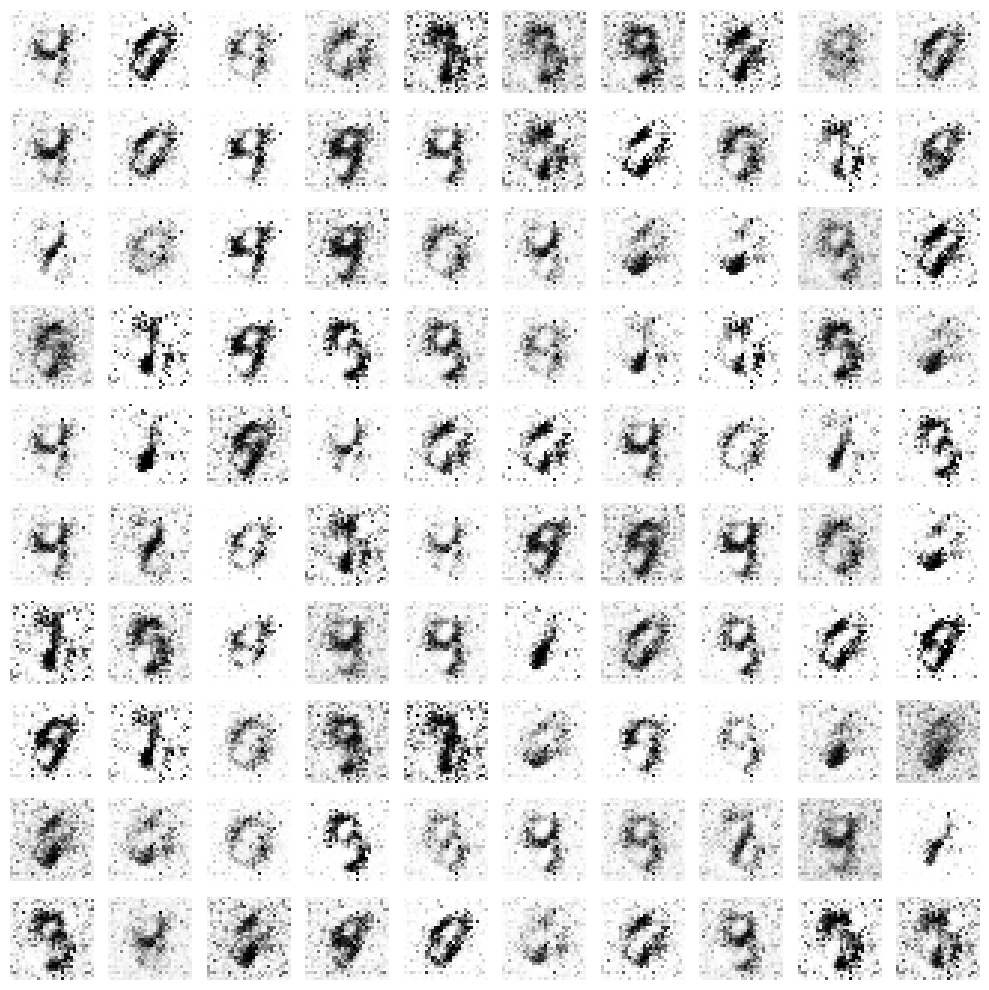

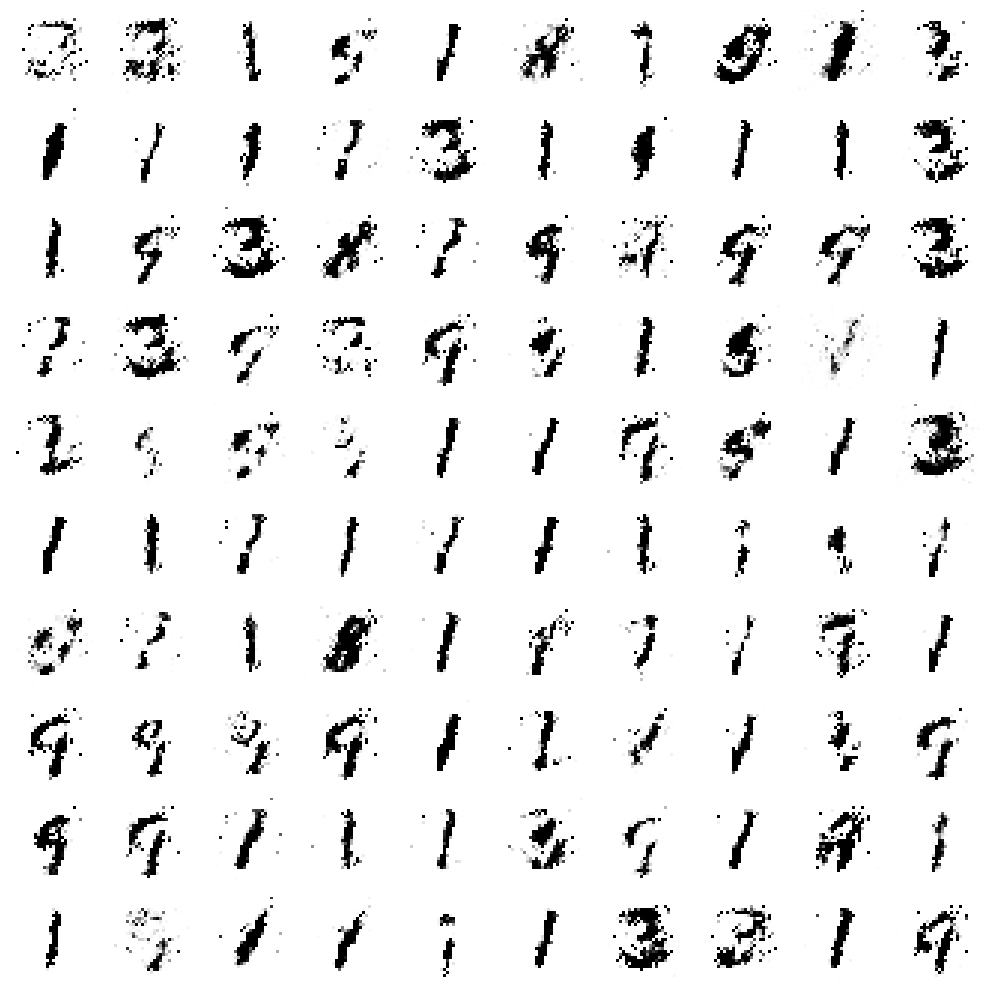

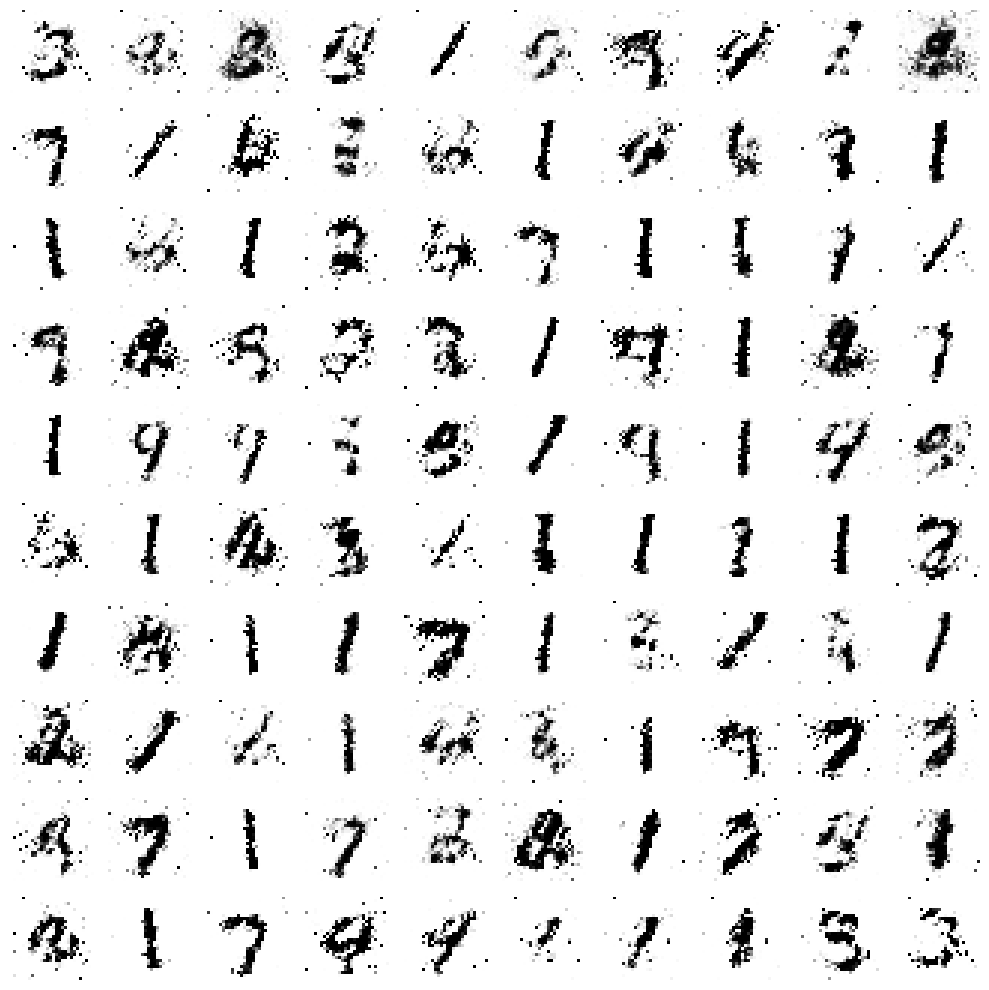

In [69]:
 train(epochs=10) # 1 up me to 20